## LoRAs of the World Unite - Training SOTA DreamBooth LoRA with Pivotal Tuning 🧨

In this notebook, we show how to fine-tune [Stable Diffusion XL (SDXL)](https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/stable_diffusion_xl) with [DreamBooth](https://huggingface.co/docs/diffusers/main/en/training/dreambooth) and [LoRA](https://huggingface.co/docs/diffusers/main/en/training/lora) using some of the most popular SOTA methods.

Learn more about the techniques used in this exmaple [here](linke to blogpost)

Let's get started 🧪

## Setup 🪓

In [1]:
# Install dependencies.
!pip install xformers bitsandbytes transformers accelerate wandb dadaptation prodigyopt -q

In [2]:
!pip install peft -q

Make sure to install `diffusers` from `main`.

In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

Download diffusers SDXL DreamBooth training script.

In [96]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py

--2025-02-20 20:15:44--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/advanced_diffusion_training/train_dreambooth_lora_sdxl_advanced.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
200 OKequest sent, awaiting response... 
Length: 108005 (105K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl_advanced.py’

train_dreambooth_lo 100%[===================>] 105.47K  --.-KB/s    in 0.004s  

2025-02-20 20:15:44 (28.7 MB/s) - ‘train_dreambooth_lora_sdxl_advanced.py’ saved [108005/108005]



## Dataset 🐶

**Let's get our training data!**
For this example, we'll download some images from the hub.

If you already have a dataset on the hub you wish to use, you can skip this part and go straight to: "Prep for
training 💻" section, where you'll simply specify the dataset name.

If your images are saved locally, and/or you want to add BLIP generated captions,
pick option 1 or 2 below.

**Option 1:** upload example images from your local files:

In [1]:
import os
# from google.colab import files

# pick a name for the image folder
local_dir = "./cats" #@param
# os.makedirs(local_dir)
os.chdir('..')

# # choose and upload local images into the newly created directory
# uploaded_images = files.upload()
# os.chdir("/content") # back to parent directory

**Option 2:** download example images from the hub -

In [6]:
from huggingface_hub import snapshot_download

local_dir = "./3d_icon" #@param
dataset_to_download = "LinoyTsaban/3d_icon" #@param
snapshot_download(
    dataset_to_download,
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.3.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

'/home/ubuntu/KarolMgr/sd-imbalance/notebooks/3d_icon'

Preview the images:

In [39]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

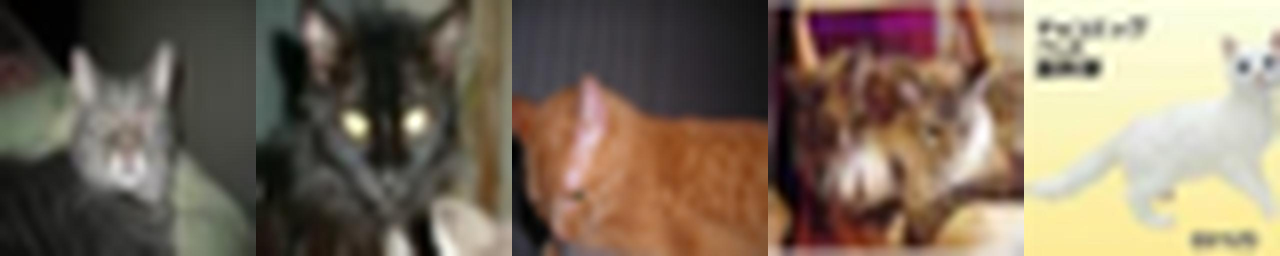

In [64]:
import glob
local_dir = "./cats"
img_paths = f"{local_dir}/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

### Generate custom captions with BLIP

Load BLIP2 to auto caption your images:


**Note:** if you downloaded the `LinoyTsaban/3d_icon dataset` from the hub, you would find it already contains captions (generated with BLIP and prefixed with a token identifier) in the `metadata.jsonl` file
You can skip this part if you wish to train on that dataset using the existing captions.

In [82]:
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
# load pipelines
blip_processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",torch_dtype=torch.float16).to(device)

## IMAGE CPATIONING ##
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [83]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]
imgs_and_paths

[('./cat_1.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF59B40730>),
 ('./cat_2.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF59B405B0>),
 ('./cat_3.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF5A7648B0>),
 ('./cat_4.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492DD20>),
 ('./cat_5.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492F430>),
 ('./cat_6.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492F070>),
 ('./cat_7.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492CBE0>),
 ('./cat_8.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492C7C0>),
 ('./cat_9.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492EB60>),
 ('./cat_10.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB siz

Now let's add the concept token identifier (e.g. TOK) to each caption using a caption prefix.

*Note:* When training with **pivotal tuning**, this token identifier (e.g. TOK) is only a **place holder**, and will be mapped to new tokens we insert to the tokenizers - so no need to spend too much time choosing the token!

Change the prefix according to the concept you're training on:
- for this example we can use "In the style of TOK," other options include:
    - For objects - "photoof a TOK/ a TOK"
    - For faces - "photo of a TOK person"
- You can add additional identifiers to the prefix that can help steer the model in the right direction.
-- e.g. for this example, instead of "In the style of TOK" we can use "3d icon in the style of TOK"/"a TOK 3d style icon"

saves image paths and corresponding prompts to metadata file for training

In [84]:
imgs_and_paths

[('./cat_1.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF59B40730>),
 ('./cat_2.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF59B405B0>),
 ('./cat_3.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF5A7648B0>),
 ('./cat_4.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492DD20>),
 ('./cat_5.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492F430>),
 ('./cat_6.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492F070>),
 ('./cat_7.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492CBE0>),
 ('./cat_8.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492C7C0>),
 ('./cat_9.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7FCF6492EB60>),
 ('./cat_10.jpg',
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB siz

In [85]:
import json
from IPython.display import display, Markdown

caption_prefix = "Realistic blurry image of " #@param

# saves each caption and corresponding image to a metadata.jsonl file
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

display(Markdown(f"Your image captions are ready here: {local_dir}metadata.jsonl"))

Your image captions are ready here: ./metadata.jsonl

Free some memory:

In [86]:
import gc

# delete the BLIP2 pipelines and clear up some memory
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

## Prep for training 💻

Initialize `accelerate`:

In [87]:
!accelerate config default

Configuration already exists at /home/ubuntu/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


### Log into your Hugging Face account
Pass [your **write** access token](https://huggingface.co/settings/tokens) so that we can push the trained checkpoints to the Hugging Face Hub:

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Train! 🔬

### `Diffusers` 🧨 Training loop

### hyperparameters 📐
1. **How to choose your hyperparams?** Check out this [blog post]() - where we explore and comapre different hyperparmas and configurations for different use cases, depending on your data and subject.     

2. **Make sure to add** `push_to_hub` so that the checkpoint is automatically pushed to the Hub and doesn't get lost. The `--push_to_hub` argument ensures that the trained checkpoints are automatically pushed to the Hugging Face Hub.

3. Some paramters that can help us with **compute** when doing DreamBooth with LoRA on a heavy pipeline like Stable Diffusion XL:

    * Gradient checkpointing (`--gradient_accumulation_steps`)
    * 8-bit Adam (`--use_8bit_adam`) - optional when using `--optimizer='AdamW'`, with `--optimizer='Prodigy'` this will be ignored
    * Mixed-precision training (`--mixed-precision="bf16"`)



### Launch training 🚀🚀🚀

**To allow for custom captions** we need to install the `datasets` library:
- Use `--caption_column` to specify name of the cpation column in your dataset.
    - In this example we used `"prompt"` to
       save our captions in the metadata file, change this according to your needs.

**Otherwise:**
- you can skip the installation if you want to train soley with `--instance_prompt`.
  in that case, specify `--instance_data_dir` instead of `--dataset_name`

In [15]:
# makes sure we install datasets from main
!pip install git+https://github.com/huggingface/datasets.git -q

#### 🤗Pick a name for your Dreambooth LoRA fine-tuned model:🤗
This name will be used to save your model, so pick an informative name based on your chosen concept💡

In [4]:
!pip install python-slugify
from slugify import slugify

model_name = "CIFAR10cats" # @param
output_dir = slugify(model_name)

Defaulting to user installation because normal site-packages is not writeable


**Instance & Validation Prompt**
* `instance_prompt` -
    * when custom captions are enabled this prompt is still used in case there are missing captions, as well as in the model's readme.
    * If custom captions are not used, this prompt will be used as the caption for all training images.
* `validation_prompt` -
    * this prompt is used to generate images throught the training process, this way you can see the models learning curve during training.
    * you can also change `num_validation_images` (4 by default) and `validation_epochs` (50 by default) to control the amount images generated with the validation prompt, and the number of ephochs between each dreambooth validation.  

In [89]:
instance_prompt = "Realistic blurry image of cat" # @param
validation_prompt = "Realistic blurry image of a cat facing front on sofa" # @param

**Set your LoRA rank**
The rank of your LoRA is linked to its expressiveness.
The bigger the rank the closer we are to regular dreambooth, and in theory we have more expressive power (and heavier weights).

For a very simple concept that you have a good high quality image set for (e.g. a pet, a generic object), a rank as low as 4 can be enough to get great results. We reccomend going between 8 and 64 depending on your concept and how much of a priortiy it is for you to keep the LoRA small or not.  

In [90]:
!pip install -U pillow

Defaulting to user installation because normal site-packages is not writeable


In [92]:
rank = 8 # @param

In [104]:
os.chdir("..")

In [105]:
!ls

3d-icon-sdxl-lora
3d_icon
SDXL_Dreambooth_LoRA_advanced_example.ipynb
cat_generation.ipynb
cats
catsmetadata.jsonl
real
stable-diffusion-3.5-large-turbo
train_dreambooth_lora_sdxl_advanced.py
train_dreambooth_lora_sdxl_advanced.py.1
wandb


In [107]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl_advanced.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="./cats" \
  --instance_prompt="$instance_prompt" \
  --validation_prompt="$validation_prompt" \
  --output_dir="$output_dir" \
  --caption_column="prompt" \
  --mixed_precision="bf16" \
  --resolution=512 \
  --train_batch_size=3 \
  --repeats=1 \
  --report_to="wandb"\
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1.0 \
  --text_encoder_lr=1.0 \
  --adam_beta2=0.99 \
  --optimizer="prodigy"\
  --train_text_encoder_ti\
  --train_text_encoder_ti_frac=0.5\
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --rank="$rank" \
  --max_train_steps=1000 \
  --checkpointing_steps=2000 \
  --seed="0" \
  --push_to_hub

2025-02-20 20:25:19.427749: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740083119.445441   15139 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740083119.450911   15139 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
02/20/2025 20:25:23 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: bf16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all confi

### Check out your model 🔥

In [5]:
from huggingface_hub import whoami
from pathlib import Path
from IPython.display import display, Markdown

username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

link_to_model = f"https://huggingface.co/{repo_id}"

display(Markdown("### Your model has finished training.\nAccess it here: {}".format(link_to_model)))

### Your model has finished training.
Access it here: https://huggingface.co/kordML/cifar10cats

## Inference 🐕

In [6]:
import torch
from huggingface_hub import hf_hub_download, upload_file
from diffusers import DiffusionPipeline
from diffusers.models import AutoencoderKL
from safetensors.torch import load_file

pipe = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0",
        torch_dtype=torch.float16,
        variant="fp16",
).to("cuda")


pipe.load_lora_weights(repo_id, weight_name="pytorch_lora_weights.safetensors")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

#### Load Pivotal Tuning Embeddings

In [8]:
!ls

README.md	 data		    notebooks		train.log	wandb
__pycache__	 data.py	    notes_and_ideas.md	train.py
cats		 extra-images	    pyproject.toml	utils.py
cifar10_project  extract_images.py  results.md		uv.lock
config		 model.py	    scripts		vizualisations


In [9]:
text_encoders = [pipe.text_encoder, pipe.text_encoder_2]
tokenizers = [pipe.tokenizer, pipe.tokenizer_2]

embedding_path = 'notebooks/cifar10cats/cifar10cats_emb.safetensors'

state_dict = load_file(embedding_path)
# load embeddings of text_encoder 1 (CLIP ViT-L/14)
pipe.load_textual_inversion(state_dict["clip_l"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder, tokenizer=pipe.tokenizer)
# load embeddings of text_encoder 2 (CLIP ViT-G/14)
pipe.load_textual_inversion(state_dict["clip_g"], token=["<s0>", "<s1>"], text_encoder=pipe.text_encoder_2, tokenizer=pipe.tokenizer_2)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


  0%|          | 0/25 [00:00<?, ?it/s]

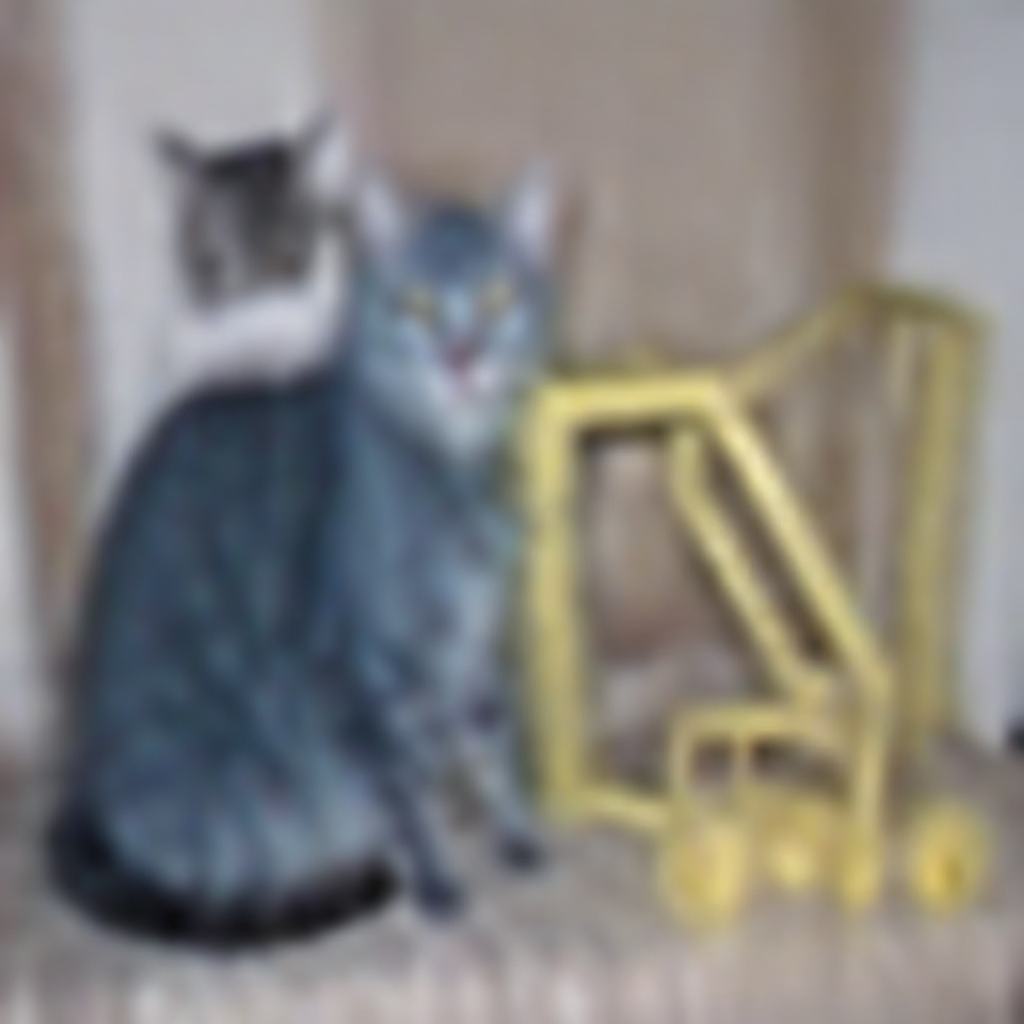

In [12]:
instance_token = "<s0><s1>"
prompt = f"a blue cat next to yellow toy"

image = pipe(prompt=prompt, num_inference_steps=25, cross_attention_kwargs={"scale": 1.0}).images[0]
image




In [13]:
# !pip3 install -U transformers diffusers accelerate tqdm sentencepiece ipywidgets
# !huggingface-cli login
import itertools
import os
import random

import torch
from diffusers import DiffusionPipeline, StableDiffusion3Pipeline
from tqdm import tqdm

# Expanded list of cat breeds
cat_breeds = [
    "Abyssinian",
    "Aegean",
    "American Bobtail",
    "American Curl",
    "American Ringtail",
    "American Shorthair",
    "American Wirehair",
    "Aphrodite Giant",
    "Arabian Mau",
    "Asian",
    "Asian Semi-longhair",
    "Australian Mist",
    "Balinese",
    "Bambino",
    "Bengal",
    "Birman",
    "Bombay",
    "Brazilian Shorthair",
    "British Longhair",
    "British Shorthair",
    "Burmese",
    "Burmilla",
    "California Spangled",
    "Chantilly-Tiffany",
    "Chartreux",
    "Chausie",
    "Colorpoint Shorthair",
    "Cornish Rex",
    "Cymric",
    "Cyprus",
    "Devon Rex",
    "Donskoy",
    "Dragon Li",
    "Dwelf",
    "Egyptian Mau",
    "European Shorthair",
    "Exotic Shorthair",
    "Foldex",
    "German Rex",
    "Havana Brown",
    "Highlander",
    "Himalayan",
    "Japanese Bobtail",
    "Javanese",
    "Kanaani",
    "Karelian Bobtail",
    "Khao Manee",
    "Kinkalow",
    "Korat",
    "Korean Bobtail",
    "Korn Ja",
    "Kurilian Bobtail",
    "Lambkin",
    "LaPerm",
    "Lykoi",
    "Maine Coon",
    "Manx",
    "Mekong Bobtail",
    "Minskin",
    "Minuet",
    "Munchkin",
    "Nebelung",
    "Neva Masquerade",
    "Norwegian Forest cat",
    "Ocicat",
    "Ojos Azules",
    "Oriental Bicolor",
    "Oriental Longhair",
    "Oriental Shorthair",
    "Persian",
    "Peterbald",
    "Pixie-bob",
    "Ragamuffin",
    "Ragdoll",
    "Raas",
    "Russian Blue",
    "Russian White, Russian Black and Russian Tabby",
    "Sam Sawet",
    "Savannah",
    "Scottish Fold",
    "Selkirk Rex",
    "Serengeti",
    "Siamese",
    "Siberian",
    "Singapura",
    "Snowshoe",
    "Sokoke",
    "Somali",
    "Sphynx",
    "Suphalak",
    "Thai",
    "Thai Lilac",
    "Tonkinese",
    "Toybob",
    "Toyger",
    "Turkish Angora",
    "Turkish Van",
    "Turkish Vankedisi",
    "Ukrainian Levkoy",
    "York Chocolate",
]

print(f"Cat breeds: {len(cat_breeds)}")

# Expanded list of prepositions
prepositions = ["on", "under", "next to", "beside", "in front of", "behind"]

# Furniture types that fit with the prepositions
furniture_or_outdoor = {
    "on": [
        # Indoor furniture
        "sofa",
        "armchair",
        "dining table",
        "coffee table",
        "bed",
        "bookshelf",
        "cabinet",
        "cupboard",
        "chair",
        "desk",
        "ottoman",
        "recliner",
        "side table",
        "nightstand",
        "TV stand",
        "TV cabinet",
        "end table",
        "love seat",
        "couch",
        "lounge chair",
        "bean bag",
        "bar stool",
        "console table",
        "chest of drawers",
        "vanity",
        "shelf",
        # Outdoor/natural elements
        "rock",
        "tree stump",
        "fence",
        "bench",
        "picnic table",
        "grass",
        "car hood",
        "roof",
        "garden wall",
        "park bench",
        "log",
        "fallen tree",
        "sand dune",
        "boulder",
    ],
    "under": [
        # Indoor furniture
        "sofa",
        "bed",
        "coffee table",
        "side table",
        "desk",
        "recliner",
        "nightstand",
        "chest of drawers",
        "love seat",
        "couch",
        "bookshelf",
        # Outdoor/natural elements
        "tree",
        "bush",
        "bridge",
        "rock",
        "table",
        "park bench",
        "porch",
        "car",
        "wooden deck",
        "fallen tree",
        "shade",
        "overhang",
    ],
    "next to": [
        # Indoor furniture
        "sofa",
        "armchair",
        "dining table",
        "coffee table",
        "bookshelf",
        "cabinet",
        "cupboard",
        "chair",
        "ottoman",
        "recliner",
        "side table",
        "nightstand",
        "TV stand",
        "end table",
        "love seat",
        "lounge chair",
        "console table",
        "vanity",
        "window sill",
        # Outdoor/natural elements
        "tree",
        "bush",
        "fence",
        "bench",
        "log",
        "rock",
        "flower bed",
        "pathway",
        "pond",
        "stream",
        "hill",
        "park bench",
        "fire hydrant",
        "fallen tree",
    ],
    "beside": [
        # Indoor furniture
        "sofa",
        "armchair",
        "dining table",
        "coffee table",
        "bed",
        "bookshelf",
        "chair",
        "ottoman",
        "recliner",
        "side table",
        "nightstand",
        "love seat",
        "couch",
        "lounge chair",
        "vanity",
        # Outdoor/natural elements
        "tree",
        "rock",
        "bush",
        "fence",
        "bench",
        "stream",
        "pathway",
        "log",
        "garden wall",
        "pond",
        "flower bed",
        "hill",
        "fallen tree",
    ],
    "in front of": [
        # Indoor furniture
        "sofa",
        "armchair",
        "coffee table",
        "cabinet",
        "cupboard",
        "TV stand",
        "console table",
        "chest of drawers",
        "bed",
        "recliner",
        "side table",
        "dining chairs",
        "love seat",
        # Outdoor/natural elements
        "tree",
        "rock",
        "fence",
        "bush",
        "bench",
        "stream",
        "pathway",
        "building",
        "garden wall",
        "pond",
        "waterfall",
        "hill",
        "statue",
    ],
    "behind": [
        # Indoor furniture
        "sofa",
        "armchair",
        "bookshelf",
        "recliner",
        "cabinet",
        "TV stand",
        "chest of drawers",
        "love seat",
        # Outdoor/natural elements
        "tree",
        "bush",
        "fence",
        "rock",
        "log",
        "bench",
        "building",
        "hill",
        "statue",
        "garden wall",
        "shed",
    ],
}
camera_angles = [
    "a photo taken from above",
    "a photo taken from below",
    "a side-view photo",
    "a front-facing photo",
    "a photo taken from behind",
]

# List of gaze directions
gaze_directions = [
    "looking straight ahead",
    "looking up",
    "looking down",
    "looking to the left",
    "looking to the right",
    "looking up and to the left",
    "looking up and to the right",
    "looking down and to the left",
    "looking down and to the right",
    "eyes closed",
    "looking over its shoulder",
]
print(f"Prepositions: {len(furniture_or_outdoor)}")
print(
    f"Objects: {len(set(list(itertools.chain.from_iterable(furniture_or_outdoor.values()))))}",
)

Cat breeds: 100
Prepositions: 6
Objects: 61


In [14]:
import numpy as np


def set_seeds(seed=42):
    """Fix all possible seeds to ensure reproducibility.
    :param seed: The seed value to be set for all libraries.
    """
    # Python random module
    random.seed(seed)
    # NumPy
    np.random.seed(seed)
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU
    torch.backends.cudnn.deterministic = True  # Ensures deterministic behavior
    torch.backends.cudnn.benchmark = False  # Disables optimizations for reproducibility
    # Environment variable for other libraries or hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)


# Example usage
set_seeds(42)

In [19]:
def make_img(folder: str = "./tmp", num_inference_steps=25, guidance_scale=0.0, num_images=4):
    # Directory to save generated images
    output_dir = folder
    os.makedirs(output_dir, exist_ok=True)
    set_seeds(42)
    # Generate synthetic images
    num_images = num_images
    for i in tqdm(range(num_images), desc="Generating Images"):
        # Randomly select components for the prompt
        breed = random.choice(cat_breeds)
        preposition = random.choice(prepositions)
        furniture = random.choice(furniture_or_outdoor[preposition])
        angle = random.choice(camera_angles)
        gaze = random.choice(gaze_directions)

        # Construct the prompt
        prompt = (
            f"Realistic image of a cat sitting {preposition} a {furniture}"
        )
        print(prompt)
        pipe.to(torch.bfloat16)

        try:
            # Generate image
            result = pipe(
                prompt,
                num_inference_steps=25, cross_attention_kwargs={"scale": 1.0},
                guidance_scale=guidance_scale,
                width=512,
                height=512,
            )
            image = result.images[0]  # Get the first image from the list

            # Save the generated image
            output_path = os.path.join(
                output_dir,
                f"small_{i:05d}_cat_{breed}_{preposition}_{furniture}.png",
            )
            image.save(output_path)

        except Exception as e:
            print(f"Failed to generate image {i}: {e}")

    print(f"Generated {num_images} images and saved them in {output_dir}.")

In [ ]:
make_img("simple_prompt_stable-diffusion-3.5-large-turbo", num_images=10000)

Generating Images:   0%|          | 0/10000 [00:00<?, ?it/s]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 1/10000 [00:04<12:17:44,  4.43s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 2/10000 [00:08<12:09:06,  4.38s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 3/10000 [00:13<12:06:30,  4.36s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 4/10000 [00:17<12:06:47,  4.36s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 5/10000 [00:21<12:05:56,  4.36s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 6/10000 [00:26<12:08:06,  4.37s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 7/10000 [00:30<12:04:40,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 8/10000 [00:34<12:02:36,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 9/10000 [00:39<12:01:09,  4.33s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 10/10000 [00:43<11:59:49,  4.32s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 11/10000 [00:47<11:58:10,  4.31s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 12/10000 [00:52<11:57:04,  4.31s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 13/10000 [00:56<11:56:37,  4.31s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 14/10000 [01:00<11:59:10,  4.32s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 15/10000 [01:05<12:04:58,  4.36s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 16/10000 [01:09<12:03:14,  4.35s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 17/10000 [01:13<12:02:23,  4.34s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 18/10000 [01:18<12:04:18,  4.35s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 19/10000 [01:22<12:03:47,  4.35s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 20/10000 [01:26<12:03:37,  4.35s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 21/10000 [01:31<12:02:52,  4.35s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 22/10000 [01:35<12:03:02,  4.35s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 23/10000 [01:39<12:02:09,  4.34s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 24/10000 [01:44<12:01:51,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 25/10000 [01:48<11:58:49,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 26/10000 [01:52<11:56:03,  4.31s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 27/10000 [01:57<11:55:03,  4.30s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 28/10000 [02:01<11:53:07,  4.29s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 29/10000 [02:05<11:57:58,  4.32s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 30/10000 [02:10<11:58:11,  4.32s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 31/10000 [02:14<12:01:26,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 32/10000 [02:18<11:59:22,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 33/10000 [02:23<11:57:46,  4.32s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 34/10000 [02:27<11:57:17,  4.32s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 35/10000 [02:31<11:58:32,  4.33s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 36/10000 [02:36<11:57:54,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 37/10000 [02:40<11:58:22,  4.33s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 38/10000 [02:44<11:58:05,  4.32s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 39/10000 [02:49<11:58:46,  4.33s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 40/10000 [02:53<12:00:06,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 41/10000 [02:57<11:57:04,  4.32s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 42/10000 [03:01<11:58:21,  4.33s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 43/10000 [03:06<12:01:30,  4.35s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 44/10000 [03:10<11:59:55,  4.34s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 45/10000 [03:15<11:58:49,  4.33s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 46/10000 [03:19<11:56:31,  4.32s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 47/10000 [03:23<11:57:04,  4.32s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 48/10000 [03:28<11:59:41,  4.34s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 49/10000 [03:32<12:01:21,  4.35s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   0%|          | 50/10000 [03:36<12:01:38,  4.35s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 51/10000 [03:41<11:59:30,  4.34s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 52/10000 [03:45<11:59:23,  4.34s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 53/10000 [03:49<11:57:18,  4.33s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 54/10000 [03:54<11:56:34,  4.32s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 55/10000 [03:58<11:57:17,  4.33s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 56/10000 [04:02<11:57:28,  4.33s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 57/10000 [04:06<11:55:59,  4.32s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 58/10000 [04:11<11:54:49,  4.31s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 59/10000 [04:15<11:52:40,  4.30s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 60/10000 [04:19<11:51:32,  4.30s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 61/10000 [04:24<11:52:32,  4.30s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 62/10000 [04:28<11:50:50,  4.29s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 63/10000 [04:32<11:52:05,  4.30s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 64/10000 [04:37<11:51:34,  4.30s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 65/10000 [04:41<11:51:39,  4.30s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 66/10000 [04:45<11:52:26,  4.30s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 67/10000 [04:49<11:51:06,  4.30s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 68/10000 [04:54<11:54:54,  4.32s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 69/10000 [04:58<11:55:29,  4.32s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 70/10000 [05:02<11:57:45,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 71/10000 [05:07<12:02:24,  4.37s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 72/10000 [05:11<12:00:46,  4.36s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 73/10000 [05:16<12:00:21,  4.35s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 74/10000 [05:20<11:59:58,  4.35s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 75/10000 [05:24<11:58:00,  4.34s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 76/10000 [05:29<11:56:11,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 77/10000 [05:33<11:56:58,  4.34s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 78/10000 [05:37<11:56:21,  4.33s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 79/10000 [05:42<11:58:26,  4.35s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 80/10000 [05:46<11:56:51,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 81/10000 [05:50<11:57:17,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 82/10000 [05:55<11:56:19,  4.33s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 83/10000 [05:59<11:56:54,  4.34s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 84/10000 [06:03<11:57:23,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 85/10000 [06:08<11:56:44,  4.34s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 86/10000 [06:12<11:56:26,  4.34s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 87/10000 [06:16<11:53:04,  4.32s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 88/10000 [06:20<11:50:23,  4.30s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 89/10000 [06:25<11:50:27,  4.30s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 90/10000 [06:29<11:48:50,  4.29s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 91/10000 [06:33<11:48:22,  4.29s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 92/10000 [06:38<11:48:51,  4.29s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 93/10000 [06:42<11:48:27,  4.29s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 94/10000 [06:46<11:47:59,  4.29s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 95/10000 [06:51<11:50:45,  4.31s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 96/10000 [06:55<11:52:38,  4.32s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 97/10000 [06:59<11:50:30,  4.30s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 98/10000 [07:04<11:52:35,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 99/10000 [07:08<11:51:08,  4.31s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 100/10000 [07:12<11:51:23,  4.31s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 101/10000 [07:16<11:50:34,  4.31s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 102/10000 [07:21<11:50:55,  4.31s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 103/10000 [07:25<11:50:37,  4.31s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 104/10000 [07:29<11:50:02,  4.31s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 105/10000 [07:34<11:52:25,  4.32s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 106/10000 [07:38<11:52:34,  4.32s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 107/10000 [07:42<11:52:46,  4.32s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 108/10000 [07:47<11:52:15,  4.32s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 109/10000 [07:51<11:50:45,  4.31s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 110/10000 [07:55<11:51:36,  4.32s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 111/10000 [08:00<11:52:22,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 112/10000 [08:04<11:53:40,  4.33s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 113/10000 [08:08<11:53:34,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 114/10000 [08:13<11:55:02,  4.34s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 115/10000 [08:17<11:56:44,  4.35s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 116/10000 [08:21<11:57:02,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 117/10000 [08:26<11:56:37,  4.35s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 118/10000 [08:30<11:54:45,  4.34s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 119/10000 [08:34<11:53:24,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 120/10000 [08:39<11:52:57,  4.33s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 121/10000 [08:43<11:51:56,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 122/10000 [08:47<11:51:36,  4.32s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 123/10000 [08:52<11:51:26,  4.32s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|          | 124/10000 [08:56<11:50:57,  4.32s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 125/10000 [09:00<11:51:19,  4.32s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 126/10000 [09:05<11:51:02,  4.32s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 127/10000 [09:09<11:52:52,  4.33s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 128/10000 [09:13<11:51:13,  4.32s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 129/10000 [09:18<11:51:02,  4.32s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 130/10000 [09:22<11:50:17,  4.32s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 131/10000 [09:26<11:50:04,  4.32s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 132/10000 [09:31<11:52:06,  4.33s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 133/10000 [09:35<11:51:17,  4.33s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 134/10000 [09:39<11:52:29,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 135/10000 [09:44<11:52:25,  4.33s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 136/10000 [09:48<11:51:58,  4.33s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 137/10000 [09:52<11:53:12,  4.34s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 138/10000 [09:57<11:54:12,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 139/10000 [10:01<11:54:53,  4.35s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 140/10000 [10:05<11:53:53,  4.34s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 141/10000 [10:10<11:56:40,  4.36s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 142/10000 [10:14<11:55:40,  4.36s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 143/10000 [10:18<11:54:04,  4.35s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 144/10000 [10:23<11:54:30,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 145/10000 [10:27<11:54:07,  4.35s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 146/10000 [10:31<11:53:15,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 147/10000 [10:36<11:52:45,  4.34s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 148/10000 [10:40<11:53:42,  4.35s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   1%|▏         | 149/10000 [10:44<11:54:12,  4.35s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 150/10000 [10:49<11:51:35,  4.33s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 151/10000 [10:53<11:49:38,  4.32s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 152/10000 [10:57<11:49:53,  4.33s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 153/10000 [11:02<11:50:25,  4.33s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 154/10000 [11:06<11:49:11,  4.32s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 155/10000 [11:10<11:49:27,  4.32s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 156/10000 [11:15<11:49:15,  4.32s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 157/10000 [11:19<11:47:07,  4.31s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 158/10000 [11:23<11:47:56,  4.32s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 159/10000 [11:28<11:44:58,  4.30s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 160/10000 [11:32<11:44:59,  4.30s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 161/10000 [11:36<11:44:28,  4.30s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 162/10000 [11:41<11:48:27,  4.32s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 163/10000 [11:45<11:50:13,  4.33s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 164/10000 [11:49<11:50:15,  4.33s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 165/10000 [11:54<11:50:48,  4.34s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 166/10000 [11:58<11:48:30,  4.32s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 167/10000 [12:02<11:49:38,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 168/10000 [12:07<11:51:01,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 169/10000 [12:11<11:50:35,  4.34s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 170/10000 [12:15<11:50:21,  4.34s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 171/10000 [12:20<11:53:08,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 172/10000 [12:24<11:53:31,  4.36s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 173/10000 [12:28<11:52:35,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 174/10000 [12:33<11:48:51,  4.33s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 175/10000 [12:37<12:12:20,  4.47s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 176/10000 [12:42<12:04:39,  4.43s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 177/10000 [12:46<11:58:31,  4.39s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 178/10000 [12:50<11:53:26,  4.36s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 179/10000 [12:55<11:51:43,  4.35s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 180/10000 [12:59<11:51:29,  4.35s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 181/10000 [13:03<11:50:59,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 182/10000 [13:08<11:48:03,  4.33s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 183/10000 [13:12<11:52:05,  4.35s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 184/10000 [13:16<11:49:43,  4.34s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 185/10000 [13:21<11:48:05,  4.33s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 186/10000 [13:25<11:48:20,  4.33s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 187/10000 [13:29<11:48:35,  4.33s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 188/10000 [13:34<11:48:22,  4.33s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 189/10000 [13:38<11:48:54,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 190/10000 [13:42<11:51:27,  4.35s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 191/10000 [13:47<11:50:08,  4.34s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 192/10000 [13:51<11:48:22,  4.33s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 193/10000 [13:55<11:48:08,  4.33s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 194/10000 [14:00<11:48:35,  4.34s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 195/10000 [14:04<11:47:47,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 196/10000 [14:08<11:47:09,  4.33s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 197/10000 [14:13<11:48:29,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 198/10000 [14:17<11:45:57,  4.32s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 199/10000 [14:21<11:44:37,  4.31s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 200/10000 [14:26<11:43:02,  4.30s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 201/10000 [14:30<11:43:01,  4.30s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 202/10000 [14:34<11:42:35,  4.30s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 203/10000 [14:38<11:42:55,  4.30s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 204/10000 [14:43<11:42:28,  4.30s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 205/10000 [14:47<11:42:07,  4.30s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 206/10000 [14:51<11:40:57,  4.29s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 207/10000 [14:56<11:41:01,  4.30s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 208/10000 [15:00<11:42:50,  4.31s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 209/10000 [15:04<11:40:06,  4.29s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 210/10000 [15:09<11:41:16,  4.30s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 211/10000 [15:13<11:42:48,  4.31s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 212/10000 [15:17<11:44:04,  4.32s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 213/10000 [15:22<11:46:13,  4.33s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 214/10000 [15:26<11:50:10,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 215/10000 [15:30<11:49:08,  4.35s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 216/10000 [15:35<11:49:07,  4.35s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 217/10000 [15:39<11:47:47,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 218/10000 [15:43<11:48:30,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 219/10000 [15:48<11:49:09,  4.35s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 220/10000 [15:52<11:49:19,  4.35s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 221/10000 [15:56<11:50:26,  4.36s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 222/10000 [16:01<11:48:56,  4.35s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 223/10000 [16:05<11:48:45,  4.35s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 224/10000 [16:09<11:47:30,  4.34s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 225/10000 [16:14<11:47:19,  4.34s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 226/10000 [16:18<11:45:06,  4.33s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 227/10000 [16:22<11:44:24,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 228/10000 [16:27<11:45:04,  4.33s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 229/10000 [16:31<11:42:11,  4.31s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 230/10000 [16:35<11:45:31,  4.33s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 231/10000 [16:40<11:44:50,  4.33s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 232/10000 [16:44<11:43:39,  4.32s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 233/10000 [16:48<11:45:01,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 234/10000 [16:53<11:45:53,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 235/10000 [16:57<11:44:47,  4.33s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 236/10000 [17:01<11:44:20,  4.33s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 237/10000 [17:06<11:42:57,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 238/10000 [17:10<11:43:15,  4.32s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 239/10000 [17:14<11:42:02,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 240/10000 [17:19<11:43:24,  4.32s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 241/10000 [17:23<11:42:33,  4.32s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 242/10000 [17:27<11:43:10,  4.32s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 243/10000 [17:32<11:43:30,  4.33s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 244/10000 [17:36<11:44:20,  4.33s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 245/10000 [17:40<11:44:34,  4.33s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 246/10000 [17:45<11:45:25,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 247/10000 [17:49<11:45:30,  4.34s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 248/10000 [17:53<11:45:45,  4.34s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▏         | 249/10000 [17:58<11:45:39,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   2%|▎         | 250/10000 [18:02<11:44:55,  4.34s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 251/10000 [18:06<11:44:02,  4.33s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 252/10000 [18:11<11:45:10,  4.34s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 253/10000 [18:15<11:43:12,  4.33s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 254/10000 [18:19<11:46:44,  4.35s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 255/10000 [18:24<11:47:33,  4.36s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 256/10000 [18:28<11:43:16,  4.33s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 257/10000 [18:32<11:41:01,  4.32s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 258/10000 [18:37<11:40:46,  4.32s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 259/10000 [18:41<11:40:16,  4.31s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 260/10000 [18:45<11:39:25,  4.31s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 261/10000 [18:50<11:40:22,  4.31s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 262/10000 [18:54<11:41:32,  4.32s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 263/10000 [18:58<11:41:29,  4.32s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 264/10000 [19:03<11:42:26,  4.33s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 265/10000 [19:07<11:43:43,  4.34s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 266/10000 [19:11<11:43:29,  4.34s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 267/10000 [19:16<11:42:23,  4.33s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 268/10000 [19:20<11:42:50,  4.33s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 269/10000 [19:24<11:43:59,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 270/10000 [19:29<11:43:50,  4.34s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 271/10000 [19:33<11:42:51,  4.33s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 272/10000 [19:37<11:42:59,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 273/10000 [19:42<11:43:03,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 274/10000 [19:46<11:43:11,  4.34s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 275/10000 [19:50<11:42:49,  4.34s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 276/10000 [19:55<11:41:05,  4.33s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 277/10000 [19:59<11:39:49,  4.32s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 278/10000 [20:03<11:39:20,  4.32s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 279/10000 [20:07<11:39:02,  4.31s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 280/10000 [20:12<11:39:24,  4.32s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 281/10000 [20:16<11:44:04,  4.35s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 282/10000 [20:21<11:42:54,  4.34s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 283/10000 [20:25<11:43:35,  4.34s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 284/10000 [20:29<11:42:33,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 285/10000 [20:34<11:41:24,  4.33s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 286/10000 [20:38<11:38:45,  4.32s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 287/10000 [20:42<11:36:39,  4.30s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 288/10000 [20:46<11:36:43,  4.30s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 289/10000 [20:51<11:36:25,  4.30s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 290/10000 [20:55<11:37:09,  4.31s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 291/10000 [20:59<11:38:34,  4.32s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 292/10000 [21:04<11:39:31,  4.32s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 293/10000 [21:08<11:38:18,  4.32s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 294/10000 [21:12<11:38:55,  4.32s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 295/10000 [21:17<11:38:28,  4.32s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 296/10000 [21:21<11:39:38,  4.33s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 297/10000 [21:25<11:40:19,  4.33s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 298/10000 [21:30<11:40:15,  4.33s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 299/10000 [21:34<11:39:01,  4.32s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 300/10000 [21:38<11:38:54,  4.32s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 301/10000 [21:43<11:37:41,  4.32s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 302/10000 [21:47<11:37:39,  4.32s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 303/10000 [21:51<11:38:35,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 304/10000 [21:56<11:37:39,  4.32s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 305/10000 [22:00<11:36:46,  4.31s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 306/10000 [22:04<11:35:52,  4.31s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 307/10000 [22:08<11:35:57,  4.31s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 308/10000 [22:14<12:26:33,  4.62s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 309/10000 [22:18<12:13:50,  4.54s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 310/10000 [22:22<12:03:31,  4.48s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 311/10000 [22:27<11:56:03,  4.43s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 312/10000 [22:31<11:49:33,  4.39s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 313/10000 [22:35<11:47:14,  4.38s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 314/10000 [22:40<11:44:55,  4.37s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 315/10000 [22:44<11:41:23,  4.35s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 316/10000 [22:48<11:41:10,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 317/10000 [22:53<11:40:22,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 318/10000 [22:57<11:41:21,  4.35s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 319/10000 [23:02<11:43:42,  4.36s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 320/10000 [23:06<11:43:36,  4.36s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 321/10000 [23:10<11:42:21,  4.35s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 322/10000 [23:15<11:41:41,  4.35s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 323/10000 [23:19<11:42:03,  4.35s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 324/10000 [23:23<11:42:21,  4.36s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 325/10000 [23:28<11:42:19,  4.36s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 326/10000 [23:32<11:42:55,  4.36s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 327/10000 [23:36<11:42:08,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 328/10000 [23:41<11:41:00,  4.35s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 329/10000 [23:45<11:39:39,  4.34s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 330/10000 [23:49<11:37:42,  4.33s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 331/10000 [23:54<11:36:47,  4.32s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 332/10000 [23:58<11:37:07,  4.33s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 333/10000 [24:02<11:38:40,  4.34s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 334/10000 [24:07<11:38:20,  4.33s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 335/10000 [24:11<11:39:34,  4.34s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 336/10000 [24:15<11:37:45,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 337/10000 [24:20<11:36:57,  4.33s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 338/10000 [24:24<11:38:46,  4.34s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 339/10000 [24:28<11:36:02,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 340/10000 [24:33<11:35:24,  4.32s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 341/10000 [24:37<11:36:37,  4.33s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 342/10000 [24:41<11:36:45,  4.33s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 343/10000 [24:46<11:36:15,  4.33s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 344/10000 [24:50<11:35:05,  4.32s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 345/10000 [24:54<11:34:17,  4.31s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 346/10000 [24:58<11:33:43,  4.31s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 347/10000 [25:03<11:33:08,  4.31s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 348/10000 [25:07<11:33:20,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   3%|▎         | 349/10000 [25:11<11:31:05,  4.30s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 350/10000 [25:16<11:31:04,  4.30s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 351/10000 [25:20<11:34:01,  4.32s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 352/10000 [25:24<11:33:43,  4.31s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 353/10000 [25:29<11:31:51,  4.30s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 354/10000 [25:33<11:32:25,  4.31s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 355/10000 [25:37<11:32:16,  4.31s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 356/10000 [25:42<11:33:43,  4.32s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 357/10000 [25:46<11:36:44,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 358/10000 [25:50<11:37:03,  4.34s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 359/10000 [25:55<11:36:51,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 360/10000 [25:59<11:37:22,  4.34s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 361/10000 [26:03<11:36:00,  4.33s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 362/10000 [26:08<11:36:00,  4.33s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 363/10000 [26:12<11:39:42,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 364/10000 [26:16<11:39:18,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 365/10000 [26:21<11:37:06,  4.34s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 366/10000 [26:25<11:38:03,  4.35s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 367/10000 [26:29<11:35:10,  4.33s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 368/10000 [26:34<11:33:07,  4.32s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 369/10000 [26:38<11:32:23,  4.31s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 370/10000 [26:42<11:34:38,  4.33s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 371/10000 [26:47<11:33:03,  4.32s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 372/10000 [26:51<11:32:21,  4.31s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 373/10000 [26:55<11:33:39,  4.32s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▎         | 374/10000 [27:00<11:35:38,  4.34s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 375/10000 [27:04<11:37:40,  4.35s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 376/10000 [27:08<11:36:25,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 377/10000 [27:13<11:35:49,  4.34s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 378/10000 [27:17<11:36:03,  4.34s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 379/10000 [27:21<11:34:48,  4.33s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 380/10000 [27:26<11:35:02,  4.33s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 381/10000 [27:30<11:33:39,  4.33s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 382/10000 [27:34<11:32:58,  4.32s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 383/10000 [27:39<11:35:24,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 384/10000 [27:43<11:36:52,  4.35s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 385/10000 [27:47<11:36:04,  4.34s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 386/10000 [27:52<11:36:01,  4.34s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 387/10000 [27:56<11:34:49,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 388/10000 [28:00<11:33:16,  4.33s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 389/10000 [28:05<11:34:01,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 390/10000 [28:09<11:31:35,  4.32s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 391/10000 [28:13<11:30:33,  4.31s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 392/10000 [28:18<11:30:18,  4.31s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 393/10000 [28:22<11:29:31,  4.31s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 394/10000 [28:26<11:27:33,  4.29s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 395/10000 [28:30<11:27:20,  4.29s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 396/10000 [28:35<11:26:56,  4.29s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 397/10000 [28:39<11:26:23,  4.29s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 398/10000 [28:43<11:30:54,  4.32s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 399/10000 [28:48<11:32:04,  4.33s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 400/10000 [28:52<11:31:14,  4.32s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 401/10000 [28:56<11:30:01,  4.31s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 402/10000 [29:01<11:30:29,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 403/10000 [29:05<11:30:54,  4.32s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 404/10000 [29:09<11:31:32,  4.32s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 405/10000 [29:14<11:32:05,  4.33s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 406/10000 [29:18<11:31:03,  4.32s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 407/10000 [29:22<11:31:44,  4.33s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 408/10000 [29:27<11:32:53,  4.33s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 409/10000 [29:31<11:31:01,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 410/10000 [29:35<11:27:58,  4.30s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 411/10000 [29:39<11:27:14,  4.30s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 412/10000 [29:44<11:29:01,  4.31s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 413/10000 [29:48<11:28:52,  4.31s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 414/10000 [29:52<11:27:22,  4.30s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 415/10000 [29:57<11:29:09,  4.31s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 416/10000 [30:01<11:27:57,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 417/10000 [30:05<11:28:06,  4.31s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 418/10000 [30:10<11:26:37,  4.30s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 419/10000 [30:14<11:25:07,  4.29s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 420/10000 [30:18<11:24:27,  4.29s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 421/10000 [30:23<11:25:42,  4.30s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 422/10000 [30:27<11:25:34,  4.29s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 423/10000 [30:31<11:30:26,  4.33s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 424/10000 [30:36<11:33:10,  4.34s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 425/10000 [30:40<11:31:49,  4.34s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 426/10000 [30:44<11:29:52,  4.32s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 427/10000 [30:48<11:27:55,  4.31s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 428/10000 [30:53<11:26:38,  4.30s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 429/10000 [30:57<11:27:11,  4.31s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 430/10000 [31:01<11:26:41,  4.31s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 431/10000 [31:06<11:25:53,  4.30s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 432/10000 [31:10<11:23:58,  4.29s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 433/10000 [31:14<11:26:21,  4.30s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 434/10000 [31:19<11:28:12,  4.32s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 435/10000 [31:23<11:27:42,  4.31s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 436/10000 [31:27<11:28:58,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 437/10000 [31:32<11:28:23,  4.32s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 438/10000 [31:36<11:26:24,  4.31s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 439/10000 [31:40<11:26:17,  4.31s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 440/10000 [31:44<11:25:07,  4.30s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 441/10000 [31:49<11:23:25,  4.29s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 442/10000 [31:53<11:23:44,  4.29s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 443/10000 [31:57<11:23:17,  4.29s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 444/10000 [32:02<11:24:02,  4.29s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 445/10000 [32:06<11:25:35,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 446/10000 [32:10<11:25:26,  4.30s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 447/10000 [32:15<11:24:48,  4.30s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 448/10000 [32:19<11:24:28,  4.30s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 449/10000 [32:23<11:23:46,  4.30s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   4%|▍         | 450/10000 [32:27<11:23:45,  4.30s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 451/10000 [32:32<11:25:43,  4.31s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 452/10000 [32:36<11:27:40,  4.32s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 453/10000 [32:40<11:28:34,  4.33s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 454/10000 [32:45<11:26:58,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 455/10000 [32:49<11:24:56,  4.31s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 456/10000 [32:53<11:25:45,  4.31s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 457/10000 [32:58<11:26:41,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 458/10000 [33:02<11:28:15,  4.33s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 459/10000 [33:06<11:27:24,  4.32s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 460/10000 [33:11<11:30:39,  4.34s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 461/10000 [33:15<11:30:07,  4.34s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 462/10000 [33:19<11:29:14,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 463/10000 [33:24<11:26:43,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 464/10000 [33:28<11:24:40,  4.31s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 465/10000 [33:32<11:23:05,  4.30s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 466/10000 [33:36<11:21:26,  4.29s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 467/10000 [33:41<11:22:58,  4.30s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 468/10000 [33:45<11:23:42,  4.30s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 469/10000 [33:49<11:22:25,  4.30s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 470/10000 [33:54<11:20:43,  4.29s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 471/10000 [33:58<11:19:29,  4.28s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 472/10000 [34:02<11:18:38,  4.27s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 473/10000 [34:06<11:20:15,  4.28s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 474/10000 [34:11<11:18:43,  4.27s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 475/10000 [34:15<11:18:02,  4.27s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 476/10000 [34:19<11:17:57,  4.27s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 477/10000 [34:24<11:17:17,  4.27s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 478/10000 [34:28<11:16:46,  4.26s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 479/10000 [34:32<11:18:48,  4.28s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 480/10000 [34:36<11:19:48,  4.28s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 481/10000 [34:41<11:20:54,  4.29s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 482/10000 [34:45<11:20:42,  4.29s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 483/10000 [34:49<11:19:09,  4.28s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 484/10000 [34:54<11:20:55,  4.29s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 485/10000 [34:58<11:23:30,  4.31s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 486/10000 [35:02<11:25:28,  4.32s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 487/10000 [35:07<11:27:16,  4.33s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 488/10000 [35:11<11:29:10,  4.35s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 489/10000 [35:15<11:29:01,  4.35s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 490/10000 [35:20<11:29:13,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 491/10000 [35:24<11:30:57,  4.36s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 492/10000 [35:28<11:32:13,  4.37s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 493/10000 [35:33<11:33:41,  4.38s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 494/10000 [35:37<11:31:49,  4.37s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 495/10000 [35:42<11:31:23,  4.36s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 496/10000 [35:46<11:48:26,  4.47s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 497/10000 [35:51<11:44:03,  4.45s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 498/10000 [35:55<11:40:58,  4.43s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▍         | 499/10000 [35:59<11:39:56,  4.42s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 500/10000 [36:04<11:37:17,  4.40s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 501/10000 [36:08<11:37:13,  4.40s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 502/10000 [36:13<11:34:58,  4.39s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 503/10000 [36:17<11:31:58,  4.37s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 504/10000 [36:21<11:32:16,  4.37s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 505/10000 [36:26<11:30:00,  4.36s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 506/10000 [36:30<11:28:21,  4.35s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 507/10000 [36:34<11:35:09,  4.39s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 508/10000 [36:39<11:38:19,  4.41s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 509/10000 [36:43<11:42:20,  4.44s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 510/10000 [36:48<11:58:00,  4.54s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 511/10000 [36:53<11:53:45,  4.51s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 512/10000 [36:58<12:50:03,  4.87s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 513/10000 [37:03<12:28:36,  4.73s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 514/10000 [37:07<12:11:54,  4.63s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 515/10000 [37:12<12:03:08,  4.57s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 516/10000 [37:16<11:54:32,  4.52s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 517/10000 [37:20<11:48:44,  4.48s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 518/10000 [37:25<11:43:50,  4.45s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 519/10000 [37:29<11:41:27,  4.44s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 520/10000 [37:34<11:43:08,  4.45s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 521/10000 [37:38<11:46:11,  4.47s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 522/10000 [37:43<11:38:27,  4.42s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 523/10000 [37:47<11:33:36,  4.39s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 524/10000 [37:51<11:28:54,  4.36s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 525/10000 [37:55<11:26:15,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 526/10000 [38:00<11:24:05,  4.33s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 527/10000 [38:04<11:22:05,  4.32s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 528/10000 [38:08<11:21:02,  4.31s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 529/10000 [38:13<11:25:18,  4.34s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 530/10000 [38:17<11:28:34,  4.36s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 531/10000 [38:22<11:30:18,  4.37s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 532/10000 [38:26<11:27:15,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 533/10000 [38:30<11:24:58,  4.34s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 534/10000 [38:34<11:22:43,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 535/10000 [38:39<11:23:25,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 536/10000 [38:43<11:23:33,  4.33s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 537/10000 [38:47<11:24:34,  4.34s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 538/10000 [38:52<11:27:51,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 539/10000 [38:56<11:29:14,  4.37s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 540/10000 [39:01<11:28:32,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 541/10000 [39:05<11:26:38,  4.36s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 542/10000 [39:09<11:27:39,  4.36s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 543/10000 [39:14<11:29:16,  4.37s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 544/10000 [39:18<11:29:34,  4.38s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 545/10000 [39:22<11:27:56,  4.37s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 546/10000 [39:27<11:26:41,  4.36s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 547/10000 [39:31<11:25:09,  4.35s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 548/10000 [39:35<11:24:40,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   5%|▌         | 549/10000 [39:40<11:26:45,  4.36s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 550/10000 [39:44<11:27:48,  4.37s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 551/10000 [39:49<11:27:34,  4.37s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 552/10000 [39:53<11:27:25,  4.37s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 553/10000 [39:57<11:26:05,  4.36s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 554/10000 [40:02<11:27:33,  4.37s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 555/10000 [40:06<11:26:21,  4.36s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 556/10000 [40:10<11:26:20,  4.36s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 557/10000 [40:15<11:28:04,  4.37s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 558/10000 [40:20<11:50:19,  4.51s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 559/10000 [40:25<12:23:03,  4.72s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 560/10000 [40:30<13:02:28,  4.97s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 561/10000 [40:35<12:53:40,  4.92s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 562/10000 [40:41<13:24:36,  5.12s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 563/10000 [40:45<12:47:35,  4.88s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 564/10000 [40:50<12:38:54,  4.83s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 565/10000 [40:54<12:29:25,  4.77s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 566/10000 [41:00<12:53:13,  4.92s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 567/10000 [41:04<12:37:28,  4.82s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 568/10000 [41:09<12:13:41,  4.67s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 569/10000 [41:14<12:32:05,  4.78s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 570/10000 [41:19<12:47:41,  4.88s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 571/10000 [41:24<12:38:57,  4.83s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 572/10000 [41:28<12:15:38,  4.68s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 573/10000 [41:32<11:59:09,  4.58s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 574/10000 [41:37<11:48:38,  4.51s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 575/10000 [41:41<11:55:12,  4.55s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 576/10000 [41:46<11:44:23,  4.48s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 577/10000 [41:50<11:35:54,  4.43s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 578/10000 [41:54<11:32:11,  4.41s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 579/10000 [41:59<11:30:39,  4.40s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 580/10000 [42:03<11:28:32,  4.39s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 581/10000 [42:07<11:25:19,  4.37s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 582/10000 [42:12<11:26:32,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 583/10000 [42:16<11:25:20,  4.37s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 584/10000 [42:20<11:25:22,  4.37s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 585/10000 [42:25<11:27:00,  4.38s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 586/10000 [42:29<11:27:20,  4.38s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 587/10000 [42:33<11:23:59,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 588/10000 [42:38<11:21:25,  4.34s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 589/10000 [42:42<11:21:24,  4.34s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 590/10000 [42:46<11:22:04,  4.35s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 591/10000 [42:51<11:20:33,  4.34s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 592/10000 [42:56<11:54:53,  4.56s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 593/10000 [43:01<12:17:26,  4.70s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 594/10000 [43:06<12:33:45,  4.81s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 595/10000 [43:11<12:50:03,  4.91s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 596/10000 [43:16<12:52:43,  4.93s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 597/10000 [43:21<13:00:56,  4.98s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 598/10000 [43:26<13:04:47,  5.01s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 599/10000 [43:31<12:55:16,  4.95s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 600/10000 [43:36<13:01:41,  4.99s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 601/10000 [43:41<13:12:27,  5.06s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 602/10000 [43:46<13:13:32,  5.07s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 603/10000 [43:52<13:17:48,  5.09s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 604/10000 [43:56<12:52:55,  4.94s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 605/10000 [44:01<12:30:15,  4.79s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 606/10000 [44:05<12:23:47,  4.75s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 607/10000 [44:10<12:41:49,  4.87s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 608/10000 [44:15<12:51:51,  4.93s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 609/10000 [44:21<13:08:09,  5.04s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 610/10000 [44:26<13:01:08,  4.99s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 611/10000 [44:30<12:31:17,  4.80s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 612/10000 [44:34<12:09:23,  4.66s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 613/10000 [44:39<11:53:18,  4.56s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 614/10000 [44:43<11:42:55,  4.49s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 615/10000 [44:47<11:33:13,  4.43s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 616/10000 [44:52<11:27:17,  4.39s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 617/10000 [44:56<11:23:44,  4.37s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 618/10000 [45:00<11:19:44,  4.35s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 619/10000 [45:05<11:18:23,  4.34s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 620/10000 [45:09<11:18:59,  4.34s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 621/10000 [45:13<11:18:39,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 622/10000 [45:18<11:20:19,  4.35s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 623/10000 [45:22<11:21:23,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▌         | 624/10000 [45:26<11:22:01,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 625/10000 [45:31<11:18:30,  4.34s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 626/10000 [45:35<11:15:51,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 627/10000 [45:39<11:18:43,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 628/10000 [45:44<11:18:32,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 629/10000 [45:48<11:16:55,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 630/10000 [45:52<11:15:03,  4.32s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 631/10000 [45:57<11:14:57,  4.32s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 632/10000 [46:01<11:15:23,  4.33s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 633/10000 [46:05<11:15:29,  4.33s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 634/10000 [46:10<11:15:11,  4.33s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 635/10000 [46:14<11:16:37,  4.33s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 636/10000 [46:18<11:16:59,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 637/10000 [46:23<11:17:02,  4.34s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 638/10000 [46:27<11:17:07,  4.34s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 639/10000 [46:31<11:18:50,  4.35s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 640/10000 [46:36<11:19:22,  4.35s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 641/10000 [46:40<11:20:38,  4.36s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 642/10000 [46:44<11:21:31,  4.37s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 643/10000 [46:49<11:21:09,  4.37s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 644/10000 [46:53<11:22:38,  4.38s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 645/10000 [46:58<11:21:36,  4.37s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 646/10000 [47:02<11:20:54,  4.37s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 647/10000 [47:06<11:20:04,  4.36s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 648/10000 [47:11<11:20:22,  4.37s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 649/10000 [47:15<11:17:44,  4.35s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   6%|▋         | 650/10000 [47:19<11:16:30,  4.34s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 651/10000 [47:24<11:16:43,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 652/10000 [47:28<11:16:49,  4.34s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 653/10000 [47:32<11:18:07,  4.35s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 654/10000 [47:37<11:15:23,  4.34s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 655/10000 [47:41<11:17:03,  4.35s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 656/10000 [47:45<11:18:56,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 657/10000 [47:50<11:18:06,  4.35s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 658/10000 [47:54<11:16:21,  4.34s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 659/10000 [47:58<11:13:48,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 660/10000 [48:03<11:14:18,  4.33s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 661/10000 [48:07<11:13:31,  4.33s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 662/10000 [48:11<11:13:28,  4.33s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 663/10000 [48:16<11:13:03,  4.33s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 664/10000 [48:20<11:12:43,  4.32s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 665/10000 [48:24<11:10:59,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 666/10000 [48:29<11:09:38,  4.30s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 667/10000 [48:33<11:12:22,  4.32s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 668/10000 [48:37<11:11:59,  4.32s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 669/10000 [48:42<11:11:11,  4.32s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 670/10000 [48:46<11:10:13,  4.31s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 671/10000 [48:50<11:10:58,  4.32s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 672/10000 [48:55<11:13:24,  4.33s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 673/10000 [48:59<11:12:58,  4.33s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 674/10000 [49:03<11:13:02,  4.33s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 675/10000 [49:08<11:12:57,  4.33s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 676/10000 [49:12<11:12:53,  4.33s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 677/10000 [49:16<11:14:09,  4.34s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 678/10000 [49:21<11:12:53,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 679/10000 [49:25<11:15:14,  4.35s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 680/10000 [49:29<11:16:34,  4.36s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 681/10000 [49:34<11:14:57,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 682/10000 [49:38<11:11:00,  4.32s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 683/10000 [49:42<11:11:02,  4.32s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 684/10000 [49:47<11:14:52,  4.35s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 685/10000 [49:51<11:16:32,  4.36s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 686/10000 [49:55<11:18:20,  4.37s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 687/10000 [50:00<11:19:16,  4.38s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 688/10000 [50:04<11:19:45,  4.38s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 689/10000 [50:09<11:20:24,  4.38s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 690/10000 [50:13<11:18:22,  4.37s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 691/10000 [50:17<11:15:17,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 692/10000 [50:22<11:14:23,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 693/10000 [50:26<11:13:56,  4.34s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 694/10000 [50:30<11:14:46,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 695/10000 [50:35<11:15:32,  4.36s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 696/10000 [50:39<11:14:35,  4.35s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 697/10000 [50:43<11:14:00,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 698/10000 [50:48<11:11:13,  4.33s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 699/10000 [50:52<11:09:24,  4.32s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 700/10000 [50:56<11:08:07,  4.31s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 701/10000 [51:01<11:12:45,  4.34s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 702/10000 [51:05<11:12:55,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 703/10000 [51:09<11:12:47,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 704/10000 [51:14<11:13:41,  4.35s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 705/10000 [51:18<11:17:09,  4.37s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 706/10000 [51:22<11:18:01,  4.38s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 707/10000 [51:27<11:16:09,  4.37s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 708/10000 [51:31<11:15:45,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 709/10000 [51:36<11:17:02,  4.37s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 710/10000 [51:40<11:16:23,  4.37s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 711/10000 [51:44<11:15:25,  4.36s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 712/10000 [51:49<11:12:27,  4.34s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 713/10000 [51:53<11:10:45,  4.33s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 714/10000 [51:57<11:08:42,  4.32s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 715/10000 [52:01<11:09:18,  4.33s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 716/10000 [52:06<11:10:51,  4.34s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 717/10000 [52:10<11:10:32,  4.33s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 718/10000 [52:15<11:12:19,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 719/10000 [52:19<11:12:52,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 720/10000 [52:23<11:13:58,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 721/10000 [52:28<11:11:53,  4.34s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 722/10000 [52:32<11:12:35,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 723/10000 [52:36<11:13:13,  4.35s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 724/10000 [52:41<11:13:28,  4.36s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 725/10000 [52:45<11:12:28,  4.35s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 726/10000 [52:49<11:13:19,  4.36s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 727/10000 [52:54<11:15:24,  4.37s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 728/10000 [52:58<11:18:35,  4.39s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 729/10000 [53:03<11:16:25,  4.38s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 730/10000 [53:07<11:16:11,  4.38s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 731/10000 [53:11<11:15:24,  4.37s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 732/10000 [53:16<11:13:40,  4.36s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 733/10000 [53:20<11:13:32,  4.36s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 734/10000 [53:24<11:12:44,  4.36s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 735/10000 [53:29<11:12:58,  4.36s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 736/10000 [53:33<11:11:56,  4.35s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 737/10000 [53:37<11:11:36,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 738/10000 [53:42<11:13:25,  4.36s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 739/10000 [53:46<11:12:30,  4.36s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 740/10000 [53:51<11:12:28,  4.36s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 741/10000 [53:55<11:12:58,  4.36s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 742/10000 [53:59<11:14:00,  4.37s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 743/10000 [54:04<11:14:05,  4.37s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 744/10000 [54:08<11:14:56,  4.38s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 745/10000 [54:12<11:13:54,  4.37s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 746/10000 [54:17<11:15:05,  4.38s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 747/10000 [54:21<11:15:17,  4.38s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 748/10000 [54:26<11:14:35,  4.37s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   7%|▋         | 749/10000 [54:30<11:10:49,  4.35s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 750/10000 [54:34<11:08:16,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 751/10000 [54:38<11:06:32,  4.32s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 752/10000 [54:43<11:05:26,  4.32s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 753/10000 [54:47<11:03:09,  4.30s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 754/10000 [54:51<11:02:13,  4.30s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 755/10000 [54:56<11:01:08,  4.29s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 756/10000 [55:00<11:01:25,  4.29s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 757/10000 [55:04<11:01:17,  4.29s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 758/10000 [55:08<11:02:21,  4.30s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 759/10000 [55:13<11:01:29,  4.29s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 760/10000 [55:17<11:02:50,  4.30s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 761/10000 [55:21<11:03:14,  4.31s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 762/10000 [55:26<11:02:17,  4.30s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 763/10000 [55:30<11:01:15,  4.30s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 764/10000 [55:34<10:59:57,  4.29s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 765/10000 [55:38<10:59:47,  4.29s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 766/10000 [55:43<10:59:54,  4.29s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 767/10000 [55:47<11:00:01,  4.29s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 768/10000 [55:51<10:58:33,  4.28s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 769/10000 [55:56<10:58:52,  4.28s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 770/10000 [56:00<10:58:59,  4.28s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 771/10000 [56:04<10:58:54,  4.28s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 772/10000 [56:08<10:58:27,  4.28s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 773/10000 [56:13<10:59:08,  4.29s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 774/10000 [56:17<11:00:51,  4.30s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 775/10000 [56:21<10:59:37,  4.29s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 776/10000 [56:26<11:00:39,  4.30s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 777/10000 [56:30<11:03:12,  4.31s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 778/10000 [56:34<11:08:10,  4.35s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 779/10000 [56:39<11:05:28,  4.33s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 780/10000 [56:43<11:02:58,  4.31s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 781/10000 [56:47<11:02:44,  4.31s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 782/10000 [56:52<11:01:07,  4.30s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 783/10000 [56:56<11:04:54,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 784/10000 [57:00<11:04:59,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 785/10000 [57:05<11:02:50,  4.32s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 786/10000 [57:09<11:02:50,  4.32s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 787/10000 [57:13<11:12:08,  4.38s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 788/10000 [57:18<11:16:21,  4.41s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 789/10000 [57:22<11:23:41,  4.45s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 790/10000 [57:28<11:59:36,  4.69s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 791/10000 [57:33<12:19:02,  4.82s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 792/10000 [57:38<12:28:26,  4.88s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 793/10000 [57:43<12:35:41,  4.92s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 794/10000 [57:48<12:47:01,  5.00s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 795/10000 [57:53<12:57:50,  5.07s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 796/10000 [57:58<12:45:52,  4.99s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 797/10000 [58:03<12:47:17,  5.00s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 798/10000 [58:09<13:07:23,  5.13s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 799/10000 [58:13<12:57:02,  5.07s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 800/10000 [58:19<12:59:44,  5.09s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 801/10000 [58:24<13:01:34,  5.10s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 802/10000 [58:29<12:53:00,  5.04s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 803/10000 [58:33<12:28:31,  4.88s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 804/10000 [58:38<12:23:57,  4.85s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 805/10000 [58:42<12:07:25,  4.75s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 806/10000 [58:47<11:51:36,  4.64s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 807/10000 [58:51<11:46:23,  4.61s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 808/10000 [58:56<11:45:44,  4.61s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 809/10000 [59:00<11:35:14,  4.54s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 810/10000 [59:05<11:30:02,  4.51s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 811/10000 [59:09<11:39:01,  4.56s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 812/10000 [59:14<11:30:19,  4.51s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 813/10000 [59:18<11:22:13,  4.46s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 814/10000 [59:23<11:40:46,  4.58s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 815/10000 [59:27<11:30:23,  4.51s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 816/10000 [59:32<11:22:25,  4.46s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 817/10000 [59:36<11:17:13,  4.42s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 818/10000 [59:40<11:11:56,  4.39s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 819/10000 [59:45<11:09:56,  4.38s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 820/10000 [59:49<11:07:25,  4.36s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 821/10000 [59:53<11:03:30,  4.34s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 822/10000 [59:58<11:01:34,  4.32s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 823/10000 [1:00:02<11:00:19,  4.32s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 824/10000 [1:00:06<11:00:45,  4.32s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 825/10000 [1:00:11<11:01:18,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 826/10000 [1:00:15<11:02:31,  4.33s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 827/10000 [1:00:19<11:03:25,  4.34s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 828/10000 [1:00:24<11:04:30,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 829/10000 [1:00:28<11:05:22,  4.35s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 830/10000 [1:00:32<11:04:21,  4.35s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 831/10000 [1:00:37<11:03:51,  4.34s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 832/10000 [1:00:41<11:03:14,  4.34s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 833/10000 [1:00:45<11:04:04,  4.35s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 834/10000 [1:00:50<11:04:22,  4.35s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 835/10000 [1:00:54<11:04:24,  4.35s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 836/10000 [1:00:59<11:06:43,  4.37s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 837/10000 [1:01:03<11:06:31,  4.36s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 838/10000 [1:01:07<11:03:31,  4.35s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 839/10000 [1:01:12<11:02:02,  4.34s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 840/10000 [1:01:16<11:04:01,  4.35s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 841/10000 [1:01:20<11:02:18,  4.34s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 842/10000 [1:01:25<11:02:45,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 843/10000 [1:01:29<11:03:20,  4.35s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 844/10000 [1:01:33<11:02:08,  4.34s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 845/10000 [1:01:38<11:02:15,  4.34s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 846/10000 [1:01:42<11:02:31,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 847/10000 [1:01:46<11:02:46,  4.34s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 848/10000 [1:01:51<11:01:25,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 849/10000 [1:01:55<11:01:30,  4.34s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   8%|▊         | 850/10000 [1:01:59<11:03:26,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 851/10000 [1:02:04<11:03:32,  4.35s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 852/10000 [1:02:08<11:02:48,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 853/10000 [1:02:12<11:03:05,  4.35s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 854/10000 [1:02:17<11:03:40,  4.35s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 855/10000 [1:02:21<11:04:17,  4.36s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 856/10000 [1:02:25<11:04:31,  4.36s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 857/10000 [1:02:30<11:06:20,  4.37s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 858/10000 [1:02:34<11:05:44,  4.37s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 859/10000 [1:02:39<11:02:59,  4.35s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 860/10000 [1:02:43<11:04:35,  4.36s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 861/10000 [1:02:47<11:03:30,  4.36s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 862/10000 [1:02:52<11:02:41,  4.35s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 863/10000 [1:02:56<11:05:33,  4.37s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 864/10000 [1:03:00<11:06:40,  4.38s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 865/10000 [1:03:05<11:04:03,  4.36s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 866/10000 [1:03:09<11:04:12,  4.36s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 867/10000 [1:03:13<11:01:15,  4.34s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 868/10000 [1:03:18<11:00:05,  4.34s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 869/10000 [1:03:22<10:58:34,  4.33s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 870/10000 [1:03:26<10:56:45,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 871/10000 [1:03:31<10:57:26,  4.32s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 872/10000 [1:03:35<10:56:10,  4.31s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 873/10000 [1:03:39<10:54:25,  4.30s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▊         | 874/10000 [1:03:44<10:54:02,  4.30s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 875/10000 [1:03:48<10:57:59,  4.33s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 876/10000 [1:03:52<10:58:18,  4.33s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 877/10000 [1:03:57<10:59:47,  4.34s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 878/10000 [1:04:01<10:58:43,  4.33s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 879/10000 [1:04:05<10:56:39,  4.32s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 880/10000 [1:04:10<10:59:08,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 881/10000 [1:04:14<11:02:40,  4.36s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 882/10000 [1:04:18<11:00:19,  4.35s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 883/10000 [1:04:23<10:57:57,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 884/10000 [1:04:27<10:57:46,  4.33s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 885/10000 [1:04:31<10:56:20,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 886/10000 [1:04:36<10:54:31,  4.31s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 887/10000 [1:04:40<10:53:14,  4.30s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 888/10000 [1:04:44<10:52:29,  4.30s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 889/10000 [1:04:48<10:51:57,  4.29s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 890/10000 [1:04:53<10:52:20,  4.30s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 891/10000 [1:04:57<10:52:21,  4.30s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 892/10000 [1:05:01<10:55:06,  4.32s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 893/10000 [1:05:06<10:53:08,  4.30s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 894/10000 [1:05:10<10:53:12,  4.30s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 895/10000 [1:05:14<10:55:33,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 896/10000 [1:05:19<10:54:28,  4.31s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 897/10000 [1:05:23<10:54:19,  4.31s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 898/10000 [1:05:27<10:54:47,  4.32s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 899/10000 [1:05:32<10:56:49,  4.33s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 900/10000 [1:05:36<10:57:02,  4.33s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 901/10000 [1:05:40<10:59:05,  4.35s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 902/10000 [1:05:45<10:59:58,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 903/10000 [1:05:49<10:58:32,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 904/10000 [1:05:53<10:55:29,  4.32s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 905/10000 [1:05:58<10:54:48,  4.32s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 906/10000 [1:06:02<10:55:29,  4.32s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 907/10000 [1:06:06<10:54:35,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 908/10000 [1:06:11<10:53:41,  4.31s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 909/10000 [1:06:15<10:53:24,  4.31s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 910/10000 [1:06:19<10:56:15,  4.33s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 911/10000 [1:06:24<10:58:11,  4.34s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 912/10000 [1:06:28<10:57:53,  4.34s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 913/10000 [1:06:32<10:59:11,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 914/10000 [1:06:37<10:59:45,  4.36s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 915/10000 [1:06:41<11:01:11,  4.37s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 916/10000 [1:06:45<11:01:13,  4.37s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 917/10000 [1:06:50<10:58:39,  4.35s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 918/10000 [1:06:54<10:57:23,  4.34s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 919/10000 [1:06:58<10:57:30,  4.34s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 920/10000 [1:07:03<10:56:21,  4.34s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 921/10000 [1:07:07<10:55:40,  4.33s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 922/10000 [1:07:11<10:55:00,  4.33s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 923/10000 [1:07:16<10:54:30,  4.33s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 924/10000 [1:07:20<10:54:21,  4.33s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 925/10000 [1:07:24<10:54:39,  4.33s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 926/10000 [1:07:29<10:57:17,  4.35s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 927/10000 [1:07:33<10:57:18,  4.35s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 928/10000 [1:07:37<10:54:18,  4.33s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 929/10000 [1:07:42<10:53:19,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 930/10000 [1:07:46<10:55:08,  4.33s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 931/10000 [1:07:50<10:56:31,  4.34s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 932/10000 [1:07:55<10:55:47,  4.34s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 933/10000 [1:07:59<10:55:53,  4.34s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 934/10000 [1:08:03<10:56:08,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 935/10000 [1:08:08<10:56:20,  4.34s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 936/10000 [1:08:12<10:55:57,  4.34s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 937/10000 [1:08:16<10:55:49,  4.34s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 938/10000 [1:08:21<10:55:13,  4.34s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 939/10000 [1:08:25<10:56:23,  4.35s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 940/10000 [1:08:29<10:52:38,  4.32s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 941/10000 [1:08:34<10:50:52,  4.31s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 942/10000 [1:08:38<10:56:17,  4.35s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 943/10000 [1:08:43<10:59:06,  4.37s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 944/10000 [1:08:47<10:57:12,  4.35s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 945/10000 [1:08:51<10:53:54,  4.33s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 946/10000 [1:08:55<10:52:58,  4.33s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 947/10000 [1:09:00<10:53:25,  4.33s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 948/10000 [1:09:04<10:53:25,  4.33s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:   9%|▉         | 949/10000 [1:09:08<10:55:21,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 950/10000 [1:09:13<10:53:51,  4.34s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 951/10000 [1:09:17<10:53:40,  4.33s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 952/10000 [1:09:21<10:51:50,  4.32s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 953/10000 [1:09:26<10:52:18,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 954/10000 [1:09:30<10:54:53,  4.34s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 955/10000 [1:09:35<10:55:51,  4.35s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 956/10000 [1:09:39<10:57:03,  4.36s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 957/10000 [1:09:43<10:55:20,  4.35s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 958/10000 [1:09:48<10:54:57,  4.35s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 959/10000 [1:09:52<10:55:36,  4.35s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 960/10000 [1:09:56<10:56:17,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 961/10000 [1:10:01<10:54:45,  4.35s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 962/10000 [1:10:05<10:53:44,  4.34s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 963/10000 [1:10:09<10:54:18,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 964/10000 [1:10:14<10:53:05,  4.34s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 965/10000 [1:10:18<10:53:07,  4.34s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 966/10000 [1:10:22<10:53:39,  4.34s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 967/10000 [1:10:27<10:53:31,  4.34s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 968/10000 [1:10:31<10:54:43,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 969/10000 [1:10:35<10:54:04,  4.35s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 970/10000 [1:10:40<10:52:20,  4.33s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 971/10000 [1:10:44<10:51:10,  4.33s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 972/10000 [1:10:48<10:51:43,  4.33s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 973/10000 [1:10:53<10:50:03,  4.32s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 974/10000 [1:10:57<10:49:14,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 975/10000 [1:11:01<10:49:35,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 976/10000 [1:11:06<10:49:57,  4.32s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 977/10000 [1:11:10<10:49:13,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 978/10000 [1:11:14<10:50:21,  4.33s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 979/10000 [1:11:19<10:51:14,  4.33s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 980/10000 [1:11:23<10:51:58,  4.34s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 981/10000 [1:11:27<10:49:52,  4.32s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 982/10000 [1:11:31<10:48:16,  4.31s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 983/10000 [1:11:36<10:48:05,  4.31s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 984/10000 [1:11:40<10:49:18,  4.32s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 985/10000 [1:11:44<10:47:18,  4.31s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 986/10000 [1:11:49<10:48:48,  4.32s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 987/10000 [1:11:53<10:52:31,  4.34s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 988/10000 [1:11:58<10:53:00,  4.35s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 989/10000 [1:12:02<10:53:38,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 990/10000 [1:12:06<10:52:08,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 991/10000 [1:12:11<10:51:59,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 992/10000 [1:12:15<10:54:40,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 993/10000 [1:12:19<10:54:40,  4.36s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 994/10000 [1:12:24<10:53:13,  4.35s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 995/10000 [1:12:28<10:53:19,  4.35s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 996/10000 [1:12:32<10:52:31,  4.35s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 997/10000 [1:12:37<10:49:29,  4.33s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 998/10000 [1:12:41<10:48:11,  4.32s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|▉         | 999/10000 [1:12:45<10:46:32,  4.31s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1000/10000 [1:12:50<10:46:29,  4.31s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1001/10000 [1:12:54<10:45:39,  4.30s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1002/10000 [1:12:58<10:45:50,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1003/10000 [1:13:02<10:44:51,  4.30s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1004/10000 [1:13:07<10:45:06,  4.30s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1005/10000 [1:13:11<10:45:58,  4.31s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1006/10000 [1:13:15<10:47:43,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1007/10000 [1:13:20<10:46:48,  4.32s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1008/10000 [1:13:24<10:47:23,  4.32s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1009/10000 [1:13:28<10:46:26,  4.31s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1010/10000 [1:13:33<10:45:24,  4.31s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1011/10000 [1:13:37<10:44:20,  4.30s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1012/10000 [1:13:41<10:44:13,  4.30s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1013/10000 [1:13:45<10:42:42,  4.29s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1014/10000 [1:13:50<10:42:30,  4.29s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1015/10000 [1:13:54<10:44:12,  4.30s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1016/10000 [1:13:58<10:42:34,  4.29s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1017/10000 [1:14:03<10:43:17,  4.30s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1018/10000 [1:14:07<10:43:04,  4.30s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1019/10000 [1:14:11<10:44:10,  4.30s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1020/10000 [1:14:16<10:43:04,  4.30s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1021/10000 [1:14:20<10:42:14,  4.29s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1022/10000 [1:14:24<10:41:28,  4.29s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1023/10000 [1:14:28<10:42:36,  4.30s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1024/10000 [1:14:33<10:42:42,  4.30s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1025/10000 [1:14:37<10:41:37,  4.29s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1026/10000 [1:14:41<10:44:05,  4.31s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1027/10000 [1:14:46<10:44:31,  4.31s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1028/10000 [1:14:50<10:44:47,  4.31s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1029/10000 [1:14:54<10:46:38,  4.32s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1030/10000 [1:14:59<10:47:29,  4.33s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1031/10000 [1:15:03<10:48:38,  4.34s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1032/10000 [1:15:07<10:49:37,  4.35s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1033/10000 [1:15:12<10:50:19,  4.35s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1034/10000 [1:15:16<10:51:30,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1035/10000 [1:15:20<10:50:01,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1036/10000 [1:15:25<10:49:07,  4.34s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1037/10000 [1:15:29<10:47:05,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1038/10000 [1:15:33<10:47:00,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1039/10000 [1:15:38<10:46:03,  4.33s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1040/10000 [1:15:42<10:46:14,  4.33s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1041/10000 [1:15:46<10:46:58,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1042/10000 [1:15:51<10:45:46,  4.33s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1043/10000 [1:15:55<10:46:53,  4.33s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1044/10000 [1:15:59<10:46:18,  4.33s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1045/10000 [1:16:04<10:44:46,  4.32s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1046/10000 [1:16:08<10:44:00,  4.32s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1047/10000 [1:16:12<10:44:41,  4.32s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1048/10000 [1:16:17<10:47:49,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1049/10000 [1:16:21<10:48:31,  4.35s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  10%|█         | 1050/10000 [1:16:25<10:48:41,  4.35s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1051/10000 [1:16:30<10:49:34,  4.36s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1052/10000 [1:16:34<10:48:20,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1053/10000 [1:16:38<10:47:54,  4.34s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1054/10000 [1:16:43<10:47:39,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1055/10000 [1:16:47<10:47:28,  4.34s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1056/10000 [1:16:52<10:48:11,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1057/10000 [1:16:56<10:49:16,  4.36s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1058/10000 [1:17:00<10:48:01,  4.35s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1059/10000 [1:17:05<10:44:52,  4.33s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1060/10000 [1:17:09<10:47:46,  4.35s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1061/10000 [1:17:13<10:47:39,  4.35s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1062/10000 [1:17:18<10:46:19,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1063/10000 [1:17:22<10:45:17,  4.33s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1064/10000 [1:17:26<10:45:37,  4.33s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1065/10000 [1:17:31<10:47:38,  4.35s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1066/10000 [1:17:35<10:49:08,  4.36s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1067/10000 [1:17:39<10:48:39,  4.36s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1068/10000 [1:17:44<10:46:34,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1069/10000 [1:17:48<10:45:35,  4.34s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1070/10000 [1:17:52<10:45:59,  4.34s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1071/10000 [1:17:57<10:48:18,  4.36s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1072/10000 [1:18:01<10:50:04,  4.37s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1073/10000 [1:18:05<10:48:48,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1074/10000 [1:18:10<10:50:49,  4.37s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1075/10000 [1:18:14<10:53:03,  4.39s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1076/10000 [1:18:19<10:52:39,  4.39s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1077/10000 [1:18:23<10:53:55,  4.40s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1078/10000 [1:18:27<10:51:38,  4.38s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1079/10000 [1:18:32<10:50:29,  4.38s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1080/10000 [1:18:36<10:49:36,  4.37s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1081/10000 [1:18:40<10:48:07,  4.36s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1082/10000 [1:18:45<10:50:38,  4.38s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1083/10000 [1:18:49<10:52:22,  4.39s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1084/10000 [1:18:54<10:52:00,  4.39s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1085/10000 [1:18:58<10:50:48,  4.38s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1086/10000 [1:19:02<10:51:45,  4.39s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1087/10000 [1:19:07<10:50:36,  4.38s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1088/10000 [1:19:11<10:48:11,  4.36s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1089/10000 [1:19:15<10:46:08,  4.35s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1090/10000 [1:19:20<10:45:09,  4.34s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1091/10000 [1:19:24<10:43:34,  4.33s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1092/10000 [1:19:29<10:46:46,  4.36s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1093/10000 [1:19:33<10:48:02,  4.37s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1094/10000 [1:19:37<10:47:16,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1095/10000 [1:19:42<10:47:54,  4.37s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1096/10000 [1:19:46<10:47:17,  4.36s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1097/10000 [1:19:50<10:47:31,  4.36s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1098/10000 [1:19:55<10:46:05,  4.35s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1099/10000 [1:19:59<10:44:50,  4.35s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1100/10000 [1:20:03<10:43:36,  4.34s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1101/10000 [1:20:08<10:42:18,  4.33s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1102/10000 [1:20:12<10:39:38,  4.31s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1103/10000 [1:20:16<10:42:25,  4.33s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1104/10000 [1:20:21<10:45:26,  4.35s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1105/10000 [1:20:25<10:48:47,  4.38s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1106/10000 [1:20:29<10:46:57,  4.36s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1107/10000 [1:20:34<10:49:04,  4.38s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1108/10000 [1:20:38<10:48:56,  4.38s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1109/10000 [1:20:43<10:48:09,  4.37s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1110/10000 [1:20:47<10:47:06,  4.37s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1111/10000 [1:20:51<10:46:00,  4.36s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1112/10000 [1:20:56<10:45:12,  4.36s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1113/10000 [1:21:00<10:46:18,  4.36s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1114/10000 [1:21:04<10:45:40,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1115/10000 [1:21:09<10:43:17,  4.34s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1116/10000 [1:21:13<10:43:42,  4.35s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1117/10000 [1:21:17<10:46:26,  4.37s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1118/10000 [1:21:22<10:45:14,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1119/10000 [1:21:26<10:45:30,  4.36s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1120/10000 [1:21:31<10:45:52,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1121/10000 [1:21:35<10:43:08,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1122/10000 [1:21:39<10:44:08,  4.35s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1123/10000 [1:21:44<10:45:14,  4.36s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█         | 1124/10000 [1:21:48<10:43:53,  4.35s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1125/10000 [1:21:52<10:46:36,  4.37s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1126/10000 [1:21:57<10:47:23,  4.38s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1127/10000 [1:22:01<10:46:57,  4.37s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1128/10000 [1:22:05<10:45:47,  4.37s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1129/10000 [1:22:10<10:43:39,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1130/10000 [1:22:14<10:41:27,  4.34s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1131/10000 [1:22:18<10:41:40,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1132/10000 [1:22:23<10:41:15,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1133/10000 [1:22:27<10:42:54,  4.35s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1134/10000 [1:22:31<10:41:08,  4.34s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1135/10000 [1:22:36<10:42:52,  4.35s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1136/10000 [1:22:40<10:42:41,  4.35s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1137/10000 [1:22:44<10:40:13,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1138/10000 [1:22:49<10:41:11,  4.34s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1139/10000 [1:22:53<10:41:45,  4.35s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1140/10000 [1:22:58<10:42:05,  4.35s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1141/10000 [1:23:02<10:39:39,  4.33s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1142/10000 [1:23:06<10:38:03,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1143/10000 [1:23:11<10:41:42,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1144/10000 [1:23:15<10:43:52,  4.36s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1145/10000 [1:23:19<10:42:29,  4.35s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1146/10000 [1:23:24<10:41:32,  4.35s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1147/10000 [1:23:28<10:40:46,  4.34s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1148/10000 [1:23:32<10:38:39,  4.33s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  11%|█▏        | 1149/10000 [1:23:37<10:36:22,  4.31s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1150/10000 [1:23:41<10:36:07,  4.31s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1151/10000 [1:23:45<10:36:09,  4.31s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1152/10000 [1:23:50<10:37:34,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1153/10000 [1:23:54<10:38:55,  4.33s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1154/10000 [1:23:58<10:39:14,  4.34s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1155/10000 [1:24:03<10:40:37,  4.35s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1156/10000 [1:24:07<10:40:52,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1157/10000 [1:24:11<10:42:19,  4.36s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1158/10000 [1:24:16<10:41:49,  4.36s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1159/10000 [1:24:20<10:41:46,  4.36s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1160/10000 [1:24:24<10:41:49,  4.36s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1161/10000 [1:24:29<10:41:32,  4.35s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1162/10000 [1:24:33<10:40:41,  4.35s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1163/10000 [1:24:37<10:39:45,  4.34s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1164/10000 [1:24:42<10:39:54,  4.35s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1165/10000 [1:24:46<10:40:25,  4.35s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1166/10000 [1:24:50<10:39:51,  4.35s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1167/10000 [1:24:55<10:38:30,  4.34s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1168/10000 [1:24:59<10:37:07,  4.33s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1169/10000 [1:25:03<10:36:37,  4.33s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1170/10000 [1:25:08<10:36:30,  4.33s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1171/10000 [1:25:12<10:37:41,  4.33s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1172/10000 [1:25:16<10:38:35,  4.34s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1173/10000 [1:25:21<10:38:17,  4.34s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1174/10000 [1:25:25<10:38:39,  4.34s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1175/10000 [1:25:29<10:38:26,  4.34s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1176/10000 [1:25:34<10:38:26,  4.34s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1177/10000 [1:25:38<10:38:53,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1178/10000 [1:25:42<10:39:25,  4.35s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1179/10000 [1:25:47<10:36:22,  4.33s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1180/10000 [1:25:51<10:35:12,  4.32s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1181/10000 [1:25:55<10:33:57,  4.31s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1182/10000 [1:26:00<10:31:49,  4.30s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1183/10000 [1:26:04<10:30:28,  4.29s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1184/10000 [1:26:08<10:34:54,  4.32s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1185/10000 [1:26:13<10:35:03,  4.32s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1186/10000 [1:26:17<10:33:56,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1187/10000 [1:26:21<10:34:12,  4.32s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1188/10000 [1:26:26<10:32:11,  4.30s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1189/10000 [1:26:30<10:31:02,  4.30s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1190/10000 [1:26:34<10:36:52,  4.34s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1191/10000 [1:26:39<10:40:23,  4.36s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1192/10000 [1:26:43<10:40:33,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1193/10000 [1:26:47<10:37:59,  4.35s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1194/10000 [1:26:52<10:36:15,  4.34s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1195/10000 [1:26:56<10:40:22,  4.36s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1196/10000 [1:27:00<10:40:48,  4.37s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1197/10000 [1:27:05<10:39:29,  4.36s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1198/10000 [1:27:09<10:36:18,  4.34s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1199/10000 [1:27:13<10:36:24,  4.34s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1200/10000 [1:27:18<10:38:27,  4.35s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1201/10000 [1:27:22<10:38:26,  4.35s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1202/10000 [1:27:26<10:36:49,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1203/10000 [1:27:31<10:35:31,  4.33s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1204/10000 [1:27:35<10:36:24,  4.34s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1205/10000 [1:27:40<10:38:12,  4.35s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1206/10000 [1:27:44<10:37:39,  4.35s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1207/10000 [1:27:48<10:36:55,  4.35s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1208/10000 [1:27:53<10:37:42,  4.35s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1209/10000 [1:27:57<10:39:23,  4.36s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1210/10000 [1:28:01<10:37:18,  4.35s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1211/10000 [1:28:06<10:34:13,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1212/10000 [1:28:10<10:34:14,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1213/10000 [1:28:14<10:33:29,  4.33s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1214/10000 [1:28:18<10:31:59,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1215/10000 [1:28:23<10:30:25,  4.31s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1216/10000 [1:28:27<10:32:31,  4.32s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1217/10000 [1:28:31<10:32:51,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1218/10000 [1:28:36<10:34:34,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1219/10000 [1:28:40<10:35:51,  4.34s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1220/10000 [1:28:45<10:36:43,  4.35s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1221/10000 [1:28:49<10:35:26,  4.34s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1222/10000 [1:28:53<10:35:55,  4.35s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1223/10000 [1:28:58<10:36:03,  4.35s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1224/10000 [1:29:02<10:36:54,  4.35s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1225/10000 [1:29:06<10:34:14,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1226/10000 [1:29:11<10:32:55,  4.33s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1227/10000 [1:29:15<10:34:38,  4.34s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1228/10000 [1:29:19<10:34:50,  4.34s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1229/10000 [1:29:24<10:35:37,  4.35s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1230/10000 [1:29:28<10:36:51,  4.36s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1231/10000 [1:29:32<10:36:57,  4.36s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1232/10000 [1:29:37<10:35:25,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1233/10000 [1:29:41<10:35:46,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1234/10000 [1:29:45<10:34:42,  4.34s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1235/10000 [1:29:50<10:34:00,  4.34s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1236/10000 [1:29:54<10:34:12,  4.34s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1237/10000 [1:29:58<10:33:30,  4.34s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1238/10000 [1:30:03<10:34:33,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1239/10000 [1:30:07<10:32:47,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1240/10000 [1:30:11<10:31:40,  4.33s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1241/10000 [1:30:16<10:32:02,  4.33s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1242/10000 [1:30:20<10:30:30,  4.32s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1243/10000 [1:30:24<10:29:53,  4.32s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1244/10000 [1:30:29<10:31:47,  4.33s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1245/10000 [1:30:33<10:33:06,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1246/10000 [1:30:37<10:34:19,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1247/10000 [1:30:42<10:34:46,  4.35s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1248/10000 [1:30:46<10:35:02,  4.35s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▏        | 1249/10000 [1:30:50<10:34:43,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  12%|█▎        | 1250/10000 [1:30:55<10:35:08,  4.36s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1251/10000 [1:30:59<10:34:21,  4.35s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1252/10000 [1:31:04<10:35:56,  4.36s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1253/10000 [1:31:08<10:33:19,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1254/10000 [1:31:12<10:30:40,  4.33s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1255/10000 [1:31:16<10:28:49,  4.31s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1256/10000 [1:31:21<10:26:23,  4.30s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1257/10000 [1:31:25<10:24:11,  4.28s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1258/10000 [1:31:29<10:24:54,  4.29s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1259/10000 [1:31:34<10:25:55,  4.30s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1260/10000 [1:31:38<10:25:36,  4.29s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1261/10000 [1:31:42<10:24:30,  4.29s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1262/10000 [1:31:46<10:26:37,  4.30s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1263/10000 [1:31:51<10:28:12,  4.31s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1264/10000 [1:31:55<10:29:17,  4.32s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1265/10000 [1:31:59<10:30:47,  4.33s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1266/10000 [1:32:04<10:32:03,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1267/10000 [1:32:08<10:32:31,  4.35s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1268/10000 [1:32:13<10:32:41,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1269/10000 [1:32:17<10:32:24,  4.35s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1270/10000 [1:32:21<10:31:51,  4.34s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1271/10000 [1:32:26<10:30:49,  4.34s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1272/10000 [1:32:30<10:30:11,  4.33s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1273/10000 [1:32:34<10:30:58,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1274/10000 [1:32:39<10:32:09,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1275/10000 [1:32:43<10:32:17,  4.35s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1276/10000 [1:32:47<10:32:49,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1277/10000 [1:32:52<10:31:39,  4.34s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1278/10000 [1:32:56<10:30:07,  4.33s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1279/10000 [1:33:00<10:30:01,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1280/10000 [1:33:05<10:30:40,  4.34s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1281/10000 [1:33:09<10:31:37,  4.35s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1282/10000 [1:33:13<10:31:53,  4.35s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1283/10000 [1:33:18<10:30:29,  4.34s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1284/10000 [1:33:22<10:32:11,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1285/10000 [1:33:26<10:29:37,  4.33s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1286/10000 [1:33:31<10:26:27,  4.31s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1287/10000 [1:33:35<10:27:36,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1288/10000 [1:33:39<10:29:23,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1289/10000 [1:33:44<10:31:30,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1290/10000 [1:33:48<10:28:12,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1291/10000 [1:33:52<10:25:59,  4.31s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1292/10000 [1:33:57<10:23:40,  4.30s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1293/10000 [1:34:01<10:22:34,  4.29s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1294/10000 [1:34:05<10:21:49,  4.29s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1295/10000 [1:34:09<10:22:21,  4.29s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1296/10000 [1:34:14<10:22:28,  4.29s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1297/10000 [1:34:18<10:23:11,  4.30s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1298/10000 [1:34:22<10:25:50,  4.32s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1299/10000 [1:34:27<10:26:53,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1300/10000 [1:34:31<10:28:11,  4.33s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1301/10000 [1:34:35<10:27:53,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1302/10000 [1:34:40<10:27:55,  4.33s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1303/10000 [1:34:44<10:26:38,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1304/10000 [1:34:48<10:24:08,  4.31s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1305/10000 [1:34:53<10:23:04,  4.30s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1306/10000 [1:34:57<10:22:04,  4.29s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1307/10000 [1:35:01<10:22:57,  4.30s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1308/10000 [1:35:05<10:22:12,  4.30s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1309/10000 [1:35:10<10:21:10,  4.29s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1310/10000 [1:35:14<10:21:30,  4.29s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1311/10000 [1:35:18<10:21:41,  4.29s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1312/10000 [1:35:23<10:22:10,  4.30s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1313/10000 [1:35:27<10:22:53,  4.30s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1314/10000 [1:35:31<10:24:55,  4.32s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1315/10000 [1:35:36<10:26:06,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1316/10000 [1:35:40<10:26:13,  4.33s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1317/10000 [1:35:44<10:27:48,  4.34s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1318/10000 [1:35:49<10:26:53,  4.33s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1319/10000 [1:35:53<10:26:51,  4.33s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1320/10000 [1:35:57<10:26:56,  4.33s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1321/10000 [1:36:02<10:23:35,  4.31s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1322/10000 [1:36:06<10:24:43,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1323/10000 [1:36:10<10:23:03,  4.31s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1324/10000 [1:36:14<10:21:47,  4.30s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1325/10000 [1:36:19<10:19:53,  4.29s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1326/10000 [1:36:23<10:19:34,  4.29s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1327/10000 [1:36:27<10:19:54,  4.29s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1328/10000 [1:36:32<10:23:04,  4.31s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1329/10000 [1:36:36<10:23:24,  4.31s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1330/10000 [1:36:40<10:24:23,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1331/10000 [1:36:45<10:22:26,  4.31s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1332/10000 [1:36:49<10:23:40,  4.32s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1333/10000 [1:36:53<10:23:00,  4.31s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1334/10000 [1:36:58<10:24:07,  4.32s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1335/10000 [1:37:02<10:24:54,  4.33s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1336/10000 [1:37:06<10:24:10,  4.32s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1337/10000 [1:37:11<10:26:35,  4.34s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1338/10000 [1:37:15<10:25:20,  4.33s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1339/10000 [1:37:19<10:23:23,  4.32s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1340/10000 [1:37:23<10:22:33,  4.31s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1341/10000 [1:37:28<10:22:28,  4.31s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1342/10000 [1:37:32<10:22:40,  4.32s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1343/10000 [1:37:36<10:21:55,  4.31s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1344/10000 [1:37:41<10:22:59,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1345/10000 [1:37:45<10:24:43,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1346/10000 [1:37:49<10:25:06,  4.33s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1347/10000 [1:37:54<10:24:05,  4.33s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1348/10000 [1:37:58<10:23:40,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  13%|█▎        | 1349/10000 [1:38:02<10:21:38,  4.31s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1350/10000 [1:38:07<10:19:48,  4.30s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1351/10000 [1:38:11<10:21:44,  4.31s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1352/10000 [1:38:15<10:21:29,  4.31s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1353/10000 [1:38:20<10:20:45,  4.31s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1354/10000 [1:38:24<10:20:07,  4.30s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1355/10000 [1:38:28<10:20:26,  4.31s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1356/10000 [1:38:33<10:21:08,  4.31s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1357/10000 [1:38:37<10:20:31,  4.31s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1358/10000 [1:38:41<10:21:44,  4.32s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1359/10000 [1:38:45<10:20:41,  4.31s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1360/10000 [1:38:50<10:19:01,  4.30s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1361/10000 [1:38:54<10:21:30,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1362/10000 [1:38:58<10:22:46,  4.33s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1363/10000 [1:39:03<10:24:31,  4.34s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1364/10000 [1:39:07<10:24:54,  4.34s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1365/10000 [1:39:12<10:25:39,  4.35s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1366/10000 [1:39:16<10:27:47,  4.36s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1367/10000 [1:39:20<10:27:31,  4.36s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1368/10000 [1:39:25<10:23:41,  4.34s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1369/10000 [1:39:29<10:21:10,  4.32s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1370/10000 [1:39:33<10:22:52,  4.33s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1371/10000 [1:39:38<10:22:36,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1372/10000 [1:39:42<10:22:41,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1373/10000 [1:39:46<10:21:58,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▎        | 1374/10000 [1:39:51<10:23:11,  4.33s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1375/10000 [1:39:55<10:22:47,  4.33s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1376/10000 [1:39:59<10:19:57,  4.31s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1377/10000 [1:40:03<10:20:43,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1378/10000 [1:40:08<10:20:26,  4.32s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1379/10000 [1:40:12<10:20:33,  4.32s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1380/10000 [1:40:16<10:20:17,  4.32s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1381/10000 [1:40:21<10:19:42,  4.31s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1382/10000 [1:40:25<10:18:30,  4.31s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1383/10000 [1:40:29<10:19:47,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1384/10000 [1:40:34<10:20:06,  4.32s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1385/10000 [1:40:38<10:19:07,  4.31s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1386/10000 [1:40:42<10:19:43,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1387/10000 [1:40:47<10:19:20,  4.31s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1388/10000 [1:40:51<10:17:26,  4.30s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1389/10000 [1:40:55<10:16:42,  4.30s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1390/10000 [1:40:59<10:16:23,  4.30s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1391/10000 [1:41:04<10:16:24,  4.30s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1392/10000 [1:41:08<10:15:54,  4.29s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1393/10000 [1:41:12<10:17:57,  4.31s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1394/10000 [1:41:17<10:19:38,  4.32s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1395/10000 [1:41:21<10:20:21,  4.33s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1396/10000 [1:41:25<10:21:27,  4.33s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1397/10000 [1:41:30<10:19:53,  4.32s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1398/10000 [1:41:34<10:19:57,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1399/10000 [1:41:38<10:19:04,  4.32s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1400/10000 [1:41:43<10:19:03,  4.32s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1401/10000 [1:41:47<10:16:49,  4.30s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1402/10000 [1:41:51<10:17:52,  4.31s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1403/10000 [1:41:56<10:18:13,  4.31s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1404/10000 [1:42:00<10:20:24,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1405/10000 [1:42:04<10:20:59,  4.34s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1406/10000 [1:42:09<10:22:06,  4.34s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1407/10000 [1:42:13<10:21:46,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1408/10000 [1:42:17<10:20:04,  4.33s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1409/10000 [1:42:22<10:19:40,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1410/10000 [1:42:26<10:19:03,  4.32s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1411/10000 [1:42:30<10:19:46,  4.33s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1412/10000 [1:42:35<10:19:01,  4.32s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1413/10000 [1:42:39<10:21:40,  4.34s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1414/10000 [1:42:43<10:22:15,  4.35s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1415/10000 [1:42:48<10:22:57,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1416/10000 [1:42:52<10:23:11,  4.36s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1417/10000 [1:42:56<10:24:12,  4.36s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1418/10000 [1:43:01<10:24:03,  4.36s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1419/10000 [1:43:05<10:24:01,  4.36s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1420/10000 [1:43:10<10:25:32,  4.37s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1421/10000 [1:43:14<10:23:44,  4.36s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1422/10000 [1:43:18<10:23:21,  4.36s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1423/10000 [1:43:23<10:23:35,  4.36s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1424/10000 [1:43:27<10:22:27,  4.35s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1425/10000 [1:43:31<10:21:12,  4.35s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1426/10000 [1:43:36<10:20:35,  4.34s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1427/10000 [1:43:40<10:21:25,  4.35s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1428/10000 [1:43:44<10:21:20,  4.35s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1429/10000 [1:43:49<10:21:24,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1430/10000 [1:43:53<10:20:47,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1431/10000 [1:43:57<10:20:59,  4.35s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1432/10000 [1:44:02<10:21:19,  4.35s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1433/10000 [1:44:06<10:21:17,  4.35s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1434/10000 [1:44:10<10:20:58,  4.35s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1435/10000 [1:44:15<10:23:16,  4.37s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1436/10000 [1:44:19<10:24:00,  4.37s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1437/10000 [1:44:24<10:26:04,  4.39s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1438/10000 [1:44:28<10:26:27,  4.39s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1439/10000 [1:44:32<10:23:29,  4.37s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1440/10000 [1:44:37<10:19:46,  4.34s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1441/10000 [1:44:41<10:19:31,  4.34s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1442/10000 [1:44:45<10:17:19,  4.33s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1443/10000 [1:44:50<10:15:57,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1444/10000 [1:44:54<10:13:09,  4.30s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1445/10000 [1:44:58<10:10:54,  4.28s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1446/10000 [1:45:02<10:09:39,  4.28s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1447/10000 [1:45:07<10:11:25,  4.29s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1448/10000 [1:45:11<10:13:59,  4.31s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1449/10000 [1:45:15<10:16:57,  4.33s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  14%|█▍        | 1450/10000 [1:45:20<10:17:46,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1451/10000 [1:45:24<10:16:56,  4.33s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1452/10000 [1:45:28<10:16:05,  4.32s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1453/10000 [1:45:33<10:17:18,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1454/10000 [1:45:37<10:19:12,  4.35s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1455/10000 [1:45:41<10:17:09,  4.33s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1456/10000 [1:45:46<10:17:02,  4.33s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1457/10000 [1:45:50<10:18:19,  4.34s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1458/10000 [1:45:54<10:15:32,  4.32s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1459/10000 [1:45:59<10:15:17,  4.32s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1460/10000 [1:46:03<10:16:13,  4.33s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1461/10000 [1:46:07<10:14:03,  4.31s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1462/10000 [1:46:12<10:13:50,  4.31s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1463/10000 [1:46:16<10:13:12,  4.31s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1464/10000 [1:46:20<10:12:31,  4.31s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1465/10000 [1:46:25<10:12:56,  4.31s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1466/10000 [1:46:29<10:12:22,  4.31s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1467/10000 [1:46:33<10:14:19,  4.32s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1468/10000 [1:46:37<10:12:46,  4.31s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1469/10000 [1:46:42<10:13:46,  4.32s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1470/10000 [1:46:46<10:13:59,  4.32s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1471/10000 [1:46:50<10:13:09,  4.31s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1472/10000 [1:46:55<10:12:26,  4.31s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1473/10000 [1:46:59<10:12:30,  4.31s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1474/10000 [1:47:03<10:12:15,  4.31s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1475/10000 [1:47:08<10:13:11,  4.32s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1476/10000 [1:47:12<10:14:17,  4.32s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1477/10000 [1:47:16<10:13:51,  4.32s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1478/10000 [1:47:21<10:13:42,  4.32s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1479/10000 [1:47:25<10:13:17,  4.32s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1480/10000 [1:47:29<10:13:12,  4.32s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1481/10000 [1:47:34<10:13:00,  4.32s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1482/10000 [1:47:38<10:13:00,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1483/10000 [1:47:42<10:14:41,  4.33s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1484/10000 [1:47:47<10:14:12,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1485/10000 [1:47:51<10:17:24,  4.35s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1486/10000 [1:47:55<10:16:26,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1487/10000 [1:48:00<10:16:26,  4.34s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1488/10000 [1:48:04<10:16:50,  4.35s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1489/10000 [1:48:08<10:16:29,  4.35s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1490/10000 [1:48:13<10:14:26,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1491/10000 [1:48:17<10:13:27,  4.33s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1492/10000 [1:48:21<10:13:52,  4.33s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1493/10000 [1:48:26<10:14:22,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1494/10000 [1:48:30<10:13:10,  4.33s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1495/10000 [1:48:34<10:12:09,  4.32s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1496/10000 [1:48:39<10:12:45,  4.32s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1497/10000 [1:48:43<10:17:17,  4.36s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1498/10000 [1:48:47<10:15:02,  4.34s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▍        | 1499/10000 [1:48:52<10:16:19,  4.35s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1500/10000 [1:48:56<10:16:05,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1501/10000 [1:49:00<10:15:41,  4.35s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1502/10000 [1:49:05<10:15:36,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1503/10000 [1:49:09<10:12:47,  4.33s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1504/10000 [1:49:13<10:11:30,  4.32s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1505/10000 [1:49:18<10:13:15,  4.33s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1506/10000 [1:49:22<10:15:37,  4.35s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1507/10000 [1:49:26<10:15:45,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1508/10000 [1:49:31<10:15:32,  4.35s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1509/10000 [1:49:35<10:14:47,  4.34s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1510/10000 [1:49:39<10:14:11,  4.34s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1511/10000 [1:49:44<10:14:36,  4.34s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1512/10000 [1:49:48<10:12:12,  4.33s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1513/10000 [1:49:52<10:11:49,  4.33s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1514/10000 [1:49:57<10:14:01,  4.34s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1515/10000 [1:50:01<10:13:47,  4.34s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1516/10000 [1:50:05<10:13:13,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1517/10000 [1:50:10<10:13:59,  4.34s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1518/10000 [1:50:14<10:13:18,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1519/10000 [1:50:18<10:12:34,  4.33s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1520/10000 [1:50:23<10:12:03,  4.33s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1521/10000 [1:50:27<10:10:08,  4.32s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1522/10000 [1:50:31<10:10:45,  4.32s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1523/10000 [1:50:36<10:10:14,  4.32s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1524/10000 [1:50:40<10:09:06,  4.31s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1525/10000 [1:50:44<10:10:54,  4.33s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1526/10000 [1:50:49<10:12:29,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1527/10000 [1:50:53<10:11:47,  4.33s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1528/10000 [1:50:57<10:11:13,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1529/10000 [1:51:02<10:08:24,  4.31s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1530/10000 [1:51:06<10:09:44,  4.32s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1531/10000 [1:51:10<10:14:08,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1532/10000 [1:51:15<10:13:44,  4.35s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1533/10000 [1:51:19<10:14:12,  4.35s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1534/10000 [1:51:24<10:15:15,  4.36s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1535/10000 [1:51:28<10:11:43,  4.34s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1536/10000 [1:51:32<10:11:25,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1537/10000 [1:51:36<10:11:12,  4.33s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1538/10000 [1:51:41<10:11:07,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1539/10000 [1:51:45<10:10:16,  4.33s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1540/10000 [1:51:49<10:11:24,  4.34s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1541/10000 [1:51:54<10:08:37,  4.32s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1542/10000 [1:51:58<10:08:40,  4.32s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1543/10000 [1:52:02<10:10:17,  4.33s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1544/10000 [1:52:07<10:09:43,  4.33s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1545/10000 [1:52:11<10:09:04,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1546/10000 [1:52:15<10:11:49,  4.34s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1547/10000 [1:52:20<10:11:06,  4.34s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1548/10000 [1:52:24<10:11:44,  4.34s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  15%|█▌        | 1549/10000 [1:52:28<10:13:06,  4.35s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1550/10000 [1:52:33<10:13:39,  4.36s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1551/10000 [1:52:37<10:13:46,  4.36s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1552/10000 [1:52:42<10:16:10,  4.38s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1553/10000 [1:52:46<10:16:53,  4.38s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1554/10000 [1:52:50<10:16:30,  4.38s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1555/10000 [1:52:55<10:18:01,  4.39s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1556/10000 [1:52:59<10:14:41,  4.37s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1557/10000 [1:53:03<10:12:34,  4.35s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1558/10000 [1:53:08<10:10:43,  4.34s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1559/10000 [1:53:12<10:10:03,  4.34s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1560/10000 [1:53:16<10:09:12,  4.33s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1561/10000 [1:53:21<10:10:51,  4.34s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1562/10000 [1:53:25<10:11:07,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1563/10000 [1:53:29<10:11:54,  4.35s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1564/10000 [1:53:34<10:12:33,  4.36s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1565/10000 [1:53:38<10:11:06,  4.35s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1566/10000 [1:53:43<10:12:12,  4.36s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1567/10000 [1:53:47<10:11:22,  4.35s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1568/10000 [1:53:51<10:10:42,  4.35s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1569/10000 [1:53:56<10:10:28,  4.34s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1570/10000 [1:54:00<10:10:54,  4.35s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1571/10000 [1:54:04<10:09:13,  4.34s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1572/10000 [1:54:09<10:08:08,  4.33s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1573/10000 [1:54:13<10:09:20,  4.34s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1574/10000 [1:54:17<10:09:52,  4.34s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1575/10000 [1:54:22<10:11:38,  4.36s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1576/10000 [1:54:26<10:09:42,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1577/10000 [1:54:30<10:09:10,  4.34s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1578/10000 [1:54:35<10:08:39,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1579/10000 [1:54:39<10:07:30,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1580/10000 [1:54:43<10:08:32,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1581/10000 [1:54:48<10:08:16,  4.33s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1582/10000 [1:54:52<10:07:10,  4.33s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1583/10000 [1:54:56<10:06:10,  4.32s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1584/10000 [1:55:01<10:05:51,  4.32s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1585/10000 [1:55:05<10:06:43,  4.33s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1586/10000 [1:55:09<10:08:26,  4.34s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1587/10000 [1:55:14<10:07:34,  4.33s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1588/10000 [1:55:18<10:07:47,  4.34s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1589/10000 [1:55:22<10:07:43,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1590/10000 [1:55:27<10:06:19,  4.33s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1591/10000 [1:55:31<10:06:11,  4.33s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1592/10000 [1:55:35<10:07:25,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1593/10000 [1:55:40<10:07:19,  4.33s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1594/10000 [1:55:44<10:08:42,  4.34s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1595/10000 [1:55:48<10:07:50,  4.34s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1596/10000 [1:55:53<10:06:15,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1597/10000 [1:55:57<10:05:09,  4.32s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1598/10000 [1:56:01<10:04:34,  4.32s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1599/10000 [1:56:05<10:03:55,  4.31s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1600/10000 [1:56:10<10:04:08,  4.32s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1601/10000 [1:56:14<10:04:03,  4.32s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1602/10000 [1:56:18<10:05:21,  4.33s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1603/10000 [1:56:23<10:05:07,  4.32s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1604/10000 [1:56:27<10:04:33,  4.32s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1605/10000 [1:56:31<10:04:44,  4.32s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1606/10000 [1:56:36<10:06:07,  4.33s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1607/10000 [1:56:40<10:06:18,  4.33s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1608/10000 [1:56:44<10:05:06,  4.33s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1609/10000 [1:56:49<10:04:59,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1610/10000 [1:56:53<10:05:17,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1611/10000 [1:56:57<10:06:39,  4.34s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1612/10000 [1:57:02<10:05:36,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1613/10000 [1:57:06<10:05:41,  4.33s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1614/10000 [1:57:10<10:04:45,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1615/10000 [1:57:15<10:04:15,  4.32s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1616/10000 [1:57:19<10:04:10,  4.32s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1617/10000 [1:57:23<10:03:48,  4.32s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1618/10000 [1:57:28<10:04:27,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1619/10000 [1:57:32<10:06:22,  4.34s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1620/10000 [1:57:36<10:07:15,  4.35s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1621/10000 [1:57:41<10:06:04,  4.34s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1622/10000 [1:57:45<10:06:47,  4.35s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1623/10000 [1:57:49<10:05:39,  4.34s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▌        | 1624/10000 [1:57:54<10:04:20,  4.33s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1625/10000 [1:57:58<10:07:32,  4.35s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1626/10000 [1:58:03<10:07:31,  4.35s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1627/10000 [1:58:07<10:07:13,  4.35s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1628/10000 [1:58:11<10:07:40,  4.36s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1629/10000 [1:58:16<10:07:49,  4.36s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1630/10000 [1:58:20<10:07:23,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1631/10000 [1:58:24<10:07:23,  4.35s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1632/10000 [1:58:29<10:06:55,  4.35s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1633/10000 [1:58:33<10:06:01,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1634/10000 [1:58:37<10:04:04,  4.33s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1635/10000 [1:58:42<10:04:22,  4.34s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1636/10000 [1:58:46<10:04:19,  4.34s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1637/10000 [1:58:50<10:03:59,  4.33s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1638/10000 [1:58:55<10:04:35,  4.34s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1639/10000 [1:58:59<10:23:29,  4.47s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1640/10000 [1:59:04<10:19:55,  4.45s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1641/10000 [1:59:08<10:15:28,  4.42s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1642/10000 [1:59:13<10:13:22,  4.40s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1643/10000 [1:59:17<10:11:27,  4.39s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1644/10000 [1:59:21<10:10:41,  4.39s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1645/10000 [1:59:26<10:12:00,  4.40s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1646/10000 [1:59:30<10:10:36,  4.39s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1647/10000 [1:59:34<10:10:00,  4.38s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1648/10000 [1:59:39<10:07:38,  4.37s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1649/10000 [1:59:43<10:06:46,  4.36s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  16%|█▋        | 1650/10000 [1:59:47<10:06:18,  4.36s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1651/10000 [1:59:52<10:05:13,  4.35s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1652/10000 [1:59:56<10:05:20,  4.35s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1653/10000 [2:00:00<10:04:00,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1654/10000 [2:00:05<10:02:31,  4.33s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1655/10000 [2:00:09<10:04:39,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1656/10000 [2:00:13<10:03:47,  4.34s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1657/10000 [2:00:18<10:04:36,  4.35s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1658/10000 [2:00:22<10:03:06,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1659/10000 [2:00:26<10:02:52,  4.34s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1660/10000 [2:00:31<10:04:24,  4.35s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1661/10000 [2:00:35<10:03:49,  4.34s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1662/10000 [2:00:40<10:06:43,  4.37s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1663/10000 [2:00:44<10:07:20,  4.37s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1664/10000 [2:00:48<10:05:06,  4.36s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1665/10000 [2:00:53<10:04:05,  4.35s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1666/10000 [2:00:57<10:02:44,  4.34s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1667/10000 [2:01:01<10:02:52,  4.34s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1668/10000 [2:01:06<10:01:34,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1669/10000 [2:01:10<9:59:14,  4.32s/it] 

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1670/10000 [2:01:14<9:59:38,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1671/10000 [2:01:19<9:58:37,  4.31s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1672/10000 [2:01:23<10:00:31,  4.33s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1673/10000 [2:01:27<10:02:26,  4.34s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1674/10000 [2:01:32<10:01:52,  4.34s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1675/10000 [2:01:36<10:01:36,  4.34s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1676/10000 [2:01:40<10:02:28,  4.34s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1677/10000 [2:01:45<10:04:26,  4.36s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1678/10000 [2:01:49<10:03:31,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1679/10000 [2:01:53<10:03:26,  4.35s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1680/10000 [2:01:58<10:02:27,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1681/10000 [2:02:02<10:02:23,  4.34s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1682/10000 [2:02:06<10:02:40,  4.35s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1683/10000 [2:02:11<10:03:21,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1684/10000 [2:02:15<10:03:33,  4.35s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1685/10000 [2:02:19<10:00:24,  4.33s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1686/10000 [2:02:24<10:01:57,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1687/10000 [2:02:28<10:00:05,  4.33s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1688/10000 [2:02:32<9:58:54,  4.32s/it] 

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1689/10000 [2:02:37<9:59:55,  4.33s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1690/10000 [2:02:41<10:00:49,  4.34s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1691/10000 [2:02:45<10:01:48,  4.35s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1692/10000 [2:02:50<10:03:40,  4.36s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1693/10000 [2:02:54<10:05:07,  4.37s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1694/10000 [2:02:59<10:03:37,  4.36s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1695/10000 [2:03:03<10:02:32,  4.35s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1696/10000 [2:03:07<10:02:56,  4.36s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1697/10000 [2:03:12<10:02:36,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1698/10000 [2:03:16<10:01:45,  4.35s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1699/10000 [2:03:20<10:02:20,  4.35s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1700/10000 [2:03:25<10:01:41,  4.35s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1701/10000 [2:03:29<10:00:18,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1702/10000 [2:03:33<10:00:32,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1703/10000 [2:03:38<10:00:20,  4.34s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1704/10000 [2:03:42<10:00:50,  4.35s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1705/10000 [2:03:46<9:59:25,  4.34s/it] 

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1706/10000 [2:03:51<9:58:42,  4.33s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1707/10000 [2:03:55<9:57:26,  4.32s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1708/10000 [2:03:59<9:56:27,  4.32s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1709/10000 [2:04:04<9:56:09,  4.31s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1710/10000 [2:04:08<9:55:55,  4.31s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1711/10000 [2:04:12<9:56:11,  4.32s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1712/10000 [2:04:17<9:56:14,  4.32s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1713/10000 [2:04:21<9:57:49,  4.33s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1714/10000 [2:04:25<9:57:06,  4.32s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1715/10000 [2:04:30<10:01:24,  4.36s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1716/10000 [2:04:34<10:02:10,  4.36s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1717/10000 [2:04:38<10:03:55,  4.37s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1718/10000 [2:04:43<10:02:28,  4.36s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1719/10000 [2:04:47<10:02:17,  4.36s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1720/10000 [2:04:51<10:01:49,  4.36s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1721/10000 [2:04:56<10:02:52,  4.37s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1722/10000 [2:05:00<10:03:07,  4.37s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1723/10000 [2:05:05<10:03:18,  4.37s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1724/10000 [2:05:09<10:02:16,  4.37s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1725/10000 [2:05:13<10:01:33,  4.36s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1726/10000 [2:05:18<10:01:30,  4.36s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1727/10000 [2:05:22<9:59:26,  4.35s/it] 

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1728/10000 [2:05:26<9:57:58,  4.34s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1729/10000 [2:05:31<9:59:33,  4.35s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1730/10000 [2:05:35<9:59:42,  4.35s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1731/10000 [2:05:39<9:59:22,  4.35s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1732/10000 [2:05:44<9:58:45,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1733/10000 [2:05:48<9:58:25,  4.34s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1734/10000 [2:05:52<9:57:20,  4.34s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1735/10000 [2:05:57<9:55:35,  4.32s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1736/10000 [2:06:01<9:55:28,  4.32s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1737/10000 [2:06:05<9:55:04,  4.32s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1738/10000 [2:06:10<9:57:00,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1739/10000 [2:06:14<9:56:40,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1740/10000 [2:06:18<9:57:26,  4.34s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1741/10000 [2:06:23<9:56:13,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1742/10000 [2:06:27<9:54:16,  4.32s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1743/10000 [2:06:31<9:52:31,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1744/10000 [2:06:36<9:53:55,  4.32s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1745/10000 [2:06:40<9:57:44,  4.34s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1746/10000 [2:06:44<9:56:06,  4.33s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1747/10000 [2:06:49<9:54:25,  4.32s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1748/10000 [2:06:53<9:53:28,  4.32s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  17%|█▋        | 1749/10000 [2:06:57<9:54:19,  4.32s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1750/10000 [2:07:02<9:55:52,  4.33s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1751/10000 [2:07:06<9:56:56,  4.34s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1752/10000 [2:07:10<9:58:24,  4.35s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1753/10000 [2:07:15<9:58:27,  4.35s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1754/10000 [2:07:19<9:57:33,  4.35s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1755/10000 [2:07:23<9:57:26,  4.35s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1756/10000 [2:07:28<9:58:08,  4.35s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1757/10000 [2:07:32<9:55:23,  4.33s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1758/10000 [2:07:36<9:56:37,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1759/10000 [2:07:41<9:56:05,  4.34s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1760/10000 [2:07:45<9:57:31,  4.35s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1761/10000 [2:07:49<9:57:32,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1762/10000 [2:07:54<9:56:57,  4.35s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1763/10000 [2:07:58<9:56:06,  4.34s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1764/10000 [2:08:02<9:54:29,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1765/10000 [2:08:07<9:55:00,  4.34s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1766/10000 [2:08:11<9:53:36,  4.33s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1767/10000 [2:08:15<9:51:49,  4.31s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1768/10000 [2:08:20<9:50:17,  4.30s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1769/10000 [2:08:24<9:48:53,  4.29s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1770/10000 [2:08:28<9:48:06,  4.29s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1771/10000 [2:08:32<9:49:32,  4.30s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1772/10000 [2:08:37<9:50:24,  4.31s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1773/10000 [2:08:41<9:51:12,  4.31s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1774/10000 [2:08:45<9:52:51,  4.32s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1775/10000 [2:08:50<9:52:24,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1776/10000 [2:08:54<9:54:22,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1777/10000 [2:08:59<9:56:55,  4.36s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1778/10000 [2:09:03<9:55:22,  4.34s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1779/10000 [2:09:07<9:53:36,  4.33s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1780/10000 [2:09:12<9:53:03,  4.33s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1781/10000 [2:09:16<9:53:00,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1782/10000 [2:09:20<9:50:56,  4.31s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1783/10000 [2:09:24<9:49:52,  4.31s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1784/10000 [2:09:29<9:48:09,  4.30s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1785/10000 [2:09:33<9:47:46,  4.29s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1786/10000 [2:09:37<9:47:59,  4.30s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1787/10000 [2:09:42<9:50:03,  4.31s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1788/10000 [2:09:46<9:50:11,  4.31s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1789/10000 [2:09:50<9:50:56,  4.32s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1790/10000 [2:09:55<9:51:37,  4.32s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1791/10000 [2:09:59<9:51:47,  4.33s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1792/10000 [2:10:03<9:54:59,  4.35s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1793/10000 [2:10:08<9:54:35,  4.35s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1794/10000 [2:10:12<9:57:43,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1795/10000 [2:10:16<9:56:19,  4.36s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1796/10000 [2:10:21<9:55:49,  4.36s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1797/10000 [2:10:25<9:56:12,  4.36s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1798/10000 [2:10:29<9:55:37,  4.36s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1799/10000 [2:10:34<9:54:26,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1800/10000 [2:10:38<9:52:29,  4.34s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1801/10000 [2:10:42<9:51:01,  4.33s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1802/10000 [2:10:47<9:50:55,  4.32s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1803/10000 [2:10:51<9:50:22,  4.32s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1804/10000 [2:10:55<9:49:44,  4.32s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1805/10000 [2:11:00<9:51:15,  4.33s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1806/10000 [2:11:04<9:51:55,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1807/10000 [2:11:08<9:50:51,  4.33s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1808/10000 [2:11:13<9:50:59,  4.33s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1809/10000 [2:11:17<9:52:48,  4.34s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1810/10000 [2:11:21<9:50:59,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1811/10000 [2:11:26<9:50:33,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1812/10000 [2:11:30<9:51:38,  4.34s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1813/10000 [2:11:34<9:53:31,  4.35s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1814/10000 [2:11:39<9:51:46,  4.34s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1815/10000 [2:11:43<9:50:24,  4.33s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1816/10000 [2:11:47<9:49:34,  4.32s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1817/10000 [2:11:52<9:48:37,  4.32s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1818/10000 [2:11:56<9:46:57,  4.30s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1819/10000 [2:12:00<9:47:25,  4.31s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1820/10000 [2:12:05<9:47:35,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1821/10000 [2:12:09<9:46:52,  4.31s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1822/10000 [2:12:13<9:47:47,  4.31s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1823/10000 [2:12:18<9:49:03,  4.32s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1824/10000 [2:12:22<9:52:05,  4.35s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1825/10000 [2:12:26<9:51:35,  4.34s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1826/10000 [2:12:31<9:52:26,  4.35s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1827/10000 [2:12:35<9:52:31,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1828/10000 [2:12:39<9:53:52,  4.36s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1829/10000 [2:12:44<9:54:43,  4.37s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1830/10000 [2:12:48<9:54:04,  4.36s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1831/10000 [2:12:53<9:55:40,  4.38s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1832/10000 [2:12:57<9:54:04,  4.36s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1833/10000 [2:13:01<9:52:53,  4.36s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1834/10000 [2:13:06<9:52:58,  4.36s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1835/10000 [2:13:10<9:51:22,  4.35s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1836/10000 [2:13:14<9:51:18,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1837/10000 [2:13:19<9:51:27,  4.35s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1838/10000 [2:13:23<9:51:53,  4.35s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1839/10000 [2:13:27<9:53:48,  4.37s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1840/10000 [2:13:32<9:53:09,  4.36s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1841/10000 [2:13:36<9:52:45,  4.36s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1842/10000 [2:13:40<9:49:22,  4.33s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1843/10000 [2:13:45<9:46:13,  4.31s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1844/10000 [2:13:49<9:46:24,  4.31s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1845/10000 [2:13:53<9:46:00,  4.31s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1846/10000 [2:13:57<9:44:26,  4.30s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1847/10000 [2:14:02<9:43:39,  4.30s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1848/10000 [2:14:06<9:43:59,  4.30s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1849/10000 [2:14:10<9:44:43,  4.30s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  18%|█▊        | 1850/10000 [2:14:15<9:45:12,  4.31s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1851/10000 [2:14:19<9:45:28,  4.31s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1852/10000 [2:14:23<9:44:34,  4.30s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1853/10000 [2:14:28<9:45:21,  4.31s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1854/10000 [2:14:32<9:44:57,  4.31s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1855/10000 [2:14:36<9:44:08,  4.30s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1856/10000 [2:14:41<9:43:07,  4.30s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1857/10000 [2:14:45<9:42:16,  4.29s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1858/10000 [2:14:49<9:41:22,  4.28s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1859/10000 [2:14:53<9:41:05,  4.28s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1860/10000 [2:14:58<9:40:43,  4.28s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1861/10000 [2:15:02<9:41:34,  4.29s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1862/10000 [2:15:06<9:43:38,  4.30s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1863/10000 [2:15:11<9:45:16,  4.32s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1864/10000 [2:15:15<9:46:05,  4.32s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1865/10000 [2:15:19<9:46:30,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1866/10000 [2:15:24<9:45:52,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1867/10000 [2:15:28<9:45:54,  4.32s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1868/10000 [2:15:32<9:44:42,  4.31s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1869/10000 [2:15:37<9:44:54,  4.32s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1870/10000 [2:15:41<9:44:01,  4.31s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1871/10000 [2:15:45<9:44:18,  4.31s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1872/10000 [2:15:49<9:42:41,  4.30s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1873/10000 [2:15:54<9:44:52,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▊        | 1874/10000 [2:15:58<9:44:43,  4.32s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1875/10000 [2:16:02<9:42:58,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1876/10000 [2:16:07<9:42:19,  4.30s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1877/10000 [2:16:11<9:43:03,  4.31s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1878/10000 [2:16:15<9:43:04,  4.31s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1879/10000 [2:16:20<9:43:57,  4.31s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1880/10000 [2:16:24<9:43:49,  4.31s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1881/10000 [2:16:28<9:43:54,  4.32s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1882/10000 [2:16:33<9:42:58,  4.31s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1883/10000 [2:16:37<9:42:09,  4.30s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1884/10000 [2:16:41<9:44:35,  4.32s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1885/10000 [2:16:46<9:44:31,  4.32s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1886/10000 [2:16:50<9:46:02,  4.33s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1887/10000 [2:16:54<9:46:10,  4.34s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1888/10000 [2:16:59<9:45:32,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1889/10000 [2:17:03<9:47:22,  4.35s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1890/10000 [2:17:07<9:50:25,  4.37s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1891/10000 [2:17:12<9:50:06,  4.37s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1892/10000 [2:17:16<9:49:46,  4.36s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1893/10000 [2:17:20<9:48:40,  4.36s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1894/10000 [2:17:25<9:46:57,  4.34s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1895/10000 [2:17:29<9:46:13,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1896/10000 [2:17:33<9:45:19,  4.33s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1897/10000 [2:17:38<9:44:48,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1898/10000 [2:17:42<9:43:44,  4.32s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1899/10000 [2:17:46<9:41:23,  4.31s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1900/10000 [2:17:51<9:42:33,  4.32s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1901/10000 [2:17:55<9:42:04,  4.31s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1902/10000 [2:17:59<9:41:26,  4.31s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1903/10000 [2:18:03<9:40:25,  4.30s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1904/10000 [2:18:08<9:39:42,  4.30s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1905/10000 [2:18:12<9:41:43,  4.31s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1906/10000 [2:18:16<9:40:54,  4.31s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1907/10000 [2:18:21<9:40:57,  4.31s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1908/10000 [2:18:25<9:41:09,  4.31s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1909/10000 [2:18:29<9:39:49,  4.30s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1910/10000 [2:18:34<9:38:47,  4.29s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1911/10000 [2:18:38<9:38:09,  4.29s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1912/10000 [2:18:42<9:39:25,  4.30s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1913/10000 [2:18:47<9:42:29,  4.32s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1914/10000 [2:18:51<9:45:15,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1915/10000 [2:18:55<9:48:21,  4.37s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1916/10000 [2:19:00<9:46:42,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1917/10000 [2:19:04<9:44:05,  4.34s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1918/10000 [2:19:08<9:43:36,  4.33s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1919/10000 [2:19:13<9:42:17,  4.32s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1920/10000 [2:19:17<9:41:25,  4.32s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1921/10000 [2:19:21<9:40:45,  4.31s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1922/10000 [2:19:26<9:40:20,  4.31s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1923/10000 [2:19:30<9:39:10,  4.30s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1924/10000 [2:19:34<9:40:29,  4.31s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1925/10000 [2:19:38<9:41:21,  4.32s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1926/10000 [2:19:43<9:41:31,  4.32s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1927/10000 [2:19:47<9:42:58,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1928/10000 [2:19:52<9:43:39,  4.34s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1929/10000 [2:19:56<9:43:08,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1930/10000 [2:20:00<9:43:44,  4.34s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1931/10000 [2:20:05<9:43:36,  4.34s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1932/10000 [2:20:09<9:43:48,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1933/10000 [2:20:13<9:45:08,  4.35s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1934/10000 [2:20:18<9:44:49,  4.35s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1935/10000 [2:20:22<9:45:23,  4.36s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1936/10000 [2:20:26<9:45:44,  4.36s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1937/10000 [2:20:31<9:44:35,  4.35s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1938/10000 [2:20:35<9:45:20,  4.36s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1939/10000 [2:20:39<9:44:26,  4.35s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1940/10000 [2:20:44<9:44:42,  4.35s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1941/10000 [2:20:48<9:44:23,  4.35s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1942/10000 [2:20:52<9:44:56,  4.36s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1943/10000 [2:20:57<9:47:47,  4.38s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1944/10000 [2:21:01<9:47:17,  4.37s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1945/10000 [2:21:06<9:46:47,  4.37s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1946/10000 [2:21:10<9:47:24,  4.38s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1947/10000 [2:21:14<9:47:12,  4.38s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1948/10000 [2:21:19<9:46:46,  4.37s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  19%|█▉        | 1949/10000 [2:21:23<9:45:11,  4.36s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1950/10000 [2:21:27<9:44:22,  4.36s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1951/10000 [2:21:32<9:43:44,  4.35s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1952/10000 [2:21:36<9:43:26,  4.35s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1953/10000 [2:21:40<9:43:02,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1954/10000 [2:21:45<9:41:06,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1955/10000 [2:21:49<9:39:31,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1956/10000 [2:21:53<9:37:57,  4.31s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1957/10000 [2:21:58<9:39:01,  4.32s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1958/10000 [2:22:02<9:39:27,  4.32s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1959/10000 [2:22:06<9:39:13,  4.32s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1960/10000 [2:22:11<9:37:02,  4.31s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1961/10000 [2:22:15<9:38:25,  4.32s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1962/10000 [2:22:19<9:39:14,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1963/10000 [2:22:24<9:41:00,  4.34s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1964/10000 [2:22:28<9:39:20,  4.33s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1965/10000 [2:22:32<9:40:21,  4.33s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1966/10000 [2:22:37<9:40:50,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1967/10000 [2:22:41<9:41:22,  4.34s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1968/10000 [2:22:45<9:41:49,  4.35s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1969/10000 [2:22:50<9:40:47,  4.34s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1970/10000 [2:22:54<9:38:59,  4.33s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1971/10000 [2:22:58<9:38:13,  4.32s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1972/10000 [2:23:03<9:36:22,  4.31s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1973/10000 [2:23:07<9:35:35,  4.30s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1974/10000 [2:23:11<9:37:14,  4.32s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1975/10000 [2:23:16<9:37:36,  4.32s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1976/10000 [2:23:20<9:40:59,  4.34s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1977/10000 [2:23:24<9:43:15,  4.36s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1978/10000 [2:23:29<9:42:46,  4.36s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1979/10000 [2:23:33<9:39:47,  4.34s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1980/10000 [2:23:37<9:39:37,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1981/10000 [2:23:42<9:40:14,  4.34s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1982/10000 [2:23:46<9:40:24,  4.34s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1983/10000 [2:23:50<9:40:54,  4.35s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1984/10000 [2:23:55<9:40:35,  4.35s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1985/10000 [2:23:59<9:38:44,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1986/10000 [2:24:03<9:36:48,  4.32s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1987/10000 [2:24:08<9:38:52,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1988/10000 [2:24:12<9:38:25,  4.33s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1989/10000 [2:24:16<9:37:47,  4.33s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1990/10000 [2:24:21<9:37:01,  4.32s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1991/10000 [2:24:25<9:36:04,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1992/10000 [2:24:29<9:37:20,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1993/10000 [2:24:34<9:37:01,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1994/10000 [2:24:38<9:36:55,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1995/10000 [2:24:42<9:37:58,  4.33s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1996/10000 [2:24:47<9:36:06,  4.32s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1997/10000 [2:24:51<9:36:01,  4.32s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1998/10000 [2:24:55<9:36:07,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|█▉        | 1999/10000 [2:24:59<9:35:01,  4.31s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2000/10000 [2:25:04<9:34:11,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2001/10000 [2:25:08<9:33:29,  4.30s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2002/10000 [2:25:12<9:34:58,  4.31s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2003/10000 [2:25:17<9:33:15,  4.30s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2004/10000 [2:25:21<9:32:48,  4.30s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2005/10000 [2:25:25<9:33:39,  4.31s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2006/10000 [2:25:30<9:33:01,  4.30s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2007/10000 [2:25:34<9:32:46,  4.30s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2008/10000 [2:25:38<9:35:34,  4.32s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2009/10000 [2:25:43<9:35:49,  4.32s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2010/10000 [2:25:47<9:35:03,  4.32s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2011/10000 [2:25:51<9:36:04,  4.33s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2012/10000 [2:25:56<9:37:17,  4.34s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2013/10000 [2:26:00<9:35:33,  4.32s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2014/10000 [2:26:04<9:34:26,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2015/10000 [2:26:08<9:32:54,  4.30s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2016/10000 [2:26:13<9:33:12,  4.31s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2017/10000 [2:26:17<9:31:54,  4.30s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2018/10000 [2:26:21<9:31:41,  4.30s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2019/10000 [2:26:26<9:31:18,  4.30s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2020/10000 [2:26:30<9:30:36,  4.29s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2021/10000 [2:26:34<9:30:12,  4.29s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2022/10000 [2:26:38<9:30:02,  4.29s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2023/10000 [2:26:43<9:31:41,  4.30s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2024/10000 [2:26:47<9:31:03,  4.30s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2025/10000 [2:26:51<9:32:16,  4.31s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2026/10000 [2:26:56<9:33:34,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2027/10000 [2:27:00<9:31:45,  4.30s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2028/10000 [2:27:04<9:31:08,  4.30s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2029/10000 [2:27:09<9:29:58,  4.29s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2030/10000 [2:27:13<9:29:47,  4.29s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2031/10000 [2:27:17<9:29:25,  4.29s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2032/10000 [2:27:21<9:28:28,  4.28s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2033/10000 [2:27:26<9:29:33,  4.29s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2034/10000 [2:27:30<9:28:29,  4.28s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2035/10000 [2:27:34<9:31:35,  4.31s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2036/10000 [2:27:39<9:33:46,  4.32s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2037/10000 [2:27:43<9:33:32,  4.32s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2038/10000 [2:27:47<9:32:04,  4.31s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2039/10000 [2:27:52<9:35:08,  4.33s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2040/10000 [2:27:56<9:37:39,  4.35s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2041/10000 [2:28:01<9:39:08,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2042/10000 [2:28:05<9:36:20,  4.35s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2043/10000 [2:28:09<9:34:10,  4.33s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2044/10000 [2:28:13<9:33:21,  4.32s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2045/10000 [2:28:18<9:31:51,  4.31s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2046/10000 [2:28:22<9:32:31,  4.32s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2047/10000 [2:28:26<9:31:57,  4.31s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2048/10000 [2:28:31<9:30:29,  4.30s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2049/10000 [2:28:35<9:30:50,  4.31s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  20%|██        | 2050/10000 [2:28:39<9:31:53,  4.32s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2051/10000 [2:28:44<9:32:10,  4.32s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2052/10000 [2:28:48<9:31:05,  4.31s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2053/10000 [2:28:52<9:32:12,  4.32s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2054/10000 [2:28:56<9:29:57,  4.30s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2055/10000 [2:29:01<9:32:34,  4.32s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2056/10000 [2:29:05<9:33:36,  4.33s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2057/10000 [2:29:10<9:32:55,  4.33s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2058/10000 [2:29:14<9:32:35,  4.33s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2059/10000 [2:29:18<9:32:37,  4.33s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2060/10000 [2:29:22<9:31:40,  4.32s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2061/10000 [2:29:27<9:31:28,  4.32s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2062/10000 [2:29:31<9:33:35,  4.34s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2063/10000 [2:29:36<9:35:14,  4.35s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2064/10000 [2:29:40<9:35:47,  4.35s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2065/10000 [2:29:44<9:36:29,  4.36s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2066/10000 [2:29:49<9:36:16,  4.36s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2067/10000 [2:29:53<9:35:23,  4.35s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2068/10000 [2:29:57<9:35:04,  4.35s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2069/10000 [2:30:02<9:34:07,  4.34s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2070/10000 [2:30:06<9:32:08,  4.33s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2071/10000 [2:30:10<9:31:57,  4.33s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2072/10000 [2:30:15<9:31:15,  4.32s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2073/10000 [2:30:19<9:31:00,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2074/10000 [2:30:23<9:29:48,  4.31s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2075/10000 [2:30:27<9:28:47,  4.31s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2076/10000 [2:30:32<9:27:54,  4.30s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2077/10000 [2:30:36<9:28:44,  4.31s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2078/10000 [2:30:40<9:28:45,  4.31s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2079/10000 [2:30:45<9:26:52,  4.29s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2080/10000 [2:30:49<9:26:10,  4.29s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2081/10000 [2:30:53<9:27:31,  4.30s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2082/10000 [2:30:58<9:26:58,  4.30s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2083/10000 [2:31:02<9:26:26,  4.29s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2084/10000 [2:31:06<9:27:54,  4.30s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2085/10000 [2:31:11<9:29:10,  4.31s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2086/10000 [2:31:15<9:29:37,  4.32s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2087/10000 [2:31:19<9:31:17,  4.33s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2088/10000 [2:31:24<9:32:46,  4.34s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2089/10000 [2:31:28<9:35:04,  4.36s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2090/10000 [2:31:32<9:35:22,  4.36s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2091/10000 [2:31:37<9:35:57,  4.37s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2092/10000 [2:31:41<9:35:20,  4.37s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2093/10000 [2:31:45<9:32:18,  4.34s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2094/10000 [2:31:50<9:36:19,  4.37s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2095/10000 [2:31:54<9:34:05,  4.36s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2096/10000 [2:31:58<9:31:50,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2097/10000 [2:32:03<9:31:25,  4.34s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2098/10000 [2:32:07<9:32:14,  4.35s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2099/10000 [2:32:12<9:33:11,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2100/10000 [2:32:16<9:34:28,  4.36s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2101/10000 [2:32:20<9:33:57,  4.36s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2102/10000 [2:32:25<9:36:29,  4.38s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2103/10000 [2:32:29<9:38:04,  4.39s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2104/10000 [2:32:34<9:40:09,  4.41s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2105/10000 [2:32:38<9:37:29,  4.39s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2106/10000 [2:32:42<9:35:21,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2107/10000 [2:32:47<9:34:49,  4.37s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2108/10000 [2:32:51<9:33:02,  4.36s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2109/10000 [2:32:55<9:32:16,  4.35s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2110/10000 [2:33:00<9:33:19,  4.36s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2111/10000 [2:33:04<9:33:41,  4.36s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2112/10000 [2:33:08<9:35:29,  4.38s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2113/10000 [2:33:13<9:37:26,  4.39s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2114/10000 [2:33:17<9:34:12,  4.37s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2115/10000 [2:33:21<9:32:00,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2116/10000 [2:33:26<9:35:46,  4.38s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2117/10000 [2:33:30<9:33:59,  4.37s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2118/10000 [2:33:35<9:32:57,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2119/10000 [2:33:39<9:31:59,  4.35s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2120/10000 [2:33:43<9:33:23,  4.37s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2121/10000 [2:33:48<9:33:51,  4.37s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2122/10000 [2:33:52<9:35:46,  4.39s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2123/10000 [2:33:57<9:37:41,  4.40s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██        | 2124/10000 [2:34:01<9:39:36,  4.42s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2125/10000 [2:34:05<9:37:59,  4.40s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2126/10000 [2:34:10<9:35:50,  4.39s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2127/10000 [2:34:14<9:34:17,  4.38s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2128/10000 [2:34:18<9:32:52,  4.37s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2129/10000 [2:34:23<9:31:17,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2130/10000 [2:34:27<9:29:29,  4.34s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2131/10000 [2:34:31<9:30:08,  4.35s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2132/10000 [2:34:36<9:30:18,  4.35s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2133/10000 [2:34:40<9:31:38,  4.36s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2134/10000 [2:34:45<9:33:06,  4.37s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2135/10000 [2:34:49<9:33:08,  4.37s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2136/10000 [2:34:53<9:34:05,  4.38s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2137/10000 [2:34:58<9:36:37,  4.40s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2138/10000 [2:35:02<9:33:32,  4.38s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2139/10000 [2:35:07<9:34:19,  4.38s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2140/10000 [2:35:11<9:36:49,  4.40s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2141/10000 [2:35:15<9:36:47,  4.40s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2142/10000 [2:35:20<9:37:08,  4.41s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2143/10000 [2:35:24<9:37:46,  4.41s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2144/10000 [2:35:29<9:35:48,  4.40s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2145/10000 [2:35:33<9:36:54,  4.41s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2146/10000 [2:35:37<9:35:27,  4.40s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2147/10000 [2:35:42<9:35:44,  4.40s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2148/10000 [2:35:46<9:35:23,  4.40s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  21%|██▏       | 2149/10000 [2:35:51<9:33:53,  4.39s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2150/10000 [2:35:55<9:31:53,  4.37s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2151/10000 [2:35:59<9:30:20,  4.36s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2152/10000 [2:36:04<9:28:48,  4.35s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2153/10000 [2:36:11<11:27:42,  5.26s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2154/10000 [2:36:15<10:49:57,  4.97s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2155/10000 [2:36:20<10:25:01,  4.78s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2156/10000 [2:36:24<10:08:32,  4.65s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2157/10000 [2:36:28<9:58:22,  4.58s/it] 

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2158/10000 [2:36:33<9:49:26,  4.51s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2159/10000 [2:36:37<9:45:36,  4.48s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2160/10000 [2:36:41<9:42:58,  4.46s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2161/10000 [2:36:46<9:39:54,  4.44s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2162/10000 [2:36:50<9:34:56,  4.40s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2163/10000 [2:36:54<9:30:57,  4.37s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2164/10000 [2:36:59<9:28:37,  4.35s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2165/10000 [2:37:03<9:26:07,  4.34s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2166/10000 [2:37:07<9:24:06,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2167/10000 [2:37:12<9:24:32,  4.32s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2168/10000 [2:37:16<9:26:18,  4.34s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2169/10000 [2:37:20<9:26:15,  4.34s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2170/10000 [2:37:25<9:28:50,  4.36s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2171/10000 [2:37:29<9:27:45,  4.35s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2172/10000 [2:37:33<9:25:53,  4.34s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2173/10000 [2:37:38<9:25:31,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2174/10000 [2:37:42<9:25:40,  4.34s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2175/10000 [2:37:46<9:22:46,  4.32s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2176/10000 [2:37:51<9:21:29,  4.31s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2177/10000 [2:37:55<9:21:37,  4.31s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2178/10000 [2:37:59<9:20:56,  4.30s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2179/10000 [2:38:04<9:22:38,  4.32s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2180/10000 [2:38:08<9:26:55,  4.35s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2181/10000 [2:38:12<9:29:35,  4.37s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2182/10000 [2:38:17<9:30:47,  4.38s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2183/10000 [2:38:21<9:31:05,  4.38s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2184/10000 [2:38:26<9:29:58,  4.38s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2185/10000 [2:38:30<9:28:05,  4.36s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2186/10000 [2:38:34<9:26:07,  4.35s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2187/10000 [2:38:39<9:24:03,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2188/10000 [2:38:43<9:22:45,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2189/10000 [2:38:47<9:20:49,  4.31s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2190/10000 [2:38:51<9:21:08,  4.31s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2191/10000 [2:38:56<9:19:38,  4.30s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2192/10000 [2:39:00<9:19:35,  4.30s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2193/10000 [2:39:04<9:19:33,  4.30s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2194/10000 [2:39:09<9:19:08,  4.30s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2195/10000 [2:39:13<9:17:49,  4.29s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2196/10000 [2:39:17<9:16:52,  4.28s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2197/10000 [2:39:21<9:15:41,  4.27s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2198/10000 [2:39:26<9:15:35,  4.27s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2199/10000 [2:39:30<9:14:54,  4.27s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2200/10000 [2:39:34<9:15:10,  4.27s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2201/10000 [2:39:39<9:15:44,  4.28s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2202/10000 [2:39:43<9:14:59,  4.27s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2203/10000 [2:39:47<9:15:05,  4.27s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2204/10000 [2:39:51<9:13:17,  4.26s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2205/10000 [2:39:56<9:13:01,  4.26s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2206/10000 [2:40:00<9:12:51,  4.26s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2207/10000 [2:40:04<9:13:03,  4.26s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2208/10000 [2:40:08<9:14:57,  4.27s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2209/10000 [2:40:13<9:14:35,  4.27s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2210/10000 [2:40:17<9:15:06,  4.28s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2211/10000 [2:40:21<9:14:51,  4.27s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2212/10000 [2:40:26<9:17:01,  4.29s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2213/10000 [2:40:30<9:16:35,  4.29s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2214/10000 [2:40:34<9:15:31,  4.28s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2215/10000 [2:40:38<9:19:22,  4.31s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2216/10000 [2:40:43<9:19:09,  4.31s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2217/10000 [2:40:47<9:19:29,  4.31s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2218/10000 [2:40:51<9:19:56,  4.32s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2219/10000 [2:40:56<9:19:30,  4.31s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2220/10000 [2:41:00<9:18:10,  4.30s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2221/10000 [2:41:04<9:17:41,  4.30s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2222/10000 [2:41:09<9:17:24,  4.30s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2223/10000 [2:41:13<9:20:17,  4.32s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2224/10000 [2:41:17<9:18:50,  4.31s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2225/10000 [2:41:22<9:20:30,  4.33s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2226/10000 [2:41:26<9:19:36,  4.32s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2227/10000 [2:41:30<9:17:39,  4.30s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2228/10000 [2:41:34<9:17:35,  4.30s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2229/10000 [2:41:39<9:18:51,  4.31s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2230/10000 [2:41:43<9:19:57,  4.32s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2231/10000 [2:41:47<9:19:19,  4.32s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2232/10000 [2:41:52<9:17:13,  4.30s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2233/10000 [2:41:56<9:18:00,  4.31s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2234/10000 [2:42:00<9:17:30,  4.31s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2235/10000 [2:42:05<9:15:31,  4.29s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2236/10000 [2:42:09<9:14:20,  4.28s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2237/10000 [2:42:13<9:13:41,  4.28s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2238/10000 [2:42:17<9:13:24,  4.28s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2239/10000 [2:42:22<9:12:52,  4.27s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2240/10000 [2:42:26<9:12:02,  4.27s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2241/10000 [2:42:30<9:11:53,  4.27s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2242/10000 [2:42:34<9:12:36,  4.27s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2243/10000 [2:42:39<9:10:45,  4.26s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2244/10000 [2:42:43<9:12:13,  4.27s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2245/10000 [2:42:47<9:12:37,  4.28s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2246/10000 [2:42:52<9:13:55,  4.29s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2247/10000 [2:42:56<9:13:54,  4.29s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2248/10000 [2:43:00<9:13:14,  4.28s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▏       | 2249/10000 [2:43:04<9:13:47,  4.29s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  22%|██▎       | 2250/10000 [2:43:09<9:13:11,  4.28s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2251/10000 [2:43:13<9:13:14,  4.28s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2252/10000 [2:43:17<9:13:55,  4.29s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2253/10000 [2:43:22<9:14:59,  4.30s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2254/10000 [2:43:26<9:14:28,  4.29s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2255/10000 [2:43:30<9:13:59,  4.29s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2256/10000 [2:43:34<9:12:47,  4.28s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2257/10000 [2:43:39<9:12:01,  4.28s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2258/10000 [2:43:43<9:12:32,  4.28s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2259/10000 [2:43:47<9:11:34,  4.28s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2260/10000 [2:43:52<9:11:43,  4.28s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2261/10000 [2:43:56<9:13:25,  4.29s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2262/10000 [2:44:00<9:12:26,  4.28s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2263/10000 [2:44:04<9:12:55,  4.29s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2264/10000 [2:44:09<9:13:13,  4.29s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2265/10000 [2:44:13<9:12:45,  4.29s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2266/10000 [2:44:17<9:10:07,  4.27s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2267/10000 [2:44:22<9:11:23,  4.28s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2268/10000 [2:44:26<9:11:02,  4.28s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2269/10000 [2:44:30<9:09:54,  4.27s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2270/10000 [2:44:34<9:09:43,  4.27s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2271/10000 [2:44:39<9:09:55,  4.27s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2272/10000 [2:44:43<9:10:00,  4.27s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2273/10000 [2:44:47<9:11:25,  4.28s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2274/10000 [2:44:52<9:18:22,  4.34s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2275/10000 [2:44:56<9:22:17,  4.37s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2276/10000 [2:45:01<9:25:01,  4.39s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2277/10000 [2:45:05<9:29:08,  4.42s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2278/10000 [2:45:09<9:28:32,  4.42s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2279/10000 [2:45:14<9:29:05,  4.42s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2280/10000 [2:45:18<9:28:35,  4.42s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2281/10000 [2:45:23<9:28:26,  4.42s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2282/10000 [2:45:27<9:28:53,  4.42s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2283/10000 [2:45:31<9:25:09,  4.39s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2284/10000 [2:45:36<9:24:19,  4.39s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2285/10000 [2:45:40<9:26:42,  4.41s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2286/10000 [2:45:45<9:24:20,  4.39s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2287/10000 [2:45:49<9:22:40,  4.38s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2288/10000 [2:45:53<9:21:35,  4.37s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2289/10000 [2:45:58<9:20:05,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2290/10000 [2:46:02<9:23:00,  4.38s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2291/10000 [2:46:07<9:25:29,  4.40s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2292/10000 [2:46:11<9:25:30,  4.40s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2293/10000 [2:46:15<9:25:09,  4.40s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2294/10000 [2:46:20<9:22:47,  4.38s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2295/10000 [2:46:24<9:21:24,  4.37s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2296/10000 [2:46:28<9:19:40,  4.36s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2297/10000 [2:46:33<9:19:26,  4.36s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2298/10000 [2:46:37<9:18:49,  4.35s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2299/10000 [2:46:41<9:17:30,  4.34s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2300/10000 [2:46:46<9:16:00,  4.33s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2301/10000 [2:46:50<9:17:08,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2302/10000 [2:46:54<9:18:41,  4.35s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2303/10000 [2:46:59<9:17:35,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2304/10000 [2:47:03<9:17:19,  4.35s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2305/10000 [2:47:08<9:18:15,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2306/10000 [2:47:12<9:18:53,  4.36s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2307/10000 [2:47:16<9:17:42,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2308/10000 [2:47:21<9:19:21,  4.36s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2309/10000 [2:47:25<9:18:44,  4.36s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2310/10000 [2:47:29<9:17:43,  4.35s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2311/10000 [2:47:34<9:17:14,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2312/10000 [2:47:38<9:16:41,  4.34s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2313/10000 [2:47:42<9:16:05,  4.34s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2314/10000 [2:47:47<9:16:32,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2315/10000 [2:47:51<9:14:41,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2316/10000 [2:47:55<9:14:01,  4.33s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2317/10000 [2:48:00<9:14:45,  4.33s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2318/10000 [2:48:04<9:16:08,  4.34s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2319/10000 [2:48:08<9:17:12,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2320/10000 [2:48:13<9:18:22,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2321/10000 [2:48:17<9:19:46,  4.37s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2322/10000 [2:48:22<9:22:34,  4.40s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2323/10000 [2:48:26<9:23:08,  4.40s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2324/10000 [2:48:30<9:21:53,  4.39s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2325/10000 [2:48:35<9:21:26,  4.39s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2326/10000 [2:48:39<9:21:54,  4.39s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2327/10000 [2:48:44<9:21:32,  4.39s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2328/10000 [2:48:48<9:21:28,  4.39s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2329/10000 [2:48:52<9:20:53,  4.39s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2330/10000 [2:48:57<9:20:15,  4.38s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2331/10000 [2:49:01<9:17:47,  4.36s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2332/10000 [2:49:05<9:14:47,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2333/10000 [2:49:10<9:13:19,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2334/10000 [2:49:14<9:12:30,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2335/10000 [2:49:18<9:11:13,  4.31s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2336/10000 [2:49:22<9:10:42,  4.31s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2337/10000 [2:49:27<9:10:13,  4.31s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2338/10000 [2:49:31<9:10:08,  4.31s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2339/10000 [2:49:36<9:14:20,  4.34s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2340/10000 [2:49:40<9:18:39,  4.38s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2341/10000 [2:49:44<9:18:57,  4.38s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2342/10000 [2:49:49<9:17:28,  4.37s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2343/10000 [2:49:53<9:15:21,  4.35s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2344/10000 [2:49:57<9:15:21,  4.35s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2345/10000 [2:50:02<9:15:57,  4.36s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2346/10000 [2:50:06<9:14:13,  4.34s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2347/10000 [2:50:10<9:14:14,  4.35s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2348/10000 [2:50:15<9:13:08,  4.34s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  23%|██▎       | 2349/10000 [2:50:19<9:11:36,  4.33s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2350/10000 [2:50:23<9:10:43,  4.32s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2351/10000 [2:50:28<9:10:07,  4.32s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2352/10000 [2:50:32<9:13:08,  4.34s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2353/10000 [2:50:36<9:15:16,  4.36s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2354/10000 [2:50:41<9:18:08,  4.38s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2355/10000 [2:50:45<9:18:01,  4.38s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2356/10000 [2:50:50<9:18:03,  4.38s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2357/10000 [2:50:54<9:17:18,  4.38s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2358/10000 [2:50:58<9:15:23,  4.36s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2359/10000 [2:51:03<9:14:46,  4.36s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2360/10000 [2:51:07<9:13:20,  4.35s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2361/10000 [2:51:11<9:12:26,  4.34s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2362/10000 [2:51:16<9:10:34,  4.33s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2363/10000 [2:51:20<9:08:49,  4.31s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2364/10000 [2:51:24<9:07:19,  4.30s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2365/10000 [2:51:28<9:05:33,  4.29s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2366/10000 [2:51:33<9:04:43,  4.28s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2367/10000 [2:51:37<9:05:34,  4.29s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2368/10000 [2:51:41<9:06:17,  4.29s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2369/10000 [2:51:46<9:06:26,  4.30s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2370/10000 [2:51:50<9:07:13,  4.30s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2371/10000 [2:51:54<9:06:38,  4.30s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2372/10000 [2:51:58<9:05:30,  4.29s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2373/10000 [2:52:03<9:05:44,  4.29s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▎       | 2374/10000 [2:52:07<9:05:28,  4.29s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2375/10000 [2:52:11<9:06:03,  4.30s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2376/10000 [2:52:16<9:05:13,  4.29s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2377/10000 [2:52:20<9:05:11,  4.29s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2378/10000 [2:52:24<9:04:24,  4.29s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2379/10000 [2:52:28<9:03:50,  4.28s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2380/10000 [2:52:33<9:08:08,  4.32s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2381/10000 [2:52:37<9:11:06,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2382/10000 [2:52:42<9:12:24,  4.35s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2383/10000 [2:52:46<9:13:19,  4.36s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2384/10000 [2:52:50<9:13:06,  4.36s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2385/10000 [2:52:55<9:12:24,  4.35s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2386/10000 [2:52:59<9:13:47,  4.36s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2387/10000 [2:53:03<9:13:26,  4.36s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2388/10000 [2:53:08<9:13:09,  4.36s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2389/10000 [2:53:12<9:13:12,  4.36s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2390/10000 [2:53:17<9:12:19,  4.35s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2391/10000 [2:53:21<9:11:37,  4.35s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2392/10000 [2:53:25<9:11:11,  4.35s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2393/10000 [2:53:30<9:10:44,  4.34s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2394/10000 [2:53:34<9:09:20,  4.33s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2395/10000 [2:53:38<9:07:45,  4.32s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2396/10000 [2:53:42<9:07:00,  4.32s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2397/10000 [2:53:47<9:08:06,  4.33s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2398/10000 [2:53:51<9:08:10,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2399/10000 [2:53:55<9:07:27,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2400/10000 [2:54:00<9:05:57,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2401/10000 [2:54:04<9:06:26,  4.31s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2402/10000 [2:54:08<9:09:39,  4.34s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2403/10000 [2:54:13<9:11:17,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2404/10000 [2:54:17<9:10:39,  4.35s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2405/10000 [2:54:22<9:10:24,  4.35s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2406/10000 [2:54:26<9:10:20,  4.35s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2407/10000 [2:54:30<9:09:24,  4.34s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2408/10000 [2:54:35<9:09:28,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2409/10000 [2:54:39<9:10:31,  4.35s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2410/10000 [2:54:43<9:10:49,  4.35s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2411/10000 [2:54:48<9:10:17,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2412/10000 [2:54:52<9:08:09,  4.33s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2413/10000 [2:54:56<9:07:25,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2414/10000 [2:55:01<9:07:42,  4.33s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2415/10000 [2:55:05<9:06:21,  4.32s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2416/10000 [2:55:09<9:07:18,  4.33s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2417/10000 [2:55:14<9:05:48,  4.32s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2418/10000 [2:55:18<9:04:36,  4.31s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2419/10000 [2:55:22<9:05:18,  4.32s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2420/10000 [2:55:26<9:03:18,  4.30s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2421/10000 [2:55:31<9:01:53,  4.29s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2422/10000 [2:55:35<9:02:01,  4.29s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2423/10000 [2:55:39<9:04:21,  4.31s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2424/10000 [2:55:44<9:03:06,  4.30s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2425/10000 [2:55:48<9:01:40,  4.29s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2426/10000 [2:55:52<9:03:03,  4.30s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2427/10000 [2:55:57<9:04:37,  4.32s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2428/10000 [2:56:01<9:05:39,  4.32s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2429/10000 [2:56:05<9:07:53,  4.34s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2430/10000 [2:56:10<9:11:02,  4.37s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2431/10000 [2:56:14<9:11:27,  4.37s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2432/10000 [2:56:18<9:11:50,  4.38s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2433/10000 [2:56:23<9:10:00,  4.36s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2434/10000 [2:56:27<9:09:17,  4.36s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2435/10000 [2:56:31<9:08:49,  4.35s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2436/10000 [2:56:36<9:09:38,  4.36s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2437/10000 [2:56:40<9:10:35,  4.37s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2438/10000 [2:56:45<9:10:59,  4.37s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2439/10000 [2:56:49<9:11:08,  4.37s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2440/10000 [2:56:53<9:10:06,  4.37s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2441/10000 [2:56:58<9:08:45,  4.36s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2442/10000 [2:57:02<9:06:57,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2443/10000 [2:57:06<9:05:01,  4.33s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2444/10000 [2:57:11<9:04:20,  4.32s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2445/10000 [2:57:15<9:03:37,  4.32s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2446/10000 [2:57:19<9:05:38,  4.33s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2447/10000 [2:57:24<9:04:11,  4.32s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2448/10000 [2:57:28<9:03:29,  4.32s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2449/10000 [2:57:32<9:01:41,  4.30s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  24%|██▍       | 2450/10000 [2:57:36<9:01:25,  4.30s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2451/10000 [2:57:41<9:02:02,  4.31s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2452/10000 [2:57:45<9:01:30,  4.30s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2453/10000 [2:57:49<9:00:10,  4.29s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2454/10000 [2:57:54<9:00:03,  4.29s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2455/10000 [2:57:58<9:01:53,  4.31s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2456/10000 [2:58:02<9:06:04,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2457/10000 [2:58:07<9:07:43,  4.36s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2458/10000 [2:58:11<9:09:12,  4.37s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2459/10000 [2:58:15<9:07:48,  4.36s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2460/10000 [2:58:20<9:06:23,  4.35s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2461/10000 [2:58:24<9:05:55,  4.34s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2462/10000 [2:58:29<9:06:04,  4.35s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2463/10000 [2:58:33<9:07:09,  4.36s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2464/10000 [2:58:37<9:08:57,  4.37s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2465/10000 [2:58:42<9:08:27,  4.37s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2466/10000 [2:58:46<9:11:39,  4.39s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2467/10000 [2:58:50<9:10:34,  4.39s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2468/10000 [2:58:55<9:11:19,  4.39s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2469/10000 [2:58:59<9:09:31,  4.38s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2470/10000 [2:59:04<9:06:53,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2471/10000 [2:59:08<9:07:10,  4.36s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2472/10000 [2:59:12<9:05:47,  4.35s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2473/10000 [2:59:17<9:05:24,  4.35s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2474/10000 [2:59:21<9:05:14,  4.35s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2475/10000 [2:59:25<9:05:12,  4.35s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2476/10000 [2:59:30<9:05:25,  4.35s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2477/10000 [2:59:34<9:04:55,  4.35s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2478/10000 [2:59:38<9:05:22,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2479/10000 [2:59:43<9:04:32,  4.34s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2480/10000 [2:59:47<9:05:44,  4.35s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2481/10000 [2:59:51<9:07:23,  4.37s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2482/10000 [2:59:56<9:08:32,  4.38s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2483/10000 [3:00:00<9:11:33,  4.40s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2484/10000 [3:00:05<9:11:27,  4.40s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2485/10000 [3:00:09<9:11:48,  4.41s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2486/10000 [3:00:13<9:11:05,  4.40s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2487/10000 [3:00:18<9:10:11,  4.39s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2488/10000 [3:00:22<9:08:55,  4.38s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2489/10000 [3:00:27<9:08:39,  4.38s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2490/10000 [3:00:31<9:08:04,  4.38s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2491/10000 [3:00:35<9:06:45,  4.37s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2492/10000 [3:00:40<9:06:13,  4.37s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2493/10000 [3:00:44<9:05:48,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2494/10000 [3:00:48<9:08:50,  4.39s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2495/10000 [3:00:53<9:04:24,  4.35s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2496/10000 [3:00:57<9:01:28,  4.33s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2497/10000 [3:01:01<9:00:31,  4.32s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2498/10000 [3:01:06<9:01:46,  4.33s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▍       | 2499/10000 [3:01:10<9:04:11,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2500/10000 [3:01:14<9:02:25,  4.34s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2501/10000 [3:01:19<9:05:28,  4.36s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2502/10000 [3:01:23<9:07:29,  4.38s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2503/10000 [3:01:28<9:08:18,  4.39s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2504/10000 [3:01:32<9:08:58,  4.39s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2505/10000 [3:01:36<9:08:51,  4.39s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2506/10000 [3:01:41<9:09:18,  4.40s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2507/10000 [3:01:45<9:06:28,  4.38s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2508/10000 [3:01:50<9:05:21,  4.37s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2509/10000 [3:01:54<9:02:38,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2510/10000 [3:01:58<9:01:49,  4.34s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2511/10000 [3:02:02<9:00:02,  4.33s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2512/10000 [3:02:07<9:02:08,  4.34s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2513/10000 [3:02:11<9:04:28,  4.36s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2514/10000 [3:02:16<9:05:24,  4.37s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2515/10000 [3:02:20<9:04:29,  4.36s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2516/10000 [3:02:24<9:02:09,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2517/10000 [3:02:29<9:02:48,  4.35s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2518/10000 [3:02:33<9:02:13,  4.35s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2519/10000 [3:02:37<9:02:26,  4.35s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2520/10000 [3:02:42<9:02:51,  4.35s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2521/10000 [3:02:46<9:03:15,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2522/10000 [3:02:50<9:01:25,  4.34s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2523/10000 [3:02:55<9:02:39,  4.35s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2524/10000 [3:02:59<9:01:17,  4.34s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2525/10000 [3:03:03<9:01:10,  4.34s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2526/10000 [3:03:08<9:00:00,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2527/10000 [3:03:12<9:02:11,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2528/10000 [3:03:17<9:02:55,  4.36s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2529/10000 [3:03:21<9:02:10,  4.35s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2530/10000 [3:03:25<9:02:11,  4.36s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2531/10000 [3:03:30<9:02:40,  4.36s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2532/10000 [3:03:34<9:02:05,  4.36s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2533/10000 [3:03:38<9:02:05,  4.36s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2534/10000 [3:03:43<9:00:53,  4.35s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2535/10000 [3:03:47<9:01:27,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2536/10000 [3:03:51<9:03:19,  4.37s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2537/10000 [3:03:56<9:02:58,  4.37s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2538/10000 [3:04:00<9:02:02,  4.36s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2539/10000 [3:04:04<9:01:16,  4.35s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2540/10000 [3:04:09<9:02:21,  4.36s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2541/10000 [3:04:13<9:02:18,  4.36s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2542/10000 [3:04:17<9:01:04,  4.35s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2543/10000 [3:04:22<9:03:39,  4.37s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2544/10000 [3:04:26<9:02:23,  4.36s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2545/10000 [3:04:31<9:01:40,  4.36s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2546/10000 [3:04:35<9:02:30,  4.37s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2547/10000 [3:04:39<9:04:09,  4.38s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2548/10000 [3:04:44<9:01:04,  4.36s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  25%|██▌       | 2549/10000 [3:04:48<8:58:36,  4.34s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2550/10000 [3:04:52<8:57:28,  4.33s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2551/10000 [3:04:57<8:59:38,  4.35s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2552/10000 [3:05:01<9:01:09,  4.36s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2553/10000 [3:05:05<9:01:23,  4.36s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2554/10000 [3:05:10<8:59:19,  4.35s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2555/10000 [3:05:14<8:59:13,  4.35s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2556/10000 [3:05:18<8:58:20,  4.34s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2557/10000 [3:05:23<8:58:14,  4.34s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2558/10000 [3:05:27<8:58:57,  4.35s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2559/10000 [3:05:31<8:57:47,  4.34s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2560/10000 [3:05:36<8:59:07,  4.35s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2561/10000 [3:05:40<8:59:54,  4.35s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2562/10000 [3:05:45<9:01:43,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2563/10000 [3:05:49<9:02:49,  4.38s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2564/10000 [3:05:53<9:00:42,  4.36s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2565/10000 [3:05:58<8:59:25,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2566/10000 [3:06:02<9:00:39,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2567/10000 [3:06:06<8:59:30,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2568/10000 [3:06:11<8:59:30,  4.36s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2569/10000 [3:06:15<8:59:43,  4.36s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2570/10000 [3:06:19<8:58:08,  4.35s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2571/10000 [3:06:24<8:58:41,  4.35s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2572/10000 [3:06:28<9:00:03,  4.36s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2573/10000 [3:06:33<8:59:34,  4.36s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2574/10000 [3:06:37<8:58:38,  4.35s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2575/10000 [3:06:41<8:58:35,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2576/10000 [3:06:46<8:57:56,  4.35s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2577/10000 [3:06:50<8:56:27,  4.34s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2578/10000 [3:06:54<8:57:06,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2579/10000 [3:06:59<8:58:47,  4.36s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2580/10000 [3:07:03<8:57:18,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2581/10000 [3:07:07<8:56:59,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2582/10000 [3:07:12<8:57:33,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2583/10000 [3:07:16<8:57:01,  4.34s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2584/10000 [3:07:20<8:57:36,  4.35s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2585/10000 [3:07:25<8:57:19,  4.35s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2586/10000 [3:07:29<8:54:47,  4.33s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2587/10000 [3:07:33<8:52:49,  4.31s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2588/10000 [3:07:38<8:52:38,  4.31s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2589/10000 [3:07:42<8:53:24,  4.32s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2590/10000 [3:07:46<8:55:05,  4.33s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2591/10000 [3:07:51<8:54:57,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2592/10000 [3:07:55<8:54:13,  4.33s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2593/10000 [3:07:59<8:53:51,  4.32s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2594/10000 [3:08:04<8:54:43,  4.33s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2595/10000 [3:08:08<8:54:23,  4.33s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2596/10000 [3:08:12<8:55:31,  4.34s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2597/10000 [3:08:17<8:54:57,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2598/10000 [3:08:21<8:53:56,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2599/10000 [3:08:25<8:54:54,  4.34s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2600/10000 [3:08:30<8:53:29,  4.33s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2601/10000 [3:08:34<8:52:40,  4.32s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2602/10000 [3:08:38<8:51:32,  4.31s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2603/10000 [3:08:42<8:50:55,  4.31s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2604/10000 [3:08:47<8:49:59,  4.30s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2605/10000 [3:08:51<8:51:01,  4.31s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2606/10000 [3:08:55<8:54:36,  4.34s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2607/10000 [3:09:00<8:57:03,  4.36s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2608/10000 [3:09:04<8:58:01,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2609/10000 [3:09:09<9:00:01,  4.38s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2610/10000 [3:09:13<8:58:02,  4.37s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2611/10000 [3:09:17<8:56:27,  4.36s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2612/10000 [3:09:22<8:55:32,  4.35s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2613/10000 [3:09:26<8:54:20,  4.34s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2614/10000 [3:09:30<8:54:50,  4.34s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2615/10000 [3:09:35<8:54:53,  4.35s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2616/10000 [3:09:39<8:54:13,  4.34s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2617/10000 [3:09:43<8:52:55,  4.33s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2618/10000 [3:09:48<8:55:24,  4.35s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2619/10000 [3:09:52<8:55:44,  4.36s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2620/10000 [3:09:56<8:57:18,  4.37s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2621/10000 [3:10:01<8:55:12,  4.35s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2622/10000 [3:10:05<8:51:32,  4.32s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2623/10000 [3:10:09<8:50:22,  4.31s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▌       | 2624/10000 [3:10:14<8:49:00,  4.30s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2625/10000 [3:10:18<8:49:35,  4.31s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2626/10000 [3:10:22<8:49:47,  4.31s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2627/10000 [3:10:27<8:48:36,  4.30s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2628/10000 [3:10:31<8:48:57,  4.31s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2629/10000 [3:10:35<8:48:02,  4.30s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2630/10000 [3:10:39<8:49:54,  4.31s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2631/10000 [3:10:44<8:52:43,  4.34s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2632/10000 [3:10:48<8:55:05,  4.36s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2633/10000 [3:10:53<8:57:21,  4.38s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2634/10000 [3:10:57<8:56:38,  4.37s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2635/10000 [3:11:01<8:56:55,  4.37s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2636/10000 [3:11:06<8:55:09,  4.36s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2637/10000 [3:11:10<8:54:10,  4.35s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2638/10000 [3:11:14<8:55:59,  4.37s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2639/10000 [3:11:19<8:55:12,  4.36s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2640/10000 [3:11:23<8:55:18,  4.36s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2641/10000 [3:11:28<8:54:37,  4.36s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2642/10000 [3:11:32<8:53:09,  4.35s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2643/10000 [3:11:36<8:53:55,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2644/10000 [3:11:41<8:54:46,  4.36s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2645/10000 [3:11:45<8:57:58,  4.39s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2646/10000 [3:11:50<9:00:28,  4.41s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2647/10000 [3:11:54<9:02:33,  4.43s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2648/10000 [3:11:58<9:03:00,  4.43s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2649/10000 [3:12:03<9:03:50,  4.44s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  26%|██▋       | 2650/10000 [3:12:07<9:02:19,  4.43s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2651/10000 [3:12:12<9:01:43,  4.42s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2652/10000 [3:12:16<8:59:29,  4.41s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2653/10000 [3:12:20<8:57:46,  4.39s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2654/10000 [3:12:25<8:56:41,  4.38s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2655/10000 [3:12:29<8:57:27,  4.39s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2656/10000 [3:12:34<8:55:43,  4.38s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2657/10000 [3:12:38<8:54:49,  4.37s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2658/10000 [3:12:42<8:54:31,  4.37s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2659/10000 [3:12:47<8:53:22,  4.36s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2660/10000 [3:12:51<8:52:00,  4.35s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2661/10000 [3:12:55<8:53:57,  4.37s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2662/10000 [3:13:00<8:51:06,  4.34s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2663/10000 [3:13:04<8:49:49,  4.33s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2664/10000 [3:13:08<8:47:37,  4.32s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2665/10000 [3:13:12<8:45:34,  4.30s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2666/10000 [3:13:17<8:44:46,  4.29s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2667/10000 [3:13:21<8:46:48,  4.31s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2668/10000 [3:13:26<8:50:37,  4.34s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2669/10000 [3:13:30<8:54:12,  4.37s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2670/10000 [3:13:34<8:57:55,  4.40s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2671/10000 [3:13:39<8:57:39,  4.40s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2672/10000 [3:13:43<8:56:37,  4.39s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2673/10000 [3:13:48<8:58:02,  4.41s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2674/10000 [3:13:52<8:59:44,  4.42s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2675/10000 [3:13:56<8:57:49,  4.41s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2676/10000 [3:14:01<8:57:22,  4.40s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2677/10000 [3:14:05<8:57:20,  4.40s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2678/10000 [3:14:10<8:55:44,  4.39s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2679/10000 [3:14:14<8:53:55,  4.38s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2680/10000 [3:14:18<8:51:11,  4.35s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2681/10000 [3:14:23<8:52:05,  4.36s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2682/10000 [3:14:27<8:52:34,  4.37s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2683/10000 [3:14:31<8:55:19,  4.39s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2684/10000 [3:14:36<8:56:11,  4.40s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2685/10000 [3:14:40<8:58:06,  4.41s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2686/10000 [3:14:45<8:55:11,  4.39s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2687/10000 [3:14:49<8:56:31,  4.40s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2688/10000 [3:14:54<8:57:46,  4.41s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2689/10000 [3:14:58<8:58:01,  4.42s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2690/10000 [3:15:02<8:57:09,  4.41s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2691/10000 [3:15:07<8:55:06,  4.39s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2692/10000 [3:15:11<8:55:27,  4.40s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2693/10000 [3:15:15<8:54:43,  4.39s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2694/10000 [3:15:20<8:53:14,  4.38s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2695/10000 [3:15:24<8:53:41,  4.38s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2696/10000 [3:15:29<8:52:19,  4.37s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2697/10000 [3:15:33<8:52:43,  4.38s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2698/10000 [3:15:37<8:52:41,  4.38s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2699/10000 [3:15:42<8:53:25,  4.38s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2700/10000 [3:15:46<8:51:26,  4.37s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2701/10000 [3:15:50<8:49:30,  4.35s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2702/10000 [3:15:55<8:47:37,  4.34s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2703/10000 [3:15:59<8:47:02,  4.33s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2704/10000 [3:16:03<8:46:43,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2705/10000 [3:16:08<8:48:33,  4.35s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2706/10000 [3:16:12<8:48:30,  4.35s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2707/10000 [3:16:16<8:48:44,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2708/10000 [3:16:21<8:47:58,  4.34s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2709/10000 [3:16:25<8:48:38,  4.35s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2710/10000 [3:16:30<8:51:31,  4.37s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2711/10000 [3:16:34<8:51:36,  4.38s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2712/10000 [3:16:38<8:52:42,  4.39s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2713/10000 [3:16:43<8:51:54,  4.38s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2714/10000 [3:16:47<8:52:24,  4.38s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2715/10000 [3:16:52<8:52:32,  4.39s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2716/10000 [3:16:56<8:52:51,  4.39s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2717/10000 [3:17:00<8:51:46,  4.38s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2718/10000 [3:17:05<8:52:41,  4.39s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2719/10000 [3:17:09<8:53:22,  4.40s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2720/10000 [3:17:14<8:54:19,  4.40s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2721/10000 [3:17:18<8:55:11,  4.41s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2722/10000 [3:17:22<8:55:49,  4.42s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2723/10000 [3:17:27<8:54:09,  4.40s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2724/10000 [3:17:31<8:58:47,  4.44s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2725/10000 [3:17:36<8:55:07,  4.41s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2726/10000 [3:17:40<8:52:54,  4.40s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2727/10000 [3:17:44<8:53:51,  4.40s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2728/10000 [3:17:49<8:51:48,  4.39s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2729/10000 [3:17:53<8:52:54,  4.40s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2730/10000 [3:17:58<8:52:12,  4.39s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2731/10000 [3:18:02<8:52:45,  4.40s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2732/10000 [3:18:06<8:51:17,  4.39s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2733/10000 [3:18:11<8:52:11,  4.39s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2734/10000 [3:18:15<8:52:12,  4.39s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2735/10000 [3:18:20<8:53:51,  4.41s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2736/10000 [3:18:24<8:56:41,  4.43s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2737/10000 [3:18:29<8:56:55,  4.44s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2738/10000 [3:18:33<8:58:19,  4.45s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2739/10000 [3:18:38<9:01:16,  4.47s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2740/10000 [3:18:42<9:04:11,  4.50s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2741/10000 [3:18:47<9:03:37,  4.49s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2742/10000 [3:18:51<9:02:53,  4.49s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2743/10000 [3:18:55<8:59:56,  4.46s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2744/10000 [3:19:00<9:00:01,  4.47s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2745/10000 [3:19:04<8:57:08,  4.44s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2746/10000 [3:19:09<8:57:00,  4.44s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2747/10000 [3:19:13<8:56:58,  4.44s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2748/10000 [3:19:18<8:56:08,  4.44s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  27%|██▋       | 2749/10000 [3:19:22<8:54:57,  4.43s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2750/10000 [3:19:26<8:53:22,  4.41s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2751/10000 [3:19:31<8:53:09,  4.41s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2752/10000 [3:19:35<8:54:50,  4.43s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2753/10000 [3:19:40<8:56:02,  4.44s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2754/10000 [3:19:44<8:58:34,  4.46s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2755/10000 [3:19:49<9:00:40,  4.48s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2756/10000 [3:19:53<9:00:20,  4.48s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2757/10000 [3:19:58<8:54:57,  4.43s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2758/10000 [3:20:02<8:49:35,  4.39s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2759/10000 [3:20:06<8:46:24,  4.36s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2760/10000 [3:20:10<8:44:41,  4.35s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2761/10000 [3:20:15<8:42:20,  4.33s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2762/10000 [3:20:19<8:45:54,  4.36s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2763/10000 [3:20:23<8:44:38,  4.35s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2764/10000 [3:20:28<8:42:28,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2765/10000 [3:20:32<8:41:59,  4.33s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2766/10000 [3:20:36<8:42:17,  4.33s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2767/10000 [3:20:41<8:43:00,  4.34s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2768/10000 [3:20:45<8:42:52,  4.34s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2769/10000 [3:20:50<8:44:19,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2770/10000 [3:20:54<8:44:20,  4.35s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2771/10000 [3:20:58<8:45:45,  4.36s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2772/10000 [3:21:03<8:45:01,  4.36s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2773/10000 [3:21:07<8:42:40,  4.34s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2774/10000 [3:21:11<8:49:39,  4.40s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2775/10000 [3:21:16<8:53:50,  4.43s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2776/10000 [3:21:20<8:56:46,  4.46s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2777/10000 [3:21:25<8:58:06,  4.47s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2778/10000 [3:21:29<8:58:25,  4.47s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2779/10000 [3:21:34<8:59:05,  4.48s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2780/10000 [3:21:38<9:01:31,  4.50s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2781/10000 [3:21:43<9:01:37,  4.50s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2782/10000 [3:21:48<9:02:36,  4.51s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2783/10000 [3:21:52<9:01:41,  4.50s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2784/10000 [3:21:57<9:01:48,  4.51s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2785/10000 [3:22:01<9:02:50,  4.51s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2786/10000 [3:22:05<8:58:58,  4.48s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2787/10000 [3:22:10<8:55:31,  4.45s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2788/10000 [3:22:14<8:53:37,  4.44s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2789/10000 [3:22:19<8:50:28,  4.41s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2790/10000 [3:22:23<8:47:48,  4.39s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2791/10000 [3:22:27<8:47:31,  4.39s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2792/10000 [3:22:32<8:46:20,  4.38s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2793/10000 [3:22:36<8:46:18,  4.38s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2794/10000 [3:22:40<8:44:44,  4.37s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2795/10000 [3:22:45<8:44:02,  4.36s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2796/10000 [3:22:49<8:45:26,  4.38s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2797/10000 [3:22:54<8:46:47,  4.39s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2798/10000 [3:22:58<8:46:11,  4.38s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2799/10000 [3:23:02<8:47:03,  4.39s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2800/10000 [3:23:07<8:50:23,  4.42s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2801/10000 [3:23:11<8:51:47,  4.43s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2802/10000 [3:23:16<8:54:53,  4.46s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2803/10000 [3:23:20<8:57:06,  4.48s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2804/10000 [3:23:25<8:56:46,  4.48s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2805/10000 [3:23:29<8:57:03,  4.48s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2806/10000 [3:23:34<8:59:36,  4.50s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2807/10000 [3:23:38<8:59:13,  4.50s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2808/10000 [3:23:43<9:00:32,  4.51s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2809/10000 [3:23:47<9:01:00,  4.51s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2810/10000 [3:23:52<9:02:37,  4.53s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2811/10000 [3:23:57<9:02:12,  4.53s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2812/10000 [3:24:01<9:02:59,  4.53s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2813/10000 [3:24:06<9:02:16,  4.53s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2814/10000 [3:24:10<9:02:31,  4.53s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2815/10000 [3:24:15<8:59:27,  4.50s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2816/10000 [3:24:19<8:56:24,  4.48s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2817/10000 [3:24:23<8:56:56,  4.49s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2818/10000 [3:24:28<8:58:51,  4.50s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2819/10000 [3:24:33<8:58:56,  4.50s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2820/10000 [3:24:37<8:59:00,  4.50s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2821/10000 [3:24:42<9:00:32,  4.52s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2822/10000 [3:24:46<9:00:20,  4.52s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2823/10000 [3:24:51<8:58:41,  4.50s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2824/10000 [3:24:55<8:59:08,  4.51s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2825/10000 [3:25:00<8:58:50,  4.51s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2826/10000 [3:25:04<8:59:22,  4.51s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2827/10000 [3:25:09<9:00:07,  4.52s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2828/10000 [3:25:13<8:58:46,  4.51s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2829/10000 [3:25:18<8:59:06,  4.51s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2830/10000 [3:25:22<8:55:29,  4.48s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2831/10000 [3:25:27<8:56:09,  4.49s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2832/10000 [3:25:31<8:55:55,  4.49s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2833/10000 [3:25:35<8:53:21,  4.47s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2834/10000 [3:25:40<8:51:38,  4.45s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2835/10000 [3:25:44<8:52:25,  4.46s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2836/10000 [3:25:49<8:56:52,  4.50s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2837/10000 [3:25:53<8:57:55,  4.51s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2838/10000 [3:25:58<8:58:11,  4.51s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2839/10000 [3:26:03<8:59:10,  4.52s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2840/10000 [3:26:07<9:00:49,  4.53s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2841/10000 [3:26:12<9:01:15,  4.54s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2842/10000 [3:26:16<8:58:28,  4.51s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2843/10000 [3:26:21<8:54:47,  4.48s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2844/10000 [3:26:25<8:53:07,  4.47s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2845/10000 [3:26:29<8:52:49,  4.47s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2846/10000 [3:26:34<8:52:34,  4.47s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2847/10000 [3:26:38<8:51:42,  4.46s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2848/10000 [3:26:43<8:48:36,  4.43s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2849/10000 [3:26:47<8:45:29,  4.41s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  28%|██▊       | 2850/10000 [3:26:52<8:47:58,  4.43s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2851/10000 [3:26:56<8:47:14,  4.42s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2852/10000 [3:27:00<8:49:12,  4.44s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2853/10000 [3:27:05<8:50:35,  4.45s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2854/10000 [3:27:09<8:50:41,  4.46s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2855/10000 [3:27:14<8:51:46,  4.47s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2856/10000 [3:27:18<8:51:58,  4.47s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2857/10000 [3:27:23<8:50:59,  4.46s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2858/10000 [3:27:27<8:49:26,  4.45s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2859/10000 [3:27:32<8:48:04,  4.44s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2860/10000 [3:27:36<8:48:56,  4.44s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2861/10000 [3:27:40<8:47:15,  4.43s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2862/10000 [3:27:45<8:46:30,  4.43s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2863/10000 [3:27:49<8:45:41,  4.42s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2864/10000 [3:27:54<8:46:21,  4.43s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2865/10000 [3:27:58<8:47:44,  4.44s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2866/10000 [3:28:03<8:46:03,  4.42s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2867/10000 [3:28:07<8:41:50,  4.39s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2868/10000 [3:28:11<8:41:05,  4.38s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2869/10000 [3:28:16<8:43:41,  4.41s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2870/10000 [3:28:20<8:42:00,  4.39s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2871/10000 [3:28:24<8:40:08,  4.38s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2872/10000 [3:28:29<8:38:13,  4.36s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2873/10000 [3:28:33<8:38:38,  4.37s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▊       | 2874/10000 [3:28:37<8:38:07,  4.36s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2875/10000 [3:28:42<8:38:29,  4.37s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2876/10000 [3:28:46<8:38:37,  4.37s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2877/10000 [3:28:51<8:39:04,  4.37s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2878/10000 [3:28:55<8:37:56,  4.36s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2879/10000 [3:28:59<8:36:13,  4.35s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2880/10000 [3:29:04<8:34:30,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2881/10000 [3:29:08<8:34:03,  4.33s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2882/10000 [3:29:12<8:35:40,  4.35s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2883/10000 [3:29:17<8:37:43,  4.36s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2884/10000 [3:29:21<8:41:07,  4.39s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2885/10000 [3:29:26<8:43:58,  4.42s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2886/10000 [3:29:30<8:47:36,  4.45s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2887/10000 [3:29:35<8:48:26,  4.46s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2888/10000 [3:29:39<8:48:43,  4.46s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2889/10000 [3:29:44<8:48:32,  4.46s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2890/10000 [3:29:48<8:44:43,  4.43s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2891/10000 [3:29:52<8:46:17,  4.44s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2892/10000 [3:29:57<8:46:37,  4.45s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2893/10000 [3:30:01<8:45:55,  4.44s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2894/10000 [3:30:06<8:44:42,  4.43s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2895/10000 [3:30:10<8:45:06,  4.43s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2896/10000 [3:30:15<8:46:49,  4.45s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2897/10000 [3:30:19<8:45:48,  4.44s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2898/10000 [3:30:23<8:44:56,  4.43s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2899/10000 [3:30:28<8:45:38,  4.44s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2900/10000 [3:30:32<8:44:53,  4.44s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2901/10000 [3:30:37<8:45:19,  4.44s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2902/10000 [3:30:41<8:49:15,  4.47s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2903/10000 [3:30:46<8:44:43,  4.44s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2904/10000 [3:30:50<8:44:12,  4.43s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2905/10000 [3:30:54<8:43:30,  4.43s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2906/10000 [3:30:59<8:45:14,  4.44s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2907/10000 [3:31:03<8:44:19,  4.44s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2908/10000 [3:31:08<8:44:51,  4.44s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2909/10000 [3:31:12<8:46:39,  4.46s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2910/10000 [3:31:17<8:46:07,  4.45s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2911/10000 [3:31:21<8:45:21,  4.45s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2912/10000 [3:31:26<8:45:58,  4.45s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2913/10000 [3:31:30<8:45:41,  4.45s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2914/10000 [3:31:35<8:46:15,  4.46s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2915/10000 [3:31:39<8:46:23,  4.46s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2916/10000 [3:31:43<8:45:07,  4.45s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2917/10000 [3:31:48<8:42:32,  4.43s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2918/10000 [3:31:52<8:42:16,  4.42s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2919/10000 [3:31:57<8:41:06,  4.42s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2920/10000 [3:32:01<8:40:38,  4.41s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2921/10000 [3:32:06<8:42:18,  4.43s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2922/10000 [3:32:10<8:40:44,  4.41s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2923/10000 [3:32:14<8:41:00,  4.42s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2924/10000 [3:32:19<8:39:47,  4.41s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2925/10000 [3:32:23<8:39:16,  4.40s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2926/10000 [3:32:28<8:39:11,  4.40s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2927/10000 [3:32:32<8:40:01,  4.41s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2928/10000 [3:32:36<8:40:04,  4.41s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2929/10000 [3:32:41<8:41:30,  4.43s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2930/10000 [3:32:45<8:41:06,  4.42s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2931/10000 [3:32:50<8:42:40,  4.44s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2932/10000 [3:32:54<8:43:11,  4.44s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2933/10000 [3:32:59<8:40:47,  4.42s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2934/10000 [3:33:03<8:39:07,  4.41s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2935/10000 [3:33:07<8:35:51,  4.38s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2936/10000 [3:33:12<8:38:03,  4.40s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2937/10000 [3:33:16<8:38:13,  4.40s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2938/10000 [3:33:21<8:40:23,  4.42s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2939/10000 [3:33:25<8:40:19,  4.42s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2940/10000 [3:33:29<8:43:18,  4.45s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2941/10000 [3:33:34<8:48:11,  4.49s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2942/10000 [3:33:39<8:49:55,  4.50s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2943/10000 [3:33:43<8:50:54,  4.51s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2944/10000 [3:33:47<8:45:19,  4.47s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2945/10000 [3:33:52<8:41:06,  4.43s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2946/10000 [3:33:56<8:36:56,  4.40s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2947/10000 [3:34:00<8:33:35,  4.37s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2948/10000 [3:34:05<8:31:44,  4.35s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  29%|██▉       | 2949/10000 [3:34:09<8:31:27,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2950/10000 [3:34:14<8:32:43,  4.36s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2951/10000 [3:34:18<8:32:38,  4.36s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2952/10000 [3:34:22<8:33:31,  4.37s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2953/10000 [3:34:27<8:35:33,  4.39s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2954/10000 [3:34:31<8:36:48,  4.40s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2955/10000 [3:34:35<8:35:05,  4.39s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2956/10000 [3:34:40<8:34:03,  4.38s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2957/10000 [3:34:44<8:34:50,  4.39s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2958/10000 [3:34:49<8:39:53,  4.43s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2959/10000 [3:34:53<8:42:14,  4.45s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2960/10000 [3:34:58<8:44:26,  4.47s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2961/10000 [3:35:02<8:45:18,  4.48s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2962/10000 [3:35:07<8:46:45,  4.49s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2963/10000 [3:35:11<8:42:41,  4.46s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2964/10000 [3:35:16<8:40:11,  4.44s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2965/10000 [3:35:20<8:39:38,  4.43s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2966/10000 [3:35:24<8:38:32,  4.42s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2967/10000 [3:35:29<8:37:03,  4.41s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2968/10000 [3:35:33<8:38:23,  4.42s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2969/10000 [3:35:38<8:41:20,  4.45s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2970/10000 [3:35:42<8:43:08,  4.46s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2971/10000 [3:35:47<8:45:55,  4.49s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2972/10000 [3:35:51<8:45:58,  4.49s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2973/10000 [3:35:56<8:46:19,  4.49s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2974/10000 [3:36:00<8:46:56,  4.50s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2975/10000 [3:36:05<8:49:26,  4.52s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2976/10000 [3:36:09<8:49:53,  4.53s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2977/10000 [3:36:14<8:50:13,  4.53s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2978/10000 [3:36:18<8:49:09,  4.52s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2979/10000 [3:36:23<8:49:28,  4.52s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2980/10000 [3:36:28<8:50:25,  4.53s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2981/10000 [3:36:32<8:49:28,  4.53s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2982/10000 [3:36:37<8:49:59,  4.53s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2983/10000 [3:36:41<8:49:09,  4.52s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2984/10000 [3:36:46<8:47:57,  4.52s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2985/10000 [3:36:50<8:47:27,  4.51s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2986/10000 [3:36:55<8:47:57,  4.52s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2987/10000 [3:36:59<8:48:05,  4.52s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2988/10000 [3:37:04<8:49:27,  4.53s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2989/10000 [3:37:08<8:48:00,  4.52s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2990/10000 [3:37:13<8:46:22,  4.51s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2991/10000 [3:37:17<8:45:27,  4.50s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2992/10000 [3:37:22<8:46:04,  4.50s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2993/10000 [3:37:26<8:44:31,  4.49s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2994/10000 [3:37:31<8:44:28,  4.49s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2995/10000 [3:37:35<8:45:39,  4.50s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2996/10000 [3:37:40<8:46:16,  4.51s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2997/10000 [3:37:44<8:48:53,  4.53s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2998/10000 [3:37:49<8:48:07,  4.53s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|██▉       | 2999/10000 [3:37:53<8:47:21,  4.52s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3000/10000 [3:37:58<8:45:52,  4.51s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3001/10000 [3:38:02<8:44:20,  4.49s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3002/10000 [3:38:07<8:43:00,  4.48s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3003/10000 [3:38:11<8:42:28,  4.48s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3004/10000 [3:38:16<8:43:24,  4.49s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3005/10000 [3:38:20<8:44:08,  4.50s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3006/10000 [3:38:25<8:46:43,  4.52s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3007/10000 [3:38:29<8:44:39,  4.50s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3008/10000 [3:38:34<8:45:21,  4.51s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3009/10000 [3:38:38<8:43:41,  4.49s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3010/10000 [3:38:43<8:45:08,  4.51s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3011/10000 [3:38:47<8:44:19,  4.50s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3012/10000 [3:38:52<8:45:30,  4.51s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3013/10000 [3:38:56<8:43:20,  4.49s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3014/10000 [3:39:01<8:42:26,  4.49s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3015/10000 [3:39:05<8:43:45,  4.50s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3016/10000 [3:39:10<8:44:17,  4.50s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3017/10000 [3:39:14<8:44:28,  4.51s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3018/10000 [3:39:19<8:43:49,  4.50s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3019/10000 [3:39:23<8:44:20,  4.51s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3020/10000 [3:39:28<8:44:09,  4.51s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3021/10000 [3:39:32<8:43:24,  4.50s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3022/10000 [3:39:37<8:42:11,  4.49s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3023/10000 [3:39:41<8:41:34,  4.49s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3024/10000 [3:39:46<8:40:36,  4.48s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3025/10000 [3:39:50<8:40:34,  4.48s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3026/10000 [3:39:55<8:37:37,  4.45s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3027/10000 [3:39:59<8:38:56,  4.47s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3028/10000 [3:40:03<8:39:12,  4.47s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3029/10000 [3:40:08<8:38:40,  4.46s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3030/10000 [3:40:12<8:37:17,  4.45s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3031/10000 [3:40:17<8:37:07,  4.45s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3032/10000 [3:40:21<8:38:34,  4.47s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3033/10000 [3:40:26<8:41:43,  4.49s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3034/10000 [3:40:30<8:43:02,  4.51s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3035/10000 [3:40:35<8:43:30,  4.51s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3036/10000 [3:40:39<8:44:17,  4.52s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3037/10000 [3:40:44<8:43:04,  4.51s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3038/10000 [3:40:48<8:41:16,  4.49s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3039/10000 [3:40:53<8:40:59,  4.49s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3040/10000 [3:40:57<8:39:43,  4.48s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3041/10000 [3:41:02<8:38:56,  4.47s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3042/10000 [3:41:06<8:37:53,  4.47s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3043/10000 [3:41:11<8:35:08,  4.44s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3044/10000 [3:41:15<8:35:46,  4.45s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3045/10000 [3:41:20<8:35:06,  4.44s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3046/10000 [3:41:24<8:36:29,  4.46s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3047/10000 [3:41:28<8:35:39,  4.45s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3048/10000 [3:41:33<8:34:52,  4.44s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3049/10000 [3:41:37<8:33:36,  4.43s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  30%|███       | 3050/10000 [3:41:42<8:32:38,  4.43s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3051/10000 [3:41:46<8:29:28,  4.40s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3052/10000 [3:41:50<8:26:24,  4.37s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3053/10000 [3:41:55<8:24:50,  4.36s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3054/10000 [3:41:59<8:22:49,  4.34s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3055/10000 [3:42:03<8:20:51,  4.33s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3056/10000 [3:42:08<8:20:42,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3057/10000 [3:42:12<8:20:18,  4.32s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3058/10000 [3:42:16<8:20:59,  4.33s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3059/10000 [3:42:21<8:23:34,  4.35s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3060/10000 [3:42:25<8:29:27,  4.40s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3061/10000 [3:42:30<8:33:32,  4.44s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3062/10000 [3:42:34<8:33:52,  4.44s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3063/10000 [3:42:39<8:35:11,  4.46s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3064/10000 [3:42:43<8:37:30,  4.48s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3065/10000 [3:42:48<8:38:45,  4.49s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3066/10000 [3:42:52<8:38:52,  4.49s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3067/10000 [3:42:57<8:38:53,  4.49s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3068/10000 [3:43:01<8:40:43,  4.51s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3069/10000 [3:43:06<8:41:01,  4.51s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3070/10000 [3:43:10<8:42:25,  4.52s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3071/10000 [3:43:15<8:43:36,  4.53s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3072/10000 [3:43:19<8:43:12,  4.53s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3073/10000 [3:43:25<9:05:33,  4.73s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3074/10000 [3:43:29<9:00:18,  4.68s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3075/10000 [3:43:34<8:56:02,  4.64s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3076/10000 [3:43:38<8:52:23,  4.61s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3077/10000 [3:43:43<8:49:21,  4.59s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3078/10000 [3:43:47<8:47:09,  4.57s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3079/10000 [3:43:52<8:46:35,  4.57s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3080/10000 [3:43:56<8:45:47,  4.56s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3081/10000 [3:44:01<8:45:03,  4.55s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3082/10000 [3:44:05<8:42:40,  4.53s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3083/10000 [3:44:10<8:40:50,  4.52s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3084/10000 [3:44:14<8:34:19,  4.46s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3085/10000 [3:44:19<8:32:41,  4.45s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3086/10000 [3:44:23<8:33:32,  4.46s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3087/10000 [3:44:28<8:31:53,  4.44s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3088/10000 [3:44:32<8:31:32,  4.44s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3089/10000 [3:44:36<8:32:27,  4.45s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3090/10000 [3:44:41<8:33:47,  4.46s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3091/10000 [3:44:45<8:35:19,  4.48s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3092/10000 [3:44:50<8:33:58,  4.46s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3093/10000 [3:44:54<8:33:33,  4.46s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3094/10000 [3:44:59<8:33:43,  4.46s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3095/10000 [3:45:03<8:36:13,  4.49s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3096/10000 [3:45:08<8:36:32,  4.49s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3097/10000 [3:45:12<8:38:08,  4.50s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3098/10000 [3:45:17<8:39:21,  4.51s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3099/10000 [3:45:21<8:39:27,  4.52s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3100/10000 [3:45:26<8:38:11,  4.51s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3101/10000 [3:45:30<8:35:52,  4.49s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3102/10000 [3:45:35<8:33:23,  4.47s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3103/10000 [3:45:39<8:30:06,  4.44s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3104/10000 [3:45:43<8:26:12,  4.40s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3105/10000 [3:45:48<8:28:35,  4.43s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3106/10000 [3:45:52<8:28:42,  4.43s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3107/10000 [3:45:57<8:30:01,  4.44s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3108/10000 [3:46:01<8:31:13,  4.45s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3109/10000 [3:46:06<8:30:49,  4.45s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3110/10000 [3:46:10<8:30:39,  4.45s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3111/10000 [3:46:15<8:32:11,  4.46s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3112/10000 [3:46:19<8:33:02,  4.47s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3113/10000 [3:46:24<8:32:31,  4.47s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3114/10000 [3:46:28<8:32:04,  4.46s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3115/10000 [3:46:32<8:27:14,  4.42s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3116/10000 [3:46:37<8:25:23,  4.40s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3117/10000 [3:46:41<8:25:44,  4.41s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3118/10000 [3:46:46<8:23:08,  4.39s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3119/10000 [3:46:50<8:20:58,  4.37s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3120/10000 [3:46:54<8:18:46,  4.35s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3121/10000 [3:46:58<8:17:44,  4.34s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3122/10000 [3:47:03<8:17:01,  4.34s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3123/10000 [3:47:07<8:16:03,  4.33s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███       | 3124/10000 [3:47:11<8:16:29,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3125/10000 [3:47:16<8:16:21,  4.33s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3126/10000 [3:47:20<8:18:36,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3127/10000 [3:47:25<8:19:54,  4.36s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3128/10000 [3:47:29<8:21:13,  4.38s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3129/10000 [3:47:33<8:23:06,  4.39s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3130/10000 [3:47:38<8:23:21,  4.40s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3131/10000 [3:47:42<8:22:38,  4.39s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3132/10000 [3:47:47<8:23:15,  4.40s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3133/10000 [3:47:51<8:21:16,  4.38s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3134/10000 [3:47:55<8:20:19,  4.37s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3135/10000 [3:48:00<8:19:37,  4.37s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3136/10000 [3:48:04<8:17:53,  4.35s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3137/10000 [3:48:08<8:17:48,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3138/10000 [3:48:13<8:15:41,  4.33s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3139/10000 [3:48:17<8:15:21,  4.33s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3140/10000 [3:48:21<8:14:07,  4.32s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3141/10000 [3:48:26<8:21:51,  4.39s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3142/10000 [3:48:30<8:26:24,  4.43s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3143/10000 [3:48:35<8:30:31,  4.47s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3144/10000 [3:48:39<8:30:00,  4.46s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3145/10000 [3:48:44<8:29:04,  4.46s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3146/10000 [3:48:48<8:29:00,  4.46s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3147/10000 [3:48:53<8:29:20,  4.46s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3148/10000 [3:48:57<8:26:28,  4.43s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  31%|███▏      | 3149/10000 [3:49:02<8:26:03,  4.43s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3150/10000 [3:49:06<8:23:39,  4.41s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3151/10000 [3:49:10<8:22:48,  4.40s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3152/10000 [3:49:15<8:22:56,  4.41s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3153/10000 [3:49:19<8:21:46,  4.40s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3154/10000 [3:49:23<8:21:05,  4.39s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3155/10000 [3:49:28<8:22:42,  4.41s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3156/10000 [3:49:32<8:23:30,  4.41s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3157/10000 [3:49:37<8:24:41,  4.43s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3158/10000 [3:49:41<8:25:37,  4.43s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3159/10000 [3:49:46<8:23:09,  4.41s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3160/10000 [3:49:50<8:21:39,  4.40s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3161/10000 [3:49:54<8:22:40,  4.41s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3162/10000 [3:49:59<8:17:57,  4.37s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3163/10000 [3:50:03<8:14:49,  4.34s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3164/10000 [3:50:07<8:12:29,  4.32s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3165/10000 [3:50:12<8:12:45,  4.33s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3166/10000 [3:50:16<8:12:14,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3167/10000 [3:50:20<8:12:52,  4.33s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3168/10000 [3:50:25<8:13:24,  4.33s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3169/10000 [3:50:29<8:12:16,  4.32s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3170/10000 [3:50:33<8:11:18,  4.32s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3171/10000 [3:50:37<8:11:23,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3172/10000 [3:50:42<8:15:05,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3173/10000 [3:50:46<8:13:22,  4.34s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3174/10000 [3:50:50<8:11:32,  4.32s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3175/10000 [3:50:55<8:10:54,  4.32s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3176/10000 [3:50:59<8:11:08,  4.32s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3177/10000 [3:51:03<8:11:11,  4.32s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3178/10000 [3:51:08<8:11:50,  4.33s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3179/10000 [3:51:12<8:11:54,  4.33s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3180/10000 [3:51:16<8:11:43,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3181/10000 [3:51:21<8:11:29,  4.32s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3182/10000 [3:51:25<8:11:02,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3183/10000 [3:51:29<8:10:11,  4.31s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3184/10000 [3:51:34<8:11:00,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3185/10000 [3:51:38<8:10:49,  4.32s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3186/10000 [3:51:42<8:11:34,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3187/10000 [3:51:47<8:11:10,  4.33s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3188/10000 [3:51:51<8:10:32,  4.32s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3189/10000 [3:51:55<8:11:45,  4.33s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3190/10000 [3:52:00<8:09:51,  4.32s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3191/10000 [3:52:04<8:09:36,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3192/10000 [3:52:08<8:08:54,  4.31s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3193/10000 [3:52:13<8:10:06,  4.32s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3194/10000 [3:52:17<8:09:21,  4.31s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3195/10000 [3:52:21<8:09:45,  4.32s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3196/10000 [3:52:26<8:09:59,  4.32s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3197/10000 [3:52:30<8:09:37,  4.32s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3198/10000 [3:52:34<8:09:17,  4.32s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3199/10000 [3:52:38<8:09:06,  4.31s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3200/10000 [3:52:43<8:08:26,  4.31s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3201/10000 [3:52:47<8:08:02,  4.31s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3202/10000 [3:52:51<8:06:36,  4.29s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3203/10000 [3:52:56<8:07:47,  4.31s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3204/10000 [3:53:00<8:08:30,  4.31s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3205/10000 [3:53:04<8:07:44,  4.31s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3206/10000 [3:53:09<8:06:33,  4.30s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3207/10000 [3:53:13<8:06:14,  4.29s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3208/10000 [3:53:17<8:08:59,  4.32s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3209/10000 [3:53:22<8:10:42,  4.34s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3210/10000 [3:53:26<8:12:43,  4.35s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3211/10000 [3:53:30<8:13:54,  4.37s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3212/10000 [3:53:35<8:14:08,  4.37s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3213/10000 [3:53:39<8:14:49,  4.37s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3214/10000 [3:53:44<8:16:06,  4.39s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3215/10000 [3:53:48<8:12:43,  4.36s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3216/10000 [3:53:52<8:10:05,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3217/10000 [3:53:56<8:10:00,  4.33s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3218/10000 [3:54:01<8:11:50,  4.35s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3219/10000 [3:54:05<8:15:50,  4.39s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3220/10000 [3:54:10<8:18:03,  4.41s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3221/10000 [3:54:14<8:20:10,  4.43s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3222/10000 [3:54:19<8:17:53,  4.41s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3223/10000 [3:54:23<8:18:08,  4.41s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3224/10000 [3:54:27<8:15:29,  4.39s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3225/10000 [3:54:32<8:12:37,  4.36s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3226/10000 [3:54:36<8:10:30,  4.34s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3227/10000 [3:54:40<8:09:51,  4.34s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3228/10000 [3:54:45<8:07:27,  4.32s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3229/10000 [3:54:49<8:08:02,  4.32s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3230/10000 [3:54:53<8:07:16,  4.32s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3231/10000 [3:54:57<8:05:50,  4.31s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3232/10000 [3:55:02<8:04:38,  4.30s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3233/10000 [3:55:06<8:04:01,  4.29s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3234/10000 [3:55:11<8:09:44,  4.34s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3235/10000 [3:55:15<8:10:06,  4.35s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3236/10000 [3:55:19<8:11:02,  4.36s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3237/10000 [3:55:24<8:13:03,  4.37s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3238/10000 [3:55:28<8:15:57,  4.40s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3239/10000 [3:55:33<8:20:43,  4.44s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3240/10000 [3:55:37<8:24:53,  4.48s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3241/10000 [3:55:42<8:20:07,  4.44s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3242/10000 [3:55:46<8:15:33,  4.40s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3243/10000 [3:55:50<8:11:12,  4.36s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3244/10000 [3:55:54<8:09:23,  4.35s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3245/10000 [3:55:59<8:07:08,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3246/10000 [3:56:03<8:06:51,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3247/10000 [3:56:07<8:05:28,  4.31s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3248/10000 [3:56:12<8:04:24,  4.30s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▏      | 3249/10000 [3:56:16<8:05:20,  4.31s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  32%|███▎      | 3250/10000 [3:56:20<8:10:27,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3251/10000 [3:56:25<8:14:50,  4.40s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3252/10000 [3:56:29<8:17:44,  4.43s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3253/10000 [3:56:34<8:20:15,  4.45s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3254/10000 [3:56:38<8:16:04,  4.41s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3255/10000 [3:56:43<8:16:00,  4.41s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3256/10000 [3:56:47<8:15:09,  4.41s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3257/10000 [3:56:51<8:14:34,  4.40s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3258/10000 [3:56:56<8:13:40,  4.39s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3259/10000 [3:57:00<8:15:25,  4.41s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3260/10000 [3:57:05<8:14:12,  4.40s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3261/10000 [3:57:09<8:14:43,  4.40s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3262/10000 [3:57:13<8:14:23,  4.40s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3263/10000 [3:57:18<8:15:42,  4.41s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3264/10000 [3:57:22<8:14:40,  4.41s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3265/10000 [3:57:27<8:12:37,  4.39s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3266/10000 [3:57:31<8:09:24,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3267/10000 [3:57:35<8:11:00,  4.38s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3268/10000 [3:57:40<8:12:36,  4.39s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3269/10000 [3:57:44<8:13:02,  4.39s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3270/10000 [3:57:49<8:12:04,  4.39s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3271/10000 [3:57:53<8:09:54,  4.37s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3272/10000 [3:57:57<8:06:54,  4.34s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3273/10000 [3:58:01<8:04:20,  4.32s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3274/10000 [3:58:06<8:04:08,  4.32s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3275/10000 [3:58:10<8:05:47,  4.33s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3276/10000 [3:58:14<8:04:42,  4.33s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3277/10000 [3:58:19<8:05:14,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3278/10000 [3:58:23<8:03:57,  4.32s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3279/10000 [3:58:27<8:03:25,  4.32s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3280/10000 [3:58:32<8:03:28,  4.32s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3281/10000 [3:58:36<8:04:04,  4.32s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3282/10000 [3:58:40<8:06:27,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3283/10000 [3:58:45<8:07:19,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3284/10000 [3:58:49<8:07:23,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3285/10000 [3:58:54<8:08:53,  4.37s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3286/10000 [3:58:58<8:07:45,  4.36s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3287/10000 [3:59:02<8:07:16,  4.36s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3288/10000 [3:59:07<8:05:57,  4.34s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3289/10000 [3:59:11<8:06:54,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3290/10000 [3:59:15<8:06:46,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3291/10000 [3:59:20<8:07:45,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3292/10000 [3:59:24<8:07:01,  4.36s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3293/10000 [3:59:28<8:11:22,  4.40s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3294/10000 [3:59:33<8:13:38,  4.42s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3295/10000 [3:59:37<8:15:16,  4.43s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3296/10000 [3:59:42<8:13:18,  4.42s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3297/10000 [3:59:46<8:14:11,  4.42s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3298/10000 [3:59:51<8:16:51,  4.45s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3299/10000 [3:59:55<8:18:21,  4.46s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3300/10000 [4:00:00<8:17:58,  4.46s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3301/10000 [4:00:04<8:14:12,  4.43s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3302/10000 [4:00:08<8:11:01,  4.40s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3303/10000 [4:00:13<8:09:39,  4.39s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3304/10000 [4:00:17<8:06:48,  4.36s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3305/10000 [4:00:21<8:06:03,  4.36s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3306/10000 [4:00:26<8:07:20,  4.37s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3307/10000 [4:00:30<8:07:45,  4.37s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3308/10000 [4:00:35<8:07:56,  4.37s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3309/10000 [4:00:39<8:07:15,  4.37s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3310/10000 [4:00:43<8:06:43,  4.37s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3311/10000 [4:00:48<8:05:38,  4.36s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3312/10000 [4:00:52<8:05:28,  4.36s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3313/10000 [4:00:56<8:08:04,  4.38s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3314/10000 [4:01:01<8:09:16,  4.39s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3315/10000 [4:01:05<8:07:40,  4.38s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3316/10000 [4:01:09<8:06:13,  4.36s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3317/10000 [4:01:14<8:03:22,  4.34s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3318/10000 [4:01:18<8:01:20,  4.32s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3319/10000 [4:01:22<8:02:41,  4.33s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3320/10000 [4:01:27<8:03:28,  4.34s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3321/10000 [4:01:31<8:05:50,  4.36s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3322/10000 [4:01:36<8:05:39,  4.36s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3323/10000 [4:01:40<8:04:44,  4.36s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3324/10000 [4:01:44<8:01:56,  4.33s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3325/10000 [4:01:48<8:00:32,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3326/10000 [4:01:53<7:59:08,  4.31s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3327/10000 [4:01:57<7:58:06,  4.30s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3328/10000 [4:02:01<7:57:12,  4.29s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3329/10000 [4:02:06<8:02:13,  4.34s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3330/10000 [4:02:10<8:03:49,  4.35s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3331/10000 [4:02:15<8:05:57,  4.37s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3332/10000 [4:02:19<8:06:13,  4.38s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3333/10000 [4:02:23<8:06:20,  4.38s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3334/10000 [4:02:28<8:05:10,  4.37s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3335/10000 [4:02:32<8:04:43,  4.36s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3336/10000 [4:02:36<8:04:50,  4.37s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3337/10000 [4:02:41<8:04:26,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3338/10000 [4:02:45<8:05:16,  4.37s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3339/10000 [4:02:49<8:03:35,  4.36s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3340/10000 [4:02:54<8:03:00,  4.35s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3341/10000 [4:02:58<8:02:13,  4.35s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3342/10000 [4:03:02<8:02:25,  4.35s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3343/10000 [4:03:07<8:01:44,  4.34s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3344/10000 [4:03:11<8:05:25,  4.38s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3345/10000 [4:03:16<8:07:53,  4.40s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3346/10000 [4:03:20<8:09:30,  4.41s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3347/10000 [4:03:25<8:08:35,  4.41s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3348/10000 [4:03:29<8:09:05,  4.41s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  33%|███▎      | 3349/10000 [4:03:33<8:08:00,  4.40s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3350/10000 [4:03:38<8:05:47,  4.38s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3351/10000 [4:03:42<8:05:05,  4.38s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3352/10000 [4:03:46<8:04:28,  4.37s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3353/10000 [4:03:51<8:03:30,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3354/10000 [4:03:55<8:03:23,  4.36s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3355/10000 [4:03:59<8:01:50,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3356/10000 [4:04:04<8:00:54,  4.34s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3357/10000 [4:04:08<7:59:06,  4.33s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3358/10000 [4:04:12<7:59:14,  4.33s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3359/10000 [4:04:17<8:00:26,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3360/10000 [4:04:21<8:00:56,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3361/10000 [4:04:25<8:02:35,  4.36s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3362/10000 [4:04:30<8:06:26,  4.40s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3363/10000 [4:04:34<8:08:13,  4.41s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3364/10000 [4:04:39<8:08:20,  4.42s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3365/10000 [4:04:43<8:09:13,  4.42s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3366/10000 [4:04:48<8:08:27,  4.42s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3367/10000 [4:04:52<8:07:40,  4.41s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3368/10000 [4:04:57<8:08:43,  4.42s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3369/10000 [4:05:01<8:06:37,  4.40s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3370/10000 [4:05:05<8:03:43,  4.38s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3371/10000 [4:05:10<8:04:15,  4.38s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3372/10000 [4:05:14<8:03:04,  4.37s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3373/10000 [4:05:18<8:02:16,  4.37s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▎      | 3374/10000 [4:05:23<8:00:25,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3375/10000 [4:05:27<7:59:13,  4.34s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3376/10000 [4:05:31<7:58:20,  4.33s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3377/10000 [4:05:36<7:59:14,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3378/10000 [4:05:40<7:59:48,  4.35s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3379/10000 [4:05:44<8:01:07,  4.36s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3380/10000 [4:05:49<7:59:30,  4.35s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3381/10000 [4:05:53<7:59:42,  4.35s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3382/10000 [4:05:57<7:58:53,  4.34s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3383/10000 [4:06:02<7:56:47,  4.32s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3384/10000 [4:06:06<7:56:20,  4.32s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3385/10000 [4:06:10<7:56:03,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3386/10000 [4:06:15<7:55:48,  4.32s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3387/10000 [4:06:19<7:55:47,  4.32s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3388/10000 [4:06:23<7:56:09,  4.32s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3389/10000 [4:06:28<7:55:29,  4.32s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3390/10000 [4:06:32<7:54:06,  4.30s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3391/10000 [4:06:36<7:54:04,  4.30s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3392/10000 [4:06:40<7:54:33,  4.31s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3393/10000 [4:06:45<7:55:39,  4.32s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3394/10000 [4:06:49<7:57:45,  4.34s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3395/10000 [4:06:53<7:57:31,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3396/10000 [4:06:58<7:58:19,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3397/10000 [4:07:02<7:57:02,  4.33s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3398/10000 [4:07:06<7:56:45,  4.33s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3399/10000 [4:07:11<7:55:52,  4.33s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3400/10000 [4:07:15<7:55:47,  4.33s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3401/10000 [4:07:19<7:54:02,  4.31s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3402/10000 [4:07:24<7:54:01,  4.31s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3403/10000 [4:07:28<7:53:03,  4.30s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3404/10000 [4:07:32<7:51:51,  4.29s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3405/10000 [4:07:36<7:50:02,  4.28s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3406/10000 [4:07:41<7:49:47,  4.27s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3407/10000 [4:07:45<7:51:27,  4.29s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3408/10000 [4:07:49<7:52:40,  4.30s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3409/10000 [4:07:54<7:53:46,  4.31s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3410/10000 [4:07:58<7:57:49,  4.35s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3411/10000 [4:08:03<7:58:01,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3412/10000 [4:08:07<7:57:40,  4.35s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3413/10000 [4:08:11<7:57:51,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3414/10000 [4:08:16<7:58:11,  4.36s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3415/10000 [4:08:20<7:57:36,  4.35s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3416/10000 [4:08:24<7:56:42,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3417/10000 [4:08:29<7:57:27,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3418/10000 [4:08:33<7:58:36,  4.36s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3419/10000 [4:08:37<7:57:42,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3420/10000 [4:08:42<7:57:05,  4.35s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3421/10000 [4:08:46<7:56:41,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3422/10000 [4:08:50<7:56:16,  4.34s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3423/10000 [4:08:55<7:56:12,  4.34s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3424/10000 [4:08:59<7:56:00,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3425/10000 [4:09:03<7:55:28,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3426/10000 [4:09:08<7:55:15,  4.34s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3427/10000 [4:09:12<7:53:54,  4.33s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3428/10000 [4:09:16<7:54:39,  4.33s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3429/10000 [4:09:21<7:54:14,  4.33s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3430/10000 [4:09:25<7:53:45,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3431/10000 [4:09:29<7:54:04,  4.33s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3432/10000 [4:09:34<7:53:08,  4.32s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3433/10000 [4:09:38<7:54:20,  4.33s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3434/10000 [4:09:42<7:54:28,  4.34s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3435/10000 [4:09:47<7:53:31,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3436/10000 [4:09:51<7:52:39,  4.32s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3437/10000 [4:09:55<7:52:13,  4.32s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3438/10000 [4:10:00<7:51:32,  4.31s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3439/10000 [4:10:04<7:54:10,  4.34s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3440/10000 [4:10:08<7:54:13,  4.34s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3441/10000 [4:10:13<7:55:05,  4.35s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3442/10000 [4:10:17<7:54:27,  4.34s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3443/10000 [4:10:21<7:56:24,  4.36s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3444/10000 [4:10:26<7:56:21,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3445/10000 [4:10:30<7:55:03,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3446/10000 [4:10:34<7:54:03,  4.34s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3447/10000 [4:10:39<7:53:30,  4.34s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3448/10000 [4:10:43<7:53:45,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3449/10000 [4:10:47<7:53:18,  4.33s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  34%|███▍      | 3450/10000 [4:10:52<7:52:23,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3451/10000 [4:10:56<7:52:18,  4.33s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3452/10000 [4:11:00<7:52:38,  4.33s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3453/10000 [4:11:05<7:53:45,  4.34s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3454/10000 [4:11:09<7:53:08,  4.34s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3455/10000 [4:11:13<7:54:52,  4.35s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3456/10000 [4:11:18<7:55:10,  4.36s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3457/10000 [4:11:22<7:54:53,  4.35s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3458/10000 [4:11:27<7:56:25,  4.37s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3459/10000 [4:11:31<7:56:25,  4.37s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3460/10000 [4:11:35<7:55:05,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3461/10000 [4:11:40<7:52:34,  4.34s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3462/10000 [4:11:44<7:50:20,  4.32s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3463/10000 [4:11:48<7:51:25,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3464/10000 [4:11:53<7:50:41,  4.32s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3465/10000 [4:11:57<7:50:27,  4.32s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3466/10000 [4:12:01<7:49:38,  4.31s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3467/10000 [4:12:05<7:49:45,  4.31s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3468/10000 [4:12:10<7:50:49,  4.32s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3469/10000 [4:12:14<7:49:49,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3470/10000 [4:12:18<7:48:59,  4.31s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3471/10000 [4:12:23<7:49:47,  4.32s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3472/10000 [4:12:27<7:49:07,  4.31s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3473/10000 [4:12:31<7:49:45,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3474/10000 [4:12:36<7:48:57,  4.31s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3475/10000 [4:12:40<7:49:34,  4.32s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3476/10000 [4:12:44<7:51:08,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3477/10000 [4:12:49<7:52:36,  4.35s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3478/10000 [4:12:53<7:52:59,  4.35s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3479/10000 [4:12:57<7:52:47,  4.35s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3480/10000 [4:13:02<7:53:49,  4.36s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3481/10000 [4:13:06<7:54:27,  4.37s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3482/10000 [4:13:11<7:53:21,  4.36s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3483/10000 [4:13:15<7:52:09,  4.35s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3484/10000 [4:13:19<7:50:51,  4.34s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3485/10000 [4:13:24<7:50:29,  4.33s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3486/10000 [4:13:28<7:51:17,  4.34s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3487/10000 [4:13:32<7:50:51,  4.34s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3488/10000 [4:13:37<7:51:33,  4.34s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3489/10000 [4:13:41<7:52:43,  4.36s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3490/10000 [4:13:45<7:52:33,  4.36s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3491/10000 [4:13:50<7:51:41,  4.35s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3492/10000 [4:13:54<7:53:08,  4.36s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3493/10000 [4:13:58<7:51:24,  4.35s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3494/10000 [4:14:03<7:49:05,  4.33s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3495/10000 [4:14:07<7:48:59,  4.33s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3496/10000 [4:14:11<7:52:11,  4.36s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3497/10000 [4:14:16<7:53:42,  4.37s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3498/10000 [4:14:20<7:53:55,  4.37s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▍      | 3499/10000 [4:14:25<7:54:43,  4.38s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3500/10000 [4:14:29<7:55:17,  4.39s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3501/10000 [4:14:33<7:53:57,  4.38s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3502/10000 [4:14:38<7:51:59,  4.36s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3503/10000 [4:14:42<7:50:42,  4.35s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3504/10000 [4:14:46<7:48:36,  4.33s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3505/10000 [4:14:51<7:50:46,  4.35s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3506/10000 [4:14:55<7:51:47,  4.36s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3507/10000 [4:14:59<7:55:24,  4.39s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3508/10000 [4:15:04<7:57:20,  4.41s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3509/10000 [4:15:08<7:56:35,  4.41s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3510/10000 [4:15:13<7:53:17,  4.38s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3511/10000 [4:15:17<7:49:59,  4.35s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3512/10000 [4:15:21<7:48:22,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3513/10000 [4:15:26<7:47:49,  4.33s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3514/10000 [4:15:30<7:48:55,  4.34s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3515/10000 [4:15:34<7:49:10,  4.34s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3516/10000 [4:15:39<7:49:43,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3517/10000 [4:15:43<7:47:40,  4.33s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3518/10000 [4:15:47<7:47:28,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3519/10000 [4:15:52<7:50:25,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3520/10000 [4:15:56<7:51:08,  4.36s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3521/10000 [4:16:00<7:51:18,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3522/10000 [4:16:05<7:49:19,  4.35s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3523/10000 [4:16:09<7:47:45,  4.33s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3524/10000 [4:16:13<7:46:15,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3525/10000 [4:16:18<7:46:48,  4.33s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3526/10000 [4:16:22<7:47:56,  4.34s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3527/10000 [4:16:26<7:47:58,  4.34s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3528/10000 [4:16:31<7:47:37,  4.34s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3529/10000 [4:16:35<7:47:40,  4.34s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3530/10000 [4:16:39<7:45:36,  4.32s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3531/10000 [4:16:44<7:45:39,  4.32s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3532/10000 [4:16:48<7:46:55,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3533/10000 [4:16:52<7:48:38,  4.35s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3534/10000 [4:16:57<7:49:25,  4.36s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3535/10000 [4:17:01<7:48:11,  4.35s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3536/10000 [4:17:05<7:48:07,  4.35s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3537/10000 [4:17:10<7:48:11,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3538/10000 [4:17:14<7:47:08,  4.34s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3539/10000 [4:17:18<7:47:42,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3540/10000 [4:17:23<7:47:48,  4.35s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3541/10000 [4:17:27<7:47:15,  4.34s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3542/10000 [4:17:31<7:50:15,  4.37s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3543/10000 [4:17:36<7:53:24,  4.40s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3544/10000 [4:17:40<7:51:15,  4.38s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3545/10000 [4:17:45<7:49:14,  4.36s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3546/10000 [4:17:49<7:47:12,  4.34s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3547/10000 [4:17:53<7:45:30,  4.33s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3548/10000 [4:17:58<7:44:45,  4.32s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  35%|███▌      | 3549/10000 [4:18:02<7:45:33,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3550/10000 [4:18:06<7:45:05,  4.33s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3551/10000 [4:18:10<7:44:21,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3552/10000 [4:18:15<7:44:43,  4.32s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3553/10000 [4:18:19<7:43:43,  4.32s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3554/10000 [4:18:23<7:43:05,  4.31s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3555/10000 [4:18:28<7:43:12,  4.31s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3556/10000 [4:18:32<7:43:05,  4.31s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3557/10000 [4:18:36<7:43:21,  4.31s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3558/10000 [4:18:41<7:43:39,  4.32s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3559/10000 [4:18:45<7:45:15,  4.33s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3560/10000 [4:18:49<7:46:12,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3561/10000 [4:18:54<7:46:18,  4.35s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3562/10000 [4:18:58<7:47:09,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3563/10000 [4:19:02<7:45:29,  4.34s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3564/10000 [4:19:07<7:44:40,  4.33s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3565/10000 [4:19:11<7:46:02,  4.35s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3566/10000 [4:19:15<7:45:10,  4.34s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3567/10000 [4:19:20<7:44:59,  4.34s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3568/10000 [4:19:24<7:44:58,  4.34s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3569/10000 [4:19:28<7:44:29,  4.33s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3570/10000 [4:19:33<7:44:33,  4.33s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3571/10000 [4:19:37<7:44:46,  4.34s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3572/10000 [4:19:41<7:45:01,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3573/10000 [4:19:46<7:45:16,  4.34s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3574/10000 [4:19:50<7:44:16,  4.34s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3575/10000 [4:19:55<7:44:27,  4.34s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3576/10000 [4:19:59<7:42:39,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3577/10000 [4:20:03<7:42:52,  4.32s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3578/10000 [4:20:07<7:41:50,  4.31s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3579/10000 [4:20:12<7:42:53,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3580/10000 [4:20:16<7:43:11,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3581/10000 [4:20:20<7:44:19,  4.34s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3582/10000 [4:20:25<7:43:59,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3583/10000 [4:20:29<7:44:06,  4.34s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3584/10000 [4:20:33<7:43:43,  4.34s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3585/10000 [4:20:38<7:46:27,  4.36s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3586/10000 [4:20:42<7:44:22,  4.34s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3587/10000 [4:20:47<7:46:55,  4.37s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3588/10000 [4:20:51<7:48:25,  4.38s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3589/10000 [4:20:55<7:49:47,  4.40s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3590/10000 [4:21:00<7:49:42,  4.40s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3591/10000 [4:21:04<7:49:26,  4.39s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3592/10000 [4:21:09<7:49:23,  4.40s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3593/10000 [4:21:13<7:49:44,  4.40s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3594/10000 [4:21:17<7:49:38,  4.40s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3595/10000 [4:21:22<7:48:47,  4.39s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3596/10000 [4:21:26<7:49:33,  4.40s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3597/10000 [4:21:31<7:48:26,  4.39s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3598/10000 [4:21:35<7:45:35,  4.36s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3599/10000 [4:21:39<7:43:48,  4.35s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3600/10000 [4:21:44<7:42:30,  4.34s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3601/10000 [4:21:48<7:41:49,  4.33s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3602/10000 [4:21:52<7:39:24,  4.31s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3603/10000 [4:21:56<7:39:06,  4.31s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3604/10000 [4:22:01<7:38:41,  4.30s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3605/10000 [4:22:05<7:42:31,  4.34s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3606/10000 [4:22:10<7:44:26,  4.36s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3607/10000 [4:22:14<7:44:41,  4.36s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3608/10000 [4:22:18<7:44:41,  4.36s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3609/10000 [4:22:23<7:44:30,  4.36s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3610/10000 [4:22:27<7:42:33,  4.34s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3611/10000 [4:22:31<7:41:18,  4.33s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3612/10000 [4:22:36<7:39:43,  4.32s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3613/10000 [4:22:40<7:38:57,  4.31s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3614/10000 [4:22:44<7:40:27,  4.33s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3615/10000 [4:22:48<7:39:30,  4.32s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3616/10000 [4:22:53<7:38:23,  4.31s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3617/10000 [4:22:57<7:37:51,  4.30s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3618/10000 [4:23:01<7:39:41,  4.32s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3619/10000 [4:23:06<7:43:59,  4.36s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3620/10000 [4:23:10<7:47:23,  4.40s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3621/10000 [4:23:15<7:50:04,  4.42s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3622/10000 [4:23:19<7:51:08,  4.43s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3623/10000 [4:23:24<7:52:18,  4.44s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▌      | 3624/10000 [4:23:28<7:52:50,  4.45s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3625/10000 [4:23:33<7:50:20,  4.43s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3626/10000 [4:23:37<7:49:10,  4.42s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3627/10000 [4:23:41<7:49:02,  4.42s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3628/10000 [4:23:46<7:48:14,  4.41s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3629/10000 [4:23:50<7:47:15,  4.40s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3630/10000 [4:23:54<7:42:20,  4.35s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3631/10000 [4:23:59<7:40:07,  4.33s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3632/10000 [4:24:03<7:38:06,  4.32s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3633/10000 [4:24:07<7:36:20,  4.30s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3634/10000 [4:24:12<7:37:12,  4.31s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3635/10000 [4:24:16<7:37:12,  4.31s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3636/10000 [4:24:20<7:35:28,  4.29s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3637/10000 [4:24:24<7:36:03,  4.30s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3638/10000 [4:24:29<7:36:44,  4.31s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3639/10000 [4:24:33<7:35:06,  4.29s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3640/10000 [4:24:37<7:33:46,  4.28s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3641/10000 [4:24:42<7:34:48,  4.29s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3642/10000 [4:24:46<7:33:49,  4.28s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3643/10000 [4:24:50<7:33:22,  4.28s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3644/10000 [4:24:54<7:33:04,  4.28s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3645/10000 [4:24:59<7:34:34,  4.29s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3646/10000 [4:25:03<7:35:13,  4.30s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3647/10000 [4:25:07<7:34:15,  4.29s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3648/10000 [4:25:12<7:36:57,  4.32s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3649/10000 [4:25:16<7:39:29,  4.34s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  36%|███▋      | 3650/10000 [4:25:20<7:39:55,  4.35s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3651/10000 [4:25:25<7:39:18,  4.34s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3652/10000 [4:25:29<7:38:17,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3653/10000 [4:25:33<7:39:02,  4.34s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3654/10000 [4:25:38<7:38:11,  4.33s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3655/10000 [4:25:42<7:37:20,  4.32s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3656/10000 [4:25:46<7:38:32,  4.34s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3657/10000 [4:25:51<7:39:20,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3658/10000 [4:25:55<7:40:24,  4.36s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3659/10000 [4:26:00<7:39:51,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3660/10000 [4:26:04<7:40:11,  4.36s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3661/10000 [4:26:08<7:39:29,  4.35s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3662/10000 [4:26:13<7:38:46,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3663/10000 [4:26:17<7:38:28,  4.34s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3664/10000 [4:26:21<7:37:45,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3665/10000 [4:26:26<7:36:53,  4.33s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3666/10000 [4:26:30<7:35:18,  4.31s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3667/10000 [4:26:34<7:34:07,  4.30s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3668/10000 [4:26:38<7:32:59,  4.29s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3669/10000 [4:26:43<7:34:23,  4.31s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3670/10000 [4:26:47<7:35:39,  4.32s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3671/10000 [4:26:51<7:36:02,  4.32s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3672/10000 [4:26:56<7:36:22,  4.33s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3673/10000 [4:27:00<7:37:22,  4.34s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3674/10000 [4:27:04<7:38:49,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3675/10000 [4:27:09<7:38:31,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3676/10000 [4:27:13<7:39:35,  4.36s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3677/10000 [4:27:18<7:39:44,  4.36s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3678/10000 [4:27:22<7:42:10,  4.39s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3679/10000 [4:27:26<7:43:07,  4.40s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3680/10000 [4:27:31<7:43:29,  4.40s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3681/10000 [4:27:35<7:44:19,  4.41s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3682/10000 [4:27:40<7:43:09,  4.40s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3683/10000 [4:27:44<7:40:23,  4.37s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3684/10000 [4:27:48<7:38:38,  4.36s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3685/10000 [4:27:53<7:38:45,  4.36s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3686/10000 [4:27:57<7:37:00,  4.34s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3687/10000 [4:28:01<7:35:47,  4.33s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3688/10000 [4:28:06<7:34:31,  4.32s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3689/10000 [4:28:10<7:34:27,  4.32s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3690/10000 [4:28:14<7:34:10,  4.32s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3691/10000 [4:28:18<7:33:43,  4.31s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3692/10000 [4:28:23<7:35:13,  4.33s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3693/10000 [4:28:27<7:34:22,  4.32s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3694/10000 [4:28:31<7:34:24,  4.32s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3695/10000 [4:28:36<7:34:37,  4.33s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3696/10000 [4:28:40<7:36:17,  4.34s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3697/10000 [4:28:45<7:35:45,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3698/10000 [4:28:49<7:36:40,  4.35s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3699/10000 [4:28:53<7:37:08,  4.35s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3700/10000 [4:28:58<7:38:05,  4.36s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3701/10000 [4:29:02<7:39:43,  4.38s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3702/10000 [4:29:06<7:40:59,  4.39s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3703/10000 [4:29:11<7:42:26,  4.41s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3704/10000 [4:29:15<7:43:06,  4.41s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3705/10000 [4:29:20<7:42:55,  4.41s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3706/10000 [4:29:24<7:44:15,  4.43s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3707/10000 [4:29:29<7:43:43,  4.42s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3708/10000 [4:29:33<7:41:05,  4.40s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3709/10000 [4:29:37<7:38:43,  4.38s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3710/10000 [4:29:42<7:36:34,  4.36s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3711/10000 [4:29:46<7:35:19,  4.34s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3712/10000 [4:29:50<7:34:20,  4.34s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3713/10000 [4:29:55<7:33:38,  4.33s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3714/10000 [4:29:59<7:33:42,  4.33s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3715/10000 [4:30:03<7:33:16,  4.33s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3716/10000 [4:30:08<7:34:57,  4.34s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3717/10000 [4:30:12<7:35:17,  4.35s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3718/10000 [4:30:16<7:36:07,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3719/10000 [4:30:21<7:36:09,  4.36s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3720/10000 [4:30:25<7:35:27,  4.35s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3721/10000 [4:30:29<7:36:06,  4.36s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3722/10000 [4:30:34<7:36:26,  4.36s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3723/10000 [4:30:38<7:36:06,  4.36s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3724/10000 [4:30:42<7:36:39,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3725/10000 [4:30:47<7:36:39,  4.37s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3726/10000 [4:30:51<7:35:51,  4.36s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3727/10000 [4:30:56<7:34:43,  4.35s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3728/10000 [4:31:00<7:33:27,  4.34s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3729/10000 [4:31:04<7:34:48,  4.35s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3730/10000 [4:31:09<7:33:55,  4.34s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3731/10000 [4:31:13<7:33:58,  4.34s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3732/10000 [4:31:17<7:34:12,  4.35s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3733/10000 [4:31:22<7:35:01,  4.36s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3734/10000 [4:31:26<7:36:56,  4.38s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3735/10000 [4:31:30<7:34:43,  4.35s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3736/10000 [4:31:35<7:32:17,  4.33s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3737/10000 [4:31:39<7:30:47,  4.32s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3738/10000 [4:31:43<7:35:05,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3739/10000 [4:31:48<7:36:52,  4.38s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3740/10000 [4:31:52<7:36:57,  4.38s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3741/10000 [4:31:57<7:35:39,  4.37s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3742/10000 [4:32:01<7:34:52,  4.36s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3743/10000 [4:32:05<7:33:41,  4.35s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3744/10000 [4:32:10<7:33:11,  4.35s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3745/10000 [4:32:14<7:32:52,  4.34s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3746/10000 [4:32:18<7:32:41,  4.34s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3747/10000 [4:32:23<7:33:05,  4.35s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3748/10000 [4:32:27<7:34:52,  4.37s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  37%|███▋      | 3749/10000 [4:32:31<7:36:43,  4.38s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3750/10000 [4:32:36<7:37:19,  4.39s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3751/10000 [4:32:40<7:36:13,  4.38s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3752/10000 [4:32:45<7:36:21,  4.38s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3753/10000 [4:32:49<7:35:57,  4.38s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3754/10000 [4:32:53<7:37:31,  4.40s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3755/10000 [4:32:58<7:39:30,  4.41s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3756/10000 [4:33:02<7:40:43,  4.43s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3757/10000 [4:33:07<7:40:12,  4.42s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3758/10000 [4:33:11<7:41:42,  4.44s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3759/10000 [4:33:16<7:39:54,  4.42s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3760/10000 [4:33:20<7:37:08,  4.40s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3761/10000 [4:33:24<7:34:22,  4.37s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3762/10000 [4:33:29<7:35:27,  4.38s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3763/10000 [4:33:33<7:35:17,  4.38s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3764/10000 [4:33:37<7:34:11,  4.37s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3765/10000 [4:33:42<7:32:20,  4.35s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3766/10000 [4:33:46<7:31:13,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3767/10000 [4:33:50<7:30:54,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3768/10000 [4:33:55<7:29:15,  4.33s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3769/10000 [4:33:59<7:28:31,  4.32s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3770/10000 [4:34:03<7:28:10,  4.32s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3771/10000 [4:34:07<7:27:45,  4.31s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3772/10000 [4:34:12<7:28:32,  4.32s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3773/10000 [4:34:16<7:29:37,  4.33s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3774/10000 [4:34:20<7:28:35,  4.32s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3775/10000 [4:34:25<7:27:52,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3776/10000 [4:34:29<7:27:21,  4.31s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3777/10000 [4:34:33<7:25:55,  4.30s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3778/10000 [4:34:38<7:25:19,  4.29s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3779/10000 [4:34:42<7:25:36,  4.30s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3780/10000 [4:34:46<7:27:00,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3781/10000 [4:34:51<7:27:20,  4.32s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3782/10000 [4:34:55<7:28:41,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3783/10000 [4:34:59<7:31:53,  4.36s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3784/10000 [4:35:04<7:33:20,  4.38s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3785/10000 [4:35:08<7:33:45,  4.38s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3786/10000 [4:35:13<7:31:44,  4.36s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3787/10000 [4:35:17<7:30:09,  4.35s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3788/10000 [4:35:21<7:31:19,  4.36s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3789/10000 [4:35:26<7:30:52,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3790/10000 [4:35:30<7:30:14,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3791/10000 [4:35:34<7:29:30,  4.34s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3792/10000 [4:35:39<7:27:59,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3793/10000 [4:35:43<7:27:27,  4.33s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3794/10000 [4:35:47<7:27:31,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3795/10000 [4:35:52<7:27:38,  4.33s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3796/10000 [4:35:56<7:27:44,  4.33s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3797/10000 [4:36:00<7:27:45,  4.33s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3798/10000 [4:36:05<7:27:35,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3799/10000 [4:36:09<7:27:09,  4.33s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3800/10000 [4:36:13<7:29:11,  4.35s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3801/10000 [4:36:18<7:31:40,  4.37s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3802/10000 [4:36:22<7:33:26,  4.39s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3803/10000 [4:36:26<7:31:39,  4.37s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3804/10000 [4:36:31<7:29:12,  4.35s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3805/10000 [4:36:35<7:27:40,  4.34s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3806/10000 [4:36:39<7:27:27,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3807/10000 [4:36:44<7:26:30,  4.33s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3808/10000 [4:36:48<7:26:23,  4.33s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3809/10000 [4:36:52<7:26:23,  4.33s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3810/10000 [4:36:57<7:26:57,  4.33s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3811/10000 [4:37:01<7:27:09,  4.34s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3812/10000 [4:37:05<7:27:30,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3813/10000 [4:37:10<7:26:54,  4.33s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3814/10000 [4:37:14<7:27:47,  4.34s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3815/10000 [4:37:18<7:28:37,  4.35s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3816/10000 [4:37:23<7:28:57,  4.36s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3817/10000 [4:37:27<7:30:02,  4.37s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3818/10000 [4:37:32<7:30:28,  4.37s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3819/10000 [4:37:36<7:29:40,  4.37s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3820/10000 [4:37:40<7:28:46,  4.36s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3821/10000 [4:37:45<7:25:45,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3822/10000 [4:37:49<7:24:50,  4.32s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3823/10000 [4:37:53<7:24:13,  4.31s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3824/10000 [4:37:57<7:23:42,  4.31s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3825/10000 [4:38:02<7:22:23,  4.30s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3826/10000 [4:38:06<7:21:47,  4.29s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3827/10000 [4:38:10<7:20:51,  4.29s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3828/10000 [4:38:15<7:20:56,  4.29s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3829/10000 [4:38:19<7:20:34,  4.28s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3830/10000 [4:38:23<7:20:06,  4.28s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3831/10000 [4:38:27<7:21:58,  4.30s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3832/10000 [4:38:32<7:21:26,  4.29s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3833/10000 [4:38:36<7:21:47,  4.30s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3834/10000 [4:38:40<7:21:35,  4.30s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3835/10000 [4:38:45<7:20:29,  4.29s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3836/10000 [4:38:49<7:24:15,  4.32s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3837/10000 [4:38:53<7:26:20,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3838/10000 [4:38:58<7:27:10,  4.35s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3839/10000 [4:39:02<7:28:29,  4.37s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3840/10000 [4:39:07<7:29:20,  4.38s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3841/10000 [4:39:11<7:29:36,  4.38s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3842/10000 [4:39:15<7:28:57,  4.37s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3843/10000 [4:39:20<7:29:49,  4.38s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3844/10000 [4:39:24<7:28:59,  4.38s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3845/10000 [4:39:28<7:29:28,  4.38s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3846/10000 [4:39:33<7:29:25,  4.38s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3847/10000 [4:39:37<7:28:57,  4.38s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3848/10000 [4:39:42<7:29:10,  4.38s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3849/10000 [4:39:46<7:27:20,  4.36s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  38%|███▊      | 3850/10000 [4:39:50<7:25:52,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3851/10000 [4:39:55<7:26:43,  4.36s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3852/10000 [4:39:59<7:27:35,  4.37s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3853/10000 [4:40:03<7:28:51,  4.38s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3854/10000 [4:40:08<7:29:08,  4.38s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3855/10000 [4:40:12<7:29:45,  4.39s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3856/10000 [4:40:17<7:29:18,  4.39s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3857/10000 [4:40:21<7:26:33,  4.36s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3858/10000 [4:40:25<7:25:18,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3859/10000 [4:40:30<7:24:29,  4.34s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3860/10000 [4:40:34<7:23:08,  4.33s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3861/10000 [4:40:38<7:22:18,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3862/10000 [4:40:42<7:22:05,  4.32s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3863/10000 [4:40:47<7:21:58,  4.32s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3864/10000 [4:40:51<7:21:47,  4.32s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3865/10000 [4:40:55<7:24:10,  4.34s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3866/10000 [4:41:00<7:24:39,  4.35s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3867/10000 [4:41:04<7:29:17,  4.40s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3868/10000 [4:41:09<7:28:09,  4.39s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3869/10000 [4:41:13<7:26:01,  4.37s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3870/10000 [4:41:17<7:23:49,  4.34s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3871/10000 [4:41:22<7:22:53,  4.34s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3872/10000 [4:41:26<7:22:42,  4.33s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3873/10000 [4:41:30<7:22:20,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▊      | 3874/10000 [4:41:35<7:21:04,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3875/10000 [4:41:39<7:20:24,  4.31s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3876/10000 [4:41:43<7:20:32,  4.32s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3877/10000 [4:41:48<7:20:44,  4.32s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3878/10000 [4:41:52<7:22:37,  4.34s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3879/10000 [4:41:56<7:23:20,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3880/10000 [4:42:01<7:24:29,  4.36s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3881/10000 [4:42:05<7:24:53,  4.36s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3882/10000 [4:42:09<7:26:10,  4.38s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3883/10000 [4:42:14<7:25:53,  4.37s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3884/10000 [4:42:18<7:24:41,  4.36s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3885/10000 [4:42:22<7:23:19,  4.35s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3886/10000 [4:42:27<7:22:27,  4.34s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3887/10000 [4:42:31<7:22:01,  4.34s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3888/10000 [4:42:35<7:21:52,  4.34s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3889/10000 [4:42:40<7:20:56,  4.33s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3890/10000 [4:42:44<7:21:11,  4.33s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3891/10000 [4:42:48<7:21:08,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3892/10000 [4:42:53<7:20:16,  4.32s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3893/10000 [4:42:57<7:19:41,  4.32s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3894/10000 [4:43:01<7:19:16,  4.32s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3895/10000 [4:43:06<7:20:01,  4.32s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3896/10000 [4:43:10<7:20:43,  4.33s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3897/10000 [4:43:14<7:20:04,  4.33s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3898/10000 [4:43:19<7:19:39,  4.32s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3899/10000 [4:43:23<7:19:51,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3900/10000 [4:43:27<7:20:14,  4.33s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3901/10000 [4:43:32<7:20:53,  4.34s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3902/10000 [4:43:36<7:19:28,  4.32s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3903/10000 [4:43:40<7:18:07,  4.31s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3904/10000 [4:43:45<7:17:05,  4.30s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3905/10000 [4:43:49<7:21:44,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3906/10000 [4:43:53<7:24:53,  4.38s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3907/10000 [4:43:58<7:26:52,  4.40s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3908/10000 [4:44:02<7:28:36,  4.42s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3909/10000 [4:44:07<7:30:18,  4.44s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3910/10000 [4:44:11<7:28:09,  4.42s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3911/10000 [4:44:16<7:26:27,  4.40s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3912/10000 [4:44:20<7:23:55,  4.38s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3913/10000 [4:44:24<7:23:16,  4.37s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3914/10000 [4:44:29<7:21:18,  4.35s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3915/10000 [4:44:33<7:23:43,  4.38s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3916/10000 [4:44:37<7:25:02,  4.39s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3917/10000 [4:44:42<7:27:04,  4.41s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3918/10000 [4:44:46<7:27:12,  4.41s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3919/10000 [4:44:51<7:27:14,  4.41s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3920/10000 [4:44:55<7:28:25,  4.43s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3921/10000 [4:45:00<7:27:46,  4.42s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3922/10000 [4:45:04<7:25:19,  4.40s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3923/10000 [4:45:08<7:24:34,  4.39s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3924/10000 [4:45:13<7:22:44,  4.37s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3925/10000 [4:45:17<7:21:34,  4.36s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3926/10000 [4:45:21<7:19:40,  4.34s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3927/10000 [4:45:26<7:19:16,  4.34s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3928/10000 [4:45:30<7:17:49,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3929/10000 [4:45:34<7:19:55,  4.35s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3930/10000 [4:45:39<7:21:38,  4.37s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3931/10000 [4:45:43<7:20:35,  4.36s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3932/10000 [4:45:47<7:20:06,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3933/10000 [4:45:52<7:19:24,  4.35s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3934/10000 [4:45:56<7:20:24,  4.36s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3935/10000 [4:46:00<7:20:10,  4.35s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3936/10000 [4:46:05<7:20:52,  4.36s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3937/10000 [4:46:09<7:20:10,  4.36s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3938/10000 [4:46:14<7:20:01,  4.36s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3939/10000 [4:46:18<7:18:49,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3940/10000 [4:46:22<7:19:44,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3941/10000 [4:46:27<7:21:58,  4.38s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3942/10000 [4:46:31<7:23:27,  4.39s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3943/10000 [4:46:35<7:24:22,  4.40s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3944/10000 [4:46:40<7:24:09,  4.40s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3945/10000 [4:46:44<7:23:25,  4.39s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3946/10000 [4:46:49<7:25:59,  4.42s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3947/10000 [4:46:53<7:24:56,  4.41s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3948/10000 [4:46:57<7:22:50,  4.39s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  39%|███▉      | 3949/10000 [4:47:02<7:21:50,  4.38s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3950/10000 [4:47:06<7:21:02,  4.37s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3951/10000 [4:47:11<7:21:40,  4.38s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3952/10000 [4:47:15<7:19:23,  4.36s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3953/10000 [4:47:19<7:18:41,  4.35s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3954/10000 [4:47:24<7:17:25,  4.34s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3955/10000 [4:47:28<7:18:49,  4.36s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3956/10000 [4:47:32<7:16:40,  4.33s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3957/10000 [4:47:37<7:15:19,  4.32s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3958/10000 [4:47:41<7:13:58,  4.31s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3959/10000 [4:47:45<7:14:17,  4.31s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3960/10000 [4:47:49<7:14:08,  4.31s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3961/10000 [4:47:54<7:15:20,  4.33s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3962/10000 [4:47:58<7:13:36,  4.31s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3963/10000 [4:48:02<7:14:34,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3964/10000 [4:48:07<7:15:30,  4.33s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3965/10000 [4:48:11<7:17:48,  4.35s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3966/10000 [4:48:16<7:19:15,  4.37s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3967/10000 [4:48:20<7:19:55,  4.38s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3968/10000 [4:48:24<7:20:32,  4.38s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3969/10000 [4:48:29<7:19:47,  4.38s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3970/10000 [4:48:33<7:18:30,  4.36s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3971/10000 [4:48:37<7:17:54,  4.36s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3972/10000 [4:48:42<7:18:51,  4.37s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3973/10000 [4:48:46<7:18:47,  4.37s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3974/10000 [4:48:51<7:17:47,  4.36s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3975/10000 [4:48:55<7:18:10,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3976/10000 [4:48:59<7:17:26,  4.36s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3977/10000 [4:49:04<7:17:58,  4.36s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3978/10000 [4:49:08<7:18:20,  4.37s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3979/10000 [4:49:12<7:17:09,  4.36s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3980/10000 [4:49:17<7:14:13,  4.33s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3981/10000 [4:49:21<7:12:48,  4.31s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3982/10000 [4:49:25<7:15:10,  4.34s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3983/10000 [4:49:30<7:15:20,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3984/10000 [4:49:34<7:15:03,  4.34s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3985/10000 [4:49:38<7:15:45,  4.35s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3986/10000 [4:49:43<7:15:58,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3987/10000 [4:49:47<7:16:48,  4.36s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3988/10000 [4:49:51<7:19:59,  4.39s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3989/10000 [4:49:56<7:21:10,  4.40s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3990/10000 [4:50:00<7:20:04,  4.39s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3991/10000 [4:50:05<7:18:15,  4.38s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3992/10000 [4:50:09<7:18:49,  4.38s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3993/10000 [4:50:13<7:18:13,  4.38s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3994/10000 [4:50:18<7:18:00,  4.38s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3995/10000 [4:50:22<7:17:38,  4.37s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3996/10000 [4:50:27<7:17:49,  4.38s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3997/10000 [4:50:31<7:19:44,  4.40s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3998/10000 [4:50:35<7:20:15,  4.40s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|███▉      | 3999/10000 [4:50:40<7:21:07,  4.41s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4000/10000 [4:50:44<7:18:58,  4.39s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4001/10000 [4:50:48<7:17:05,  4.37s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4002/10000 [4:50:53<7:15:56,  4.36s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4003/10000 [4:50:57<7:16:26,  4.37s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4004/10000 [4:51:02<7:16:23,  4.37s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4005/10000 [4:51:06<7:16:35,  4.37s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4006/10000 [4:51:10<7:15:54,  4.36s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4007/10000 [4:51:15<7:15:04,  4.36s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4008/10000 [4:51:19<7:15:59,  4.37s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4009/10000 [4:51:23<7:13:51,  4.35s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4010/10000 [4:51:28<7:12:29,  4.33s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4011/10000 [4:51:32<7:13:12,  4.34s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4012/10000 [4:51:36<7:11:57,  4.33s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4013/10000 [4:51:41<7:11:07,  4.32s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4014/10000 [4:51:45<7:12:22,  4.33s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4015/10000 [4:51:49<7:11:07,  4.32s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4016/10000 [4:51:54<7:11:31,  4.33s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4017/10000 [4:51:58<7:11:35,  4.33s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4018/10000 [4:52:02<7:11:15,  4.33s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4019/10000 [4:52:07<7:10:56,  4.32s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4020/10000 [4:52:11<7:11:54,  4.33s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4021/10000 [4:52:15<7:10:55,  4.32s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4022/10000 [4:52:20<7:10:59,  4.33s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4023/10000 [4:52:24<7:09:54,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4024/10000 [4:52:28<7:10:12,  4.32s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4025/10000 [4:52:33<7:12:01,  4.34s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4026/10000 [4:52:37<7:12:28,  4.34s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4027/10000 [4:52:41<7:13:30,  4.35s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4028/10000 [4:52:46<7:16:04,  4.38s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4029/10000 [4:52:50<7:15:15,  4.37s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4030/10000 [4:52:54<7:15:03,  4.37s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4031/10000 [4:52:59<7:14:26,  4.37s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4032/10000 [4:53:03<7:14:15,  4.37s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4033/10000 [4:53:07<7:12:51,  4.35s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4034/10000 [4:53:12<7:13:10,  4.36s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4035/10000 [4:53:16<7:15:23,  4.38s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4036/10000 [4:53:21<7:16:32,  4.39s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4037/10000 [4:53:25<7:16:32,  4.39s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4038/10000 [4:53:29<7:15:23,  4.38s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4039/10000 [4:53:34<7:15:23,  4.38s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4040/10000 [4:53:38<7:15:34,  4.39s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4041/10000 [4:53:43<7:17:15,  4.40s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4042/10000 [4:53:47<7:14:54,  4.38s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4043/10000 [4:53:51<7:14:00,  4.37s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4044/10000 [4:53:56<7:13:06,  4.36s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4045/10000 [4:54:00<7:12:18,  4.36s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4046/10000 [4:54:04<7:10:43,  4.34s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4047/10000 [4:54:09<7:10:16,  4.34s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4048/10000 [4:54:13<7:09:08,  4.33s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4049/10000 [4:54:17<7:09:25,  4.33s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  40%|████      | 4050/10000 [4:54:22<7:09:09,  4.33s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4051/10000 [4:54:26<7:07:52,  4.32s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4052/10000 [4:54:30<7:07:03,  4.31s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4053/10000 [4:54:34<7:06:08,  4.30s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4054/10000 [4:54:39<7:05:28,  4.29s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4055/10000 [4:54:43<7:05:31,  4.29s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4056/10000 [4:54:47<7:05:45,  4.30s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4057/10000 [4:54:52<7:08:37,  4.33s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4058/10000 [4:54:56<7:10:51,  4.35s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4059/10000 [4:55:01<7:13:13,  4.38s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4060/10000 [4:55:05<7:14:40,  4.39s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4061/10000 [4:55:09<7:13:50,  4.38s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4062/10000 [4:55:14<7:13:35,  4.38s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4063/10000 [4:55:18<7:13:45,  4.38s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4064/10000 [4:55:23<7:13:21,  4.38s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4065/10000 [4:55:27<7:12:09,  4.37s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4066/10000 [4:55:31<7:11:34,  4.36s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4067/10000 [4:55:36<7:09:36,  4.34s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4068/10000 [4:55:40<7:10:23,  4.35s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4069/10000 [4:55:44<7:13:18,  4.38s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4070/10000 [4:55:49<7:14:06,  4.39s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4071/10000 [4:55:53<7:15:36,  4.41s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4072/10000 [4:55:58<7:16:19,  4.42s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4073/10000 [4:56:02<7:16:14,  4.42s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4074/10000 [4:56:06<7:15:12,  4.41s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4075/10000 [4:56:11<7:14:58,  4.40s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4076/10000 [4:56:15<7:14:39,  4.40s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4077/10000 [4:56:20<7:16:10,  4.42s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4078/10000 [4:56:24<7:16:27,  4.42s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4079/10000 [4:56:29<7:16:38,  4.42s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4080/10000 [4:56:33<7:28:21,  4.54s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4081/10000 [4:56:38<7:23:02,  4.49s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4082/10000 [4:56:42<7:20:36,  4.47s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4083/10000 [4:56:47<7:18:25,  4.45s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4084/10000 [4:56:51<7:16:27,  4.43s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4085/10000 [4:56:55<7:16:38,  4.43s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4086/10000 [4:57:00<7:16:21,  4.43s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4087/10000 [4:57:04<7:14:26,  4.41s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4088/10000 [4:57:09<7:15:07,  4.42s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4089/10000 [4:57:13<7:13:13,  4.40s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4090/10000 [4:57:17<7:11:49,  4.38s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4091/10000 [4:57:22<7:11:57,  4.39s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4092/10000 [4:57:26<7:10:52,  4.38s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4093/10000 [4:57:30<7:09:02,  4.36s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4094/10000 [4:57:35<7:07:54,  4.35s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4095/10000 [4:57:39<7:06:02,  4.33s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4096/10000 [4:57:43<7:06:54,  4.34s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4097/10000 [4:57:48<7:06:02,  4.33s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4098/10000 [4:57:52<7:05:24,  4.32s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4099/10000 [4:57:56<7:05:20,  4.32s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4100/10000 [4:58:01<7:05:22,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4101/10000 [4:58:05<7:05:28,  4.33s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4102/10000 [4:58:09<7:04:49,  4.32s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4103/10000 [4:58:14<7:04:06,  4.32s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4104/10000 [4:58:18<7:05:02,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4105/10000 [4:58:22<7:05:27,  4.33s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4106/10000 [4:58:27<7:06:05,  4.34s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4107/10000 [4:58:31<7:09:29,  4.37s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4108/10000 [4:58:36<7:12:24,  4.40s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4109/10000 [4:58:40<7:15:32,  4.44s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4110/10000 [4:58:44<7:15:36,  4.44s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4111/10000 [4:58:49<7:14:12,  4.42s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4112/10000 [4:58:53<7:16:36,  4.45s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4113/10000 [4:58:58<7:15:30,  4.44s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4114/10000 [4:59:02<7:11:32,  4.40s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4115/10000 [4:59:07<7:14:01,  4.43s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4116/10000 [4:59:11<7:19:10,  4.48s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4117/10000 [4:59:16<7:18:24,  4.47s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4118/10000 [4:59:20<7:15:18,  4.44s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4119/10000 [4:59:24<7:12:47,  4.42s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4120/10000 [4:59:29<7:10:48,  4.40s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4121/10000 [4:59:33<7:09:38,  4.38s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4122/10000 [4:59:37<7:07:50,  4.37s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4123/10000 [4:59:42<7:07:00,  4.36s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████      | 4124/10000 [4:59:46<7:06:44,  4.36s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4125/10000 [4:59:50<7:05:53,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4126/10000 [4:59:55<7:05:49,  4.35s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4127/10000 [4:59:59<7:05:14,  4.34s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4128/10000 [5:00:03<7:04:04,  4.33s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4129/10000 [5:00:08<7:03:24,  4.33s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4130/10000 [5:00:12<7:06:43,  4.36s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4131/10000 [5:00:17<7:06:49,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4132/10000 [5:00:21<7:16:13,  4.46s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4133/10000 [5:00:26<7:13:56,  4.44s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4134/10000 [5:00:30<7:11:52,  4.42s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4135/10000 [5:00:34<7:09:23,  4.39s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4136/10000 [5:00:39<7:09:10,  4.39s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4137/10000 [5:00:43<7:09:12,  4.39s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4138/10000 [5:00:47<7:07:48,  4.38s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4139/10000 [5:00:52<7:06:26,  4.37s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4140/10000 [5:00:56<7:06:34,  4.37s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4141/10000 [5:01:01<7:06:43,  4.37s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4142/10000 [5:01:05<7:06:27,  4.37s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4143/10000 [5:01:09<7:05:04,  4.35s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4144/10000 [5:01:14<7:05:29,  4.36s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4145/10000 [5:01:18<7:07:36,  4.38s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4146/10000 [5:01:22<7:07:57,  4.39s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4147/10000 [5:01:27<7:08:23,  4.39s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4148/10000 [5:01:31<7:07:25,  4.38s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  41%|████▏     | 4149/10000 [5:01:36<7:07:43,  4.39s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4150/10000 [5:01:40<7:08:30,  4.39s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4151/10000 [5:01:44<7:07:40,  4.39s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4152/10000 [5:01:49<7:06:07,  4.37s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4153/10000 [5:01:53<7:05:38,  4.37s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4154/10000 [5:01:57<7:04:36,  4.36s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4155/10000 [5:02:02<7:04:30,  4.36s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4156/10000 [5:02:06<7:05:56,  4.37s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4157/10000 [5:02:11<7:05:47,  4.37s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4158/10000 [5:02:15<7:06:54,  4.38s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4159/10000 [5:02:19<7:05:51,  4.37s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4160/10000 [5:02:24<7:05:23,  4.37s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4161/10000 [5:02:28<7:05:33,  4.37s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4162/10000 [5:02:32<7:05:19,  4.37s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4163/10000 [5:02:37<7:03:39,  4.35s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4164/10000 [5:02:41<7:01:41,  4.34s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4165/10000 [5:02:45<7:02:55,  4.35s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4166/10000 [5:02:50<7:03:24,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4167/10000 [5:02:54<7:04:20,  4.36s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4168/10000 [5:02:59<7:05:59,  4.38s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4169/10000 [5:03:03<7:04:54,  4.37s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4170/10000 [5:03:07<7:03:24,  4.36s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4171/10000 [5:03:12<7:02:39,  4.35s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4172/10000 [5:03:16<7:04:56,  4.37s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4173/10000 [5:03:20<7:05:38,  4.38s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4174/10000 [5:03:25<7:05:54,  4.39s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4175/10000 [5:03:29<7:06:41,  4.40s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4176/10000 [5:03:34<7:06:55,  4.40s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4177/10000 [5:03:38<7:04:25,  4.37s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4178/10000 [5:03:42<7:03:14,  4.36s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4179/10000 [5:03:47<7:03:33,  4.37s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4180/10000 [5:03:51<7:03:41,  4.37s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4181/10000 [5:03:55<7:03:00,  4.36s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4182/10000 [5:04:00<7:05:33,  4.39s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4183/10000 [5:04:04<7:06:19,  4.40s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4184/10000 [5:04:09<7:08:01,  4.42s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4185/10000 [5:04:13<7:07:50,  4.41s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4186/10000 [5:04:18<7:09:38,  4.43s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4187/10000 [5:04:22<7:11:28,  4.45s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4188/10000 [5:04:27<7:13:31,  4.48s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4189/10000 [5:04:31<7:08:29,  4.42s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4190/10000 [5:04:35<7:03:17,  4.37s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4191/10000 [5:04:39<7:00:58,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4192/10000 [5:04:44<6:59:25,  4.33s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4193/10000 [5:04:48<6:57:32,  4.31s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4194/10000 [5:04:52<6:56:24,  4.30s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4195/10000 [5:04:57<6:56:24,  4.30s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4196/10000 [5:05:01<6:56:43,  4.31s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4197/10000 [5:05:05<6:55:43,  4.30s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4198/10000 [5:05:09<6:55:14,  4.29s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4199/10000 [5:05:14<6:55:35,  4.30s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4200/10000 [5:05:18<6:55:43,  4.30s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4201/10000 [5:05:22<6:58:04,  4.33s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4202/10000 [5:05:27<6:57:15,  4.32s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4203/10000 [5:05:31<6:57:05,  4.32s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4204/10000 [5:05:35<6:56:12,  4.31s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4205/10000 [5:05:40<6:56:11,  4.31s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4206/10000 [5:05:44<6:57:00,  4.32s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4207/10000 [5:05:48<6:57:47,  4.33s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4208/10000 [5:05:53<6:57:16,  4.32s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4209/10000 [5:05:57<6:57:11,  4.32s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4210/10000 [5:06:01<6:57:04,  4.32s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4211/10000 [5:06:06<6:57:36,  4.33s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4212/10000 [5:06:10<6:57:18,  4.33s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4213/10000 [5:06:14<6:57:47,  4.33s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4214/10000 [5:06:19<6:58:15,  4.34s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4215/10000 [5:06:23<6:57:46,  4.33s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4216/10000 [5:06:27<6:57:31,  4.33s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4217/10000 [5:06:32<6:56:57,  4.33s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4218/10000 [5:06:36<6:57:31,  4.33s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4219/10000 [5:06:40<6:57:45,  4.34s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4220/10000 [5:06:45<6:59:06,  4.35s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4221/10000 [5:06:49<6:57:41,  4.34s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4222/10000 [5:06:53<6:57:48,  4.34s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4223/10000 [5:06:58<6:57:17,  4.33s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4224/10000 [5:07:02<6:56:24,  4.33s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4225/10000 [5:07:06<6:56:49,  4.33s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4226/10000 [5:07:11<6:57:48,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4227/10000 [5:07:15<6:57:32,  4.34s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4228/10000 [5:07:19<6:58:32,  4.35s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4229/10000 [5:07:24<6:57:31,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4230/10000 [5:07:28<6:56:48,  4.33s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4231/10000 [5:07:32<6:57:51,  4.35s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4232/10000 [5:07:37<6:58:00,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4233/10000 [5:07:41<7:01:43,  4.39s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4234/10000 [5:07:46<7:01:08,  4.38s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4235/10000 [5:07:50<7:03:00,  4.40s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4236/10000 [5:07:55<7:04:30,  4.42s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4237/10000 [5:07:59<7:03:35,  4.41s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4238/10000 [5:08:03<7:03:24,  4.41s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4239/10000 [5:08:08<7:05:09,  4.43s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4240/10000 [5:08:12<7:05:28,  4.43s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4241/10000 [5:08:17<7:05:52,  4.44s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4242/10000 [5:08:21<7:03:48,  4.42s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4243/10000 [5:08:25<7:02:04,  4.40s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4244/10000 [5:08:30<7:00:49,  4.39s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4245/10000 [5:08:34<6:58:29,  4.36s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4246/10000 [5:08:39<7:02:23,  4.40s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4247/10000 [5:08:43<7:03:54,  4.42s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4248/10000 [5:08:48<7:05:11,  4.44s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▏     | 4249/10000 [5:08:52<7:04:33,  4.43s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  42%|████▎     | 4250/10000 [5:08:56<7:03:15,  4.42s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4251/10000 [5:09:01<7:04:31,  4.43s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4252/10000 [5:09:05<7:02:28,  4.41s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4253/10000 [5:09:10<7:02:39,  4.41s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4254/10000 [5:09:14<7:01:55,  4.41s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4255/10000 [5:09:18<7:00:22,  4.39s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4256/10000 [5:09:23<6:59:15,  4.38s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4257/10000 [5:09:27<7:00:24,  4.39s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4258/10000 [5:09:31<6:59:25,  4.38s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4259/10000 [5:09:36<6:59:42,  4.39s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4260/10000 [5:09:40<6:57:35,  4.37s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4261/10000 [5:09:44<6:55:19,  4.34s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4262/10000 [5:09:49<6:54:29,  4.33s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4263/10000 [5:09:53<6:55:06,  4.34s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4264/10000 [5:09:57<6:54:24,  4.33s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4265/10000 [5:10:02<6:53:06,  4.32s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4266/10000 [5:10:06<6:52:29,  4.32s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4267/10000 [5:10:10<6:52:09,  4.31s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4268/10000 [5:10:15<6:52:22,  4.32s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4269/10000 [5:10:19<6:52:16,  4.32s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4270/10000 [5:10:23<6:51:01,  4.30s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4271/10000 [5:10:28<6:51:07,  4.31s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4272/10000 [5:10:32<6:51:57,  4.32s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4273/10000 [5:10:36<6:51:35,  4.31s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4274/10000 [5:10:40<6:50:08,  4.30s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4275/10000 [5:10:45<6:49:23,  4.29s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4276/10000 [5:10:49<6:49:20,  4.29s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4277/10000 [5:10:53<6:49:43,  4.30s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4278/10000 [5:10:58<6:48:49,  4.29s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4279/10000 [5:11:02<6:47:59,  4.28s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4280/10000 [5:11:06<6:47:32,  4.27s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4281/10000 [5:11:10<6:47:15,  4.27s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4282/10000 [5:11:15<6:46:50,  4.27s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4283/10000 [5:11:19<6:46:40,  4.27s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4284/10000 [5:11:23<6:46:23,  4.27s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4285/10000 [5:11:28<6:47:34,  4.28s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4286/10000 [5:11:32<6:48:33,  4.29s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4287/10000 [5:11:36<6:48:53,  4.29s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4288/10000 [5:11:40<6:49:17,  4.30s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4289/10000 [5:11:45<6:48:33,  4.29s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4290/10000 [5:11:49<6:47:35,  4.28s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4291/10000 [5:11:53<6:47:50,  4.29s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4292/10000 [5:11:58<6:48:01,  4.29s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4293/10000 [5:12:02<6:47:51,  4.29s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4294/10000 [5:12:06<6:47:17,  4.28s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4295/10000 [5:12:10<6:46:32,  4.28s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4296/10000 [5:12:15<6:47:09,  4.28s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4297/10000 [5:12:19<6:50:09,  4.32s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4298/10000 [5:12:23<6:50:21,  4.32s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4299/10000 [5:12:28<6:50:14,  4.32s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4300/10000 [5:12:32<6:50:38,  4.32s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4301/10000 [5:12:36<6:50:33,  4.32s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4302/10000 [5:12:41<6:50:02,  4.32s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4303/10000 [5:12:45<6:49:01,  4.31s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4304/10000 [5:12:49<6:48:21,  4.30s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4305/10000 [5:12:54<6:47:35,  4.29s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4306/10000 [5:12:58<6:47:04,  4.29s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4307/10000 [5:13:02<6:47:02,  4.29s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4308/10000 [5:13:06<6:46:44,  4.29s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4309/10000 [5:13:11<6:46:21,  4.28s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4310/10000 [5:13:15<6:46:46,  4.29s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4311/10000 [5:13:19<6:48:40,  4.31s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4312/10000 [5:13:24<6:48:17,  4.31s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4313/10000 [5:13:28<6:47:20,  4.30s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4314/10000 [5:13:32<6:47:55,  4.30s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4315/10000 [5:13:37<6:50:57,  4.34s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4316/10000 [5:13:41<6:53:48,  4.37s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4317/10000 [5:13:46<6:56:41,  4.40s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4318/10000 [5:13:50<7:00:43,  4.44s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4319/10000 [5:13:55<7:01:56,  4.46s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4320/10000 [5:13:59<6:59:07,  4.43s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4321/10000 [5:14:03<6:57:06,  4.41s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4322/10000 [5:14:08<6:55:24,  4.39s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4323/10000 [5:14:12<6:55:15,  4.39s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4324/10000 [5:14:16<6:56:01,  4.40s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4325/10000 [5:14:21<6:56:43,  4.41s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4326/10000 [5:14:25<6:57:19,  4.41s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4327/10000 [5:14:30<6:57:35,  4.42s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4328/10000 [5:14:34<6:57:31,  4.42s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4329/10000 [5:14:39<6:56:51,  4.41s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4330/10000 [5:14:43<6:55:59,  4.40s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4331/10000 [5:14:47<6:54:15,  4.38s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4332/10000 [5:14:52<6:53:07,  4.37s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4333/10000 [5:14:56<6:55:49,  4.40s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4334/10000 [5:15:01<6:58:50,  4.44s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4335/10000 [5:15:05<6:55:15,  4.40s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4336/10000 [5:15:09<6:53:35,  4.38s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4337/10000 [5:15:14<6:52:57,  4.38s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4338/10000 [5:15:18<6:50:24,  4.35s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4339/10000 [5:15:22<6:52:01,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4340/10000 [5:15:27<6:50:12,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4341/10000 [5:15:31<6:48:29,  4.33s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4342/10000 [5:15:35<6:47:25,  4.32s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4343/10000 [5:15:40<6:47:30,  4.32s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4344/10000 [5:15:44<6:48:46,  4.34s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4345/10000 [5:15:48<6:50:57,  4.36s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4346/10000 [5:15:53<6:50:48,  4.36s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4347/10000 [5:15:57<6:51:35,  4.37s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4348/10000 [5:16:01<6:51:09,  4.36s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  43%|████▎     | 4349/10000 [5:16:06<6:51:50,  4.37s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4350/10000 [5:16:10<6:51:59,  4.38s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4351/10000 [5:16:14<6:49:40,  4.35s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4352/10000 [5:16:19<6:50:32,  4.36s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4353/10000 [5:16:23<6:51:09,  4.37s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4354/10000 [5:16:28<6:51:14,  4.37s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4355/10000 [5:16:32<6:50:34,  4.36s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4356/10000 [5:16:36<6:50:25,  4.36s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4357/10000 [5:16:41<6:51:34,  4.38s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4358/10000 [5:16:45<6:51:34,  4.38s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4359/10000 [5:16:49<6:50:11,  4.36s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4360/10000 [5:16:54<6:48:26,  4.35s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4361/10000 [5:16:58<6:47:55,  4.34s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4362/10000 [5:17:02<6:48:13,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4363/10000 [5:17:07<6:46:05,  4.32s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4364/10000 [5:17:11<6:47:20,  4.34s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4365/10000 [5:17:15<6:48:27,  4.35s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4366/10000 [5:17:20<6:46:52,  4.33s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4367/10000 [5:17:24<6:45:04,  4.31s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4368/10000 [5:17:28<6:45:33,  4.32s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4369/10000 [5:17:33<6:45:21,  4.32s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4370/10000 [5:17:37<6:45:07,  4.32s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4371/10000 [5:17:41<6:45:26,  4.32s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4372/10000 [5:17:46<6:44:57,  4.32s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4373/10000 [5:17:50<6:44:21,  4.31s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▎     | 4374/10000 [5:17:54<6:43:52,  4.31s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4375/10000 [5:17:59<6:43:56,  4.31s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4376/10000 [5:18:03<6:44:25,  4.31s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4377/10000 [5:18:07<6:45:01,  4.32s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4378/10000 [5:18:12<6:45:08,  4.32s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4379/10000 [5:18:16<6:46:38,  4.34s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4380/10000 [5:18:20<6:45:50,  4.33s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4381/10000 [5:18:25<6:44:51,  4.32s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4382/10000 [5:18:29<6:44:23,  4.32s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4383/10000 [5:18:33<6:43:36,  4.31s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4384/10000 [5:18:37<6:45:15,  4.33s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4385/10000 [5:18:42<6:44:05,  4.32s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4386/10000 [5:18:46<6:45:15,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4387/10000 [5:18:51<6:47:20,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4388/10000 [5:18:55<6:46:41,  4.35s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4389/10000 [5:18:59<6:46:26,  4.35s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4390/10000 [5:19:04<6:46:31,  4.35s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4391/10000 [5:19:08<6:45:36,  4.34s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4392/10000 [5:19:12<6:47:11,  4.36s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4393/10000 [5:19:17<6:47:04,  4.36s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4394/10000 [5:19:21<6:48:15,  4.37s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4395/10000 [5:19:25<6:47:58,  4.37s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4396/10000 [5:19:30<6:46:54,  4.36s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4397/10000 [5:19:34<6:46:57,  4.36s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4398/10000 [5:19:38<6:46:15,  4.35s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4399/10000 [5:19:43<6:46:24,  4.35s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4400/10000 [5:19:47<6:47:03,  4.36s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4401/10000 [5:19:52<6:46:51,  4.36s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4402/10000 [5:19:56<6:47:59,  4.37s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4403/10000 [5:20:00<6:47:22,  4.37s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4404/10000 [5:20:05<6:46:00,  4.35s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4405/10000 [5:20:09<6:46:15,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4406/10000 [5:20:13<6:45:10,  4.35s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4407/10000 [5:20:18<6:44:01,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4408/10000 [5:20:22<6:44:57,  4.35s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4409/10000 [5:20:26<6:45:05,  4.35s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4410/10000 [5:20:31<6:44:46,  4.34s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4411/10000 [5:20:35<6:44:25,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4412/10000 [5:20:39<6:43:35,  4.33s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4413/10000 [5:20:44<6:44:12,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4414/10000 [5:20:48<6:43:42,  4.34s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4415/10000 [5:20:52<6:43:42,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4416/10000 [5:20:57<6:43:57,  4.34s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4417/10000 [5:21:01<6:45:47,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4418/10000 [5:21:05<6:44:35,  4.35s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4419/10000 [5:21:10<6:44:49,  4.35s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4420/10000 [5:21:14<6:45:15,  4.36s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4421/10000 [5:21:18<6:44:23,  4.35s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4422/10000 [5:21:23<6:44:40,  4.35s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4423/10000 [5:21:27<6:44:36,  4.35s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4424/10000 [5:21:32<6:44:42,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4425/10000 [5:21:36<6:44:38,  4.35s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4426/10000 [5:21:40<6:43:51,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4427/10000 [5:21:45<6:42:54,  4.34s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4428/10000 [5:21:49<6:42:05,  4.33s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4429/10000 [5:21:53<6:41:42,  4.33s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4430/10000 [5:21:57<6:41:03,  4.32s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4431/10000 [5:22:02<6:40:45,  4.32s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4432/10000 [5:22:06<6:41:47,  4.33s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4433/10000 [5:22:11<6:43:04,  4.34s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4434/10000 [5:22:15<6:43:49,  4.35s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4435/10000 [5:22:19<6:43:19,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4436/10000 [5:22:24<6:44:03,  4.36s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4437/10000 [5:22:28<6:45:27,  4.37s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4438/10000 [5:22:32<6:46:20,  4.38s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4439/10000 [5:22:37<6:46:20,  4.38s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4440/10000 [5:22:41<6:45:49,  4.38s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4441/10000 [5:22:46<6:44:29,  4.37s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4442/10000 [5:22:50<6:42:41,  4.35s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4443/10000 [5:22:54<6:41:32,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4444/10000 [5:22:58<6:41:24,  4.33s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4445/10000 [5:23:03<6:41:59,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4446/10000 [5:23:07<6:42:12,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4447/10000 [5:23:12<6:42:32,  4.35s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4448/10000 [5:23:16<6:42:11,  4.35s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4449/10000 [5:23:20<6:42:28,  4.35s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  44%|████▍     | 4450/10000 [5:23:25<6:42:21,  4.35s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4451/10000 [5:23:29<6:42:34,  4.35s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4452/10000 [5:23:33<6:42:45,  4.36s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4453/10000 [5:23:38<6:42:11,  4.35s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4454/10000 [5:23:42<6:42:17,  4.35s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4455/10000 [5:23:46<6:41:21,  4.34s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4456/10000 [5:23:51<6:41:50,  4.35s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4457/10000 [5:23:55<6:43:22,  4.37s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4458/10000 [5:23:59<6:42:42,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4459/10000 [5:24:04<6:42:57,  4.36s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4460/10000 [5:24:08<6:41:04,  4.34s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4461/10000 [5:24:12<6:41:57,  4.35s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4462/10000 [5:24:17<6:42:39,  4.36s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4463/10000 [5:24:21<6:42:31,  4.36s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4464/10000 [5:24:26<6:42:11,  4.36s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4465/10000 [5:24:30<6:42:43,  4.37s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4466/10000 [5:24:34<6:42:53,  4.37s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4467/10000 [5:24:39<6:43:03,  4.37s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4468/10000 [5:24:43<6:44:00,  4.38s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4469/10000 [5:24:48<6:45:06,  4.39s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4470/10000 [5:24:52<6:43:59,  4.38s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4471/10000 [5:24:56<6:43:13,  4.38s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4472/10000 [5:25:01<6:41:45,  4.36s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4473/10000 [5:25:05<6:40:39,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4474/10000 [5:25:09<6:39:40,  4.34s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4475/10000 [5:25:14<6:39:54,  4.34s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4476/10000 [5:25:18<6:39:48,  4.34s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4477/10000 [5:25:22<6:40:40,  4.35s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4478/10000 [5:25:27<6:42:20,  4.37s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4479/10000 [5:25:31<6:41:50,  4.37s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4480/10000 [5:25:35<6:41:58,  4.37s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4481/10000 [5:25:40<6:42:05,  4.37s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4482/10000 [5:25:44<6:41:00,  4.36s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4483/10000 [5:25:49<6:41:07,  4.36s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4484/10000 [5:25:53<6:40:39,  4.36s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4485/10000 [5:25:57<6:42:19,  4.38s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4486/10000 [5:26:02<6:42:41,  4.38s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4487/10000 [5:26:06<6:41:00,  4.36s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4488/10000 [5:26:10<6:41:12,  4.37s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4489/10000 [5:26:15<6:39:38,  4.35s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4490/10000 [5:26:19<6:39:18,  4.35s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4491/10000 [5:26:23<6:38:07,  4.34s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4492/10000 [5:26:28<6:37:34,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4493/10000 [5:26:32<6:37:09,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4494/10000 [5:26:36<6:37:06,  4.33s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4495/10000 [5:26:41<6:37:45,  4.34s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4496/10000 [5:26:45<6:38:19,  4.34s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4497/10000 [5:26:49<6:37:50,  4.34s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4498/10000 [5:26:54<6:37:30,  4.33s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▍     | 4499/10000 [5:26:58<6:36:40,  4.33s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4500/10000 [5:27:02<6:37:01,  4.33s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4501/10000 [5:27:07<6:38:35,  4.35s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4502/10000 [5:27:11<6:39:00,  4.35s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4503/10000 [5:27:15<6:38:53,  4.35s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4504/10000 [5:27:20<6:38:25,  4.35s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4505/10000 [5:27:24<6:38:08,  4.35s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4506/10000 [5:27:28<6:37:36,  4.34s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4507/10000 [5:27:33<6:36:50,  4.33s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4508/10000 [5:27:37<6:37:49,  4.35s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4509/10000 [5:27:41<6:36:04,  4.33s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4510/10000 [5:27:46<6:35:41,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4511/10000 [5:27:50<6:36:09,  4.33s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4512/10000 [5:27:54<6:35:34,  4.32s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4513/10000 [5:27:59<6:35:12,  4.32s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4514/10000 [5:28:03<6:36:36,  4.34s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4515/10000 [5:28:07<6:36:20,  4.34s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4516/10000 [5:28:12<6:37:05,  4.34s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4517/10000 [5:28:16<6:36:39,  4.34s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4518/10000 [5:28:20<6:36:52,  4.34s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4519/10000 [5:28:25<6:37:53,  4.36s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4520/10000 [5:28:29<6:39:03,  4.37s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4521/10000 [5:28:34<6:38:57,  4.37s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4522/10000 [5:28:38<6:38:00,  4.36s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4523/10000 [5:28:42<6:38:20,  4.36s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4524/10000 [5:28:47<6:37:25,  4.35s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4525/10000 [5:28:51<6:37:00,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4526/10000 [5:28:55<6:35:44,  4.34s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4527/10000 [5:29:00<6:35:40,  4.34s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4528/10000 [5:29:04<6:35:48,  4.34s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4529/10000 [5:29:08<6:34:17,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4530/10000 [5:29:13<6:33:51,  4.32s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4531/10000 [5:29:17<6:33:46,  4.32s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4532/10000 [5:29:21<6:32:57,  4.31s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4533/10000 [5:29:26<6:32:51,  4.31s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4534/10000 [5:29:30<6:32:54,  4.31s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  45%|████▌     | 4535/10000 [5:29:34<6:32:55,  4.31s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5105/10000 [6:10:52<5:52:55,  4.33s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5106/10000 [6:10:56<5:53:51,  4.34s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5107/10000 [6:11:01<5:52:35,  4.32s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5108/10000 [6:11:05<5:52:30,  4.32s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5109/10000 [6:11:09<5:54:22,  4.35s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5110/10000 [6:11:14<5:54:13,  4.35s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5111/10000 [6:11:18<5:54:12,  4.35s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5112/10000 [6:11:22<5:54:22,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5113/10000 [6:11:27<5:54:55,  4.36s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5114/10000 [6:11:31<5:53:56,  4.35s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5115/10000 [6:11:35<5:53:38,  4.34s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5116/10000 [6:11:40<5:52:58,  4.34s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5117/10000 [6:11:44<5:55:59,  4.37s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5118/10000 [6:11:48<5:54:42,  4.36s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5119/10000 [6:11:53<5:53:01,  4.34s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5120/10000 [6:11:57<5:51:30,  4.32s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5121/10000 [6:12:01<5:50:57,  4.32s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5122/10000 [6:12:06<5:50:01,  4.31s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5123/10000 [6:12:10<5:49:56,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████     | 5124/10000 [6:12:14<5:49:27,  4.30s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5125/10000 [6:12:19<5:49:07,  4.30s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5126/10000 [6:12:23<5:48:53,  4.29s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5127/10000 [6:12:27<5:48:36,  4.29s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5128/10000 [6:12:31<5:48:41,  4.29s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5129/10000 [6:12:36<5:50:34,  4.32s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5130/10000 [6:12:40<5:52:43,  4.35s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5131/10000 [6:12:45<5:56:49,  4.40s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5132/10000 [6:12:49<6:00:13,  4.44s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5133/10000 [6:12:54<6:04:42,  4.50s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5134/10000 [6:12:58<6:00:28,  4.44s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5135/10000 [6:13:03<5:57:19,  4.41s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5136/10000 [6:13:07<5:57:06,  4.41s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5137/10000 [6:13:11<5:56:11,  4.39s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5138/10000 [6:13:16<5:57:57,  4.42s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5139/10000 [6:13:20<5:57:54,  4.42s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5140/10000 [6:13:25<5:55:47,  4.39s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  51%|█████▏    | 5141/10000 [6:13:29<5:54:36,  4.38s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  57%|█████▋    | 5651/10000 [6:50:24<5:13:42,  4.33s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5652/10000 [6:50:29<5:13:52,  4.33s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5653/10000 [6:50:33<5:12:47,  4.32s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5654/10000 [6:50:37<5:12:19,  4.31s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5655/10000 [6:50:42<5:13:18,  4.33s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5656/10000 [6:50:46<5:13:31,  4.33s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5657/10000 [6:50:50<5:13:01,  4.32s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5658/10000 [6:50:55<5:13:13,  4.33s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5659/10000 [6:50:59<5:13:40,  4.34s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5660/10000 [6:51:03<5:13:00,  4.33s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  57%|█████▋    | 5722/10000 [6:55:33<5:12:04,  4.38s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5723/10000 [6:55:37<5:11:16,  4.37s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5724/10000 [6:55:42<5:11:46,  4.37s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5725/10000 [6:55:46<5:10:50,  4.36s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5726/10000 [6:55:50<5:10:26,  4.36s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5727/10000 [6:55:55<5:12:26,  4.39s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5728/10000 [6:55:59<5:11:29,  4.37s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5729/10000 [6:56:03<5:11:11,  4.37s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5730/10000 [6:56:08<5:09:24,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5731/10000 [6:56:12<5:10:21,  4.36s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5732/10000 [6:56:17<5:10:55,  4.37s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5733/10000 [6:56:21<5:11:00,  4.37s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5734/10000 [6:56:25<5:09:50,  4.36s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5735/10000 [6:56:30<5:09:11,  4.35s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5736/10000 [6:56:34<5:09:49,  4.36s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5737/10000 [6:56:38<5:10:04,  4.36s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5738/10000 [6:56:43<5:09:17,  4.35s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5739/10000 [6:56:47<5:08:03,  4.34s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5740/10000 [6:56:51<5:07:46,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5741/10000 [6:56:56<5:06:54,  4.32s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5742/10000 [6:57:00<5:06:42,  4.32s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5743/10000 [6:57:04<5:07:06,  4.33s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5744/10000 [6:57:09<5:06:59,  4.33s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5745/10000 [6:57:13<5:06:54,  4.33s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5746/10000 [6:57:17<5:06:23,  4.32s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5747/10000 [6:57:22<5:07:37,  4.34s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  57%|█████▋    | 5748/10000 [6:57:26<5:08:19,  4.35s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  62%|██████▏   | 6194/10000 [7:29:50<4:34:14,  4.32s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6195/10000 [7:29:54<4:35:19,  4.34s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6196/10000 [7:29:58<4:35:45,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6197/10000 [7:30:03<4:35:43,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6198/10000 [7:30:07<4:34:29,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6199/10000 [7:30:11<4:34:25,  4.33s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6200/10000 [7:30:16<4:34:27,  4.33s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6201/10000 [7:30:20<4:34:47,  4.34s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6202/10000 [7:30:24<4:34:28,  4.34s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  62%|██████▏   | 6203/10000 [7:30:29<4:34:11,  4.33s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  63%|██████▎   | 6261/10000 [7:34:41<4:33:13,  4.38s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6262/10000 [7:34:45<4:32:03,  4.37s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6263/10000 [7:34:49<4:30:15,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6264/10000 [7:34:54<4:29:22,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6265/10000 [7:34:58<4:29:53,  4.34s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6266/10000 [7:35:02<4:29:57,  4.34s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6267/10000 [7:35:07<4:30:53,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6268/10000 [7:35:11<4:30:48,  4.35s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6269/10000 [7:35:15<4:29:56,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6270/10000 [7:35:20<4:29:31,  4.34s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6271/10000 [7:35:24<4:29:57,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6272/10000 [7:35:28<4:30:47,  4.36s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6273/10000 [7:35:33<4:31:31,  4.37s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6274/10000 [7:35:37<4:30:39,  4.36s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6275/10000 [7:35:42<4:29:54,  4.35s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6276/10000 [7:35:46<4:28:22,  4.32s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6277/10000 [7:35:50<4:28:17,  4.32s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6278/10000 [7:35:54<4:29:10,  4.34s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6279/10000 [7:35:59<4:29:41,  4.35s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6280/10000 [7:36:03<4:29:35,  4.35s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6281/10000 [7:36:08<4:29:56,  4.35s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6282/10000 [7:36:12<4:29:32,  4.35s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6283/10000 [7:36:16<4:28:25,  4.33s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6284/10000 [7:36:20<4:27:33,  4.32s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6285/10000 [7:36:25<4:27:07,  4.31s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6286/10000 [7:36:29<4:28:07,  4.33s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  63%|██████▎   | 6287/10000 [7:36:34<4:28:02,  4.33s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  68%|██████▊   | 6767/10000 [8:11:20<3:55:16,  4.37s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6768/10000 [8:11:24<3:54:50,  4.36s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6769/10000 [8:11:29<3:54:39,  4.36s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6770/10000 [8:11:33<3:54:14,  4.35s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6771/10000 [8:11:37<3:54:32,  4.36s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6772/10000 [8:11:42<3:54:24,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6773/10000 [8:11:46<3:53:46,  4.35s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6774/10000 [8:11:50<3:53:47,  4.35s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6775/10000 [8:11:55<3:53:30,  4.34s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6776/10000 [8:11:59<3:53:23,  4.34s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  68%|██████▊   | 6835/10000 [8:16:16<3:51:21,  4.39s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6836/10000 [8:16:20<3:49:43,  4.36s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6837/10000 [8:16:25<3:49:27,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6838/10000 [8:16:29<3:48:26,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6839/10000 [8:16:33<3:47:47,  4.32s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6840/10000 [8:16:38<3:48:21,  4.34s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6841/10000 [8:16:42<3:48:35,  4.34s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6842/10000 [8:16:46<3:48:52,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6843/10000 [8:16:51<3:48:20,  4.34s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6844/10000 [8:16:55<3:47:48,  4.33s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6845/10000 [8:16:59<3:48:25,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6846/10000 [8:17:04<3:48:45,  4.35s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6847/10000 [8:17:08<3:48:21,  4.35s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6848/10000 [8:17:12<3:48:29,  4.35s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6849/10000 [8:17:17<3:47:56,  4.34s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  68%|██████▊   | 6850/10000 [8:17:21<3:47:00,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6851/10000 [8:17:25<3:46:47,  4.32s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6852/10000 [8:17:30<3:46:59,  4.33s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6853/10000 [8:17:34<3:48:00,  4.35s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6854/10000 [8:17:38<3:48:00,  4.35s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6855/10000 [8:17:43<3:47:59,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6856/10000 [8:17:47<3:47:58,  4.35s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6857/10000 [8:17:51<3:47:32,  4.34s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6858/10000 [8:17:56<3:48:25,  4.36s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6859/10000 [8:18:00<3:47:37,  4.35s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6860/10000 [8:18:04<3:46:55,  4.34s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  69%|██████▊   | 6861/10000 [8:18:09<3:46:39,  4.33s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Generating Images:  73%|███████▎  | 7320/10000 [8:51:27<3:15:12,  4.37s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7321/10000 [8:51:31<3:14:02,  4.35s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7322/10000 [8:51:36<3:12:53,  4.32s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7323/10000 [8:51:40<3:12:39,  4.32s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7324/10000 [8:51:44<3:13:12,  4.33s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7325/10000 [8:51:49<3:14:13,  4.36s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7326/10000 [8:51:53<3:14:45,  4.37s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7327/10000 [8:51:58<3:14:37,  4.37s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7328/10000 [8:52:02<3:14:18,  4.36s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7329/10000 [8:52:06<3:13:33,  4.35s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7330/10000 [8:52:11<3:13:07,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7331/10000 [8:52:15<3:13:21,  4.35s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7332/10000 [8:52:19<3:13:17,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7333/10000 [8:52:24<3:13:05,  4.34s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7334/10000 [8:52:28<3:12:52,  4.34s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7335/10000 [8:52:32<3:12:28,  4.33s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7336/10000 [8:52:37<3:12:23,  4.33s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7337/10000 [8:52:41<3:12:32,  4.34s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7338/10000 [8:52:45<3:12:07,  4.33s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7339/10000 [8:52:50<3:11:54,  4.33s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7340/10000 [8:52:54<3:11:54,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7341/10000 [8:52:58<3:11:37,  4.32s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7342/10000 [8:53:03<3:11:50,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7343/10000 [8:53:07<3:12:33,  4.35s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7344/10000 [8:53:11<3:13:14,  4.37s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7345/10000 [8:53:16<3:12:13,  4.34s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7346/10000 [8:53:20<3:12:14,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7347/10000 [8:53:24<3:12:24,  4.35s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7348/10000 [8:53:29<3:12:26,  4.35s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  73%|███████▎  | 7349/10000 [8:53:33<3:12:46,  4.36s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7350/10000 [8:53:37<3:12:57,  4.37s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7351/10000 [8:53:42<3:12:30,  4.36s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7352/10000 [8:53:46<3:12:08,  4.35s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7353/10000 [8:53:51<3:12:05,  4.35s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7354/10000 [8:53:55<3:12:47,  4.37s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7355/10000 [8:53:59<3:14:01,  4.40s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7356/10000 [8:54:04<3:18:25,  4.50s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7357/10000 [8:54:08<3:15:40,  4.44s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7358/10000 [8:54:13<3:13:56,  4.40s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7359/10000 [8:54:17<3:12:11,  4.37s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7360/10000 [8:54:21<3:11:27,  4.35s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7361/10000 [8:54:26<3:10:54,  4.34s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7362/10000 [8:54:30<3:10:05,  4.32s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7363/10000 [8:54:34<3:10:32,  4.34s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7364/10000 [8:54:39<3:10:42,  4.34s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7365/10000 [8:54:43<3:10:45,  4.34s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7366/10000 [8:54:47<3:10:27,  4.34s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7367/10000 [8:54:52<3:09:55,  4.33s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7368/10000 [8:54:57<3:23:19,  4.64s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7369/10000 [8:55:01<3:19:30,  4.55s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7370/10000 [8:55:06<3:17:56,  4.52s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7371/10000 [8:55:10<3:17:15,  4.50s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7372/10000 [8:55:15<3:16:36,  4.49s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7373/10000 [8:55:19<3:15:34,  4.47s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▎  | 7374/10000 [8:55:24<3:15:27,  4.47s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7375/10000 [8:55:28<3:14:32,  4.45s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7376/10000 [8:55:32<3:14:18,  4.44s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7377/10000 [8:55:37<3:13:32,  4.43s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7378/10000 [8:55:41<3:13:20,  4.42s/it]

Realistic image of a cat sitting next to a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7379/10000 [8:55:46<3:12:14,  4.40s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7380/10000 [8:55:50<3:11:20,  4.38s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7381/10000 [8:55:54<3:10:53,  4.37s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7382/10000 [8:55:59<3:10:11,  4.36s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7383/10000 [8:56:03<3:10:27,  4.37s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7384/10000 [8:56:07<3:09:51,  4.35s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7385/10000 [8:56:12<3:09:52,  4.36s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7386/10000 [8:56:16<3:09:35,  4.35s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7387/10000 [8:56:20<3:09:37,  4.35s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7388/10000 [8:56:25<3:09:21,  4.35s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7389/10000 [8:56:29<3:08:58,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7390/10000 [8:56:33<3:08:19,  4.33s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7391/10000 [8:56:38<3:08:16,  4.33s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7392/10000 [8:56:42<3:08:32,  4.34s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7393/10000 [8:56:46<3:08:19,  4.33s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7394/10000 [8:56:51<3:08:09,  4.33s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7395/10000 [8:56:55<3:08:12,  4.33s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7396/10000 [8:56:59<3:07:33,  4.32s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7397/10000 [8:57:04<3:07:31,  4.32s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7398/10000 [8:57:08<3:08:03,  4.34s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7399/10000 [8:57:12<3:08:06,  4.34s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7400/10000 [8:57:17<3:08:01,  4.34s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7401/10000 [8:57:21<3:07:56,  4.34s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7402/10000 [8:57:25<3:09:09,  4.37s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7403/10000 [8:57:30<3:10:16,  4.40s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7404/10000 [8:57:34<3:11:55,  4.44s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7405/10000 [8:57:39<3:13:28,  4.47s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7406/10000 [8:57:44<3:14:00,  4.49s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7407/10000 [8:57:48<3:13:42,  4.48s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7408/10000 [8:57:52<3:13:08,  4.47s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7409/10000 [8:57:57<3:12:14,  4.45s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7410/10000 [8:58:01<3:11:31,  4.44s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7411/10000 [8:58:06<3:11:40,  4.44s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7412/10000 [8:58:10<3:11:24,  4.44s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7413/10000 [8:58:14<3:09:29,  4.39s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7414/10000 [8:58:19<3:08:02,  4.36s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7415/10000 [8:58:23<3:07:26,  4.35s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7416/10000 [8:58:27<3:07:10,  4.35s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7417/10000 [8:58:32<3:06:24,  4.33s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7418/10000 [8:58:36<3:06:30,  4.33s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7419/10000 [8:58:40<3:06:29,  4.34s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7420/10000 [8:58:45<3:07:15,  4.35s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7421/10000 [8:58:49<3:07:42,  4.37s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7422/10000 [8:58:54<3:08:10,  4.38s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7423/10000 [8:58:58<3:08:21,  4.39s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7424/10000 [8:59:02<3:07:42,  4.37s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7425/10000 [8:59:07<3:08:06,  4.38s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7426/10000 [8:59:11<3:08:42,  4.40s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7427/10000 [8:59:16<3:08:41,  4.40s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7428/10000 [8:59:20<3:09:57,  4.43s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7429/10000 [8:59:25<3:10:51,  4.45s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7430/10000 [8:59:29<3:11:47,  4.48s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7431/10000 [8:59:34<3:11:55,  4.48s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7432/10000 [8:59:38<3:11:42,  4.48s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7433/10000 [8:59:43<3:11:37,  4.48s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7434/10000 [8:59:47<3:11:58,  4.49s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7435/10000 [8:59:52<3:11:49,  4.49s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7436/10000 [8:59:56<3:11:08,  4.47s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7437/10000 [9:00:00<3:11:42,  4.49s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7438/10000 [9:00:05<3:11:52,  4.49s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7439/10000 [9:00:10<3:12:07,  4.50s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7440/10000 [9:00:14<3:11:46,  4.49s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7441/10000 [9:00:19<3:11:55,  4.50s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7442/10000 [9:00:23<3:12:17,  4.51s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7443/10000 [9:00:28<3:12:12,  4.51s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7444/10000 [9:00:32<3:11:18,  4.49s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7445/10000 [9:00:36<3:11:13,  4.49s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7446/10000 [9:00:41<3:10:54,  4.49s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7447/10000 [9:00:45<3:10:57,  4.49s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7448/10000 [9:00:50<3:10:43,  4.48s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7449/10000 [9:00:54<3:11:31,  4.50s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  74%|███████▍  | 7450/10000 [9:00:59<3:11:36,  4.51s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7451/10000 [9:01:04<3:12:09,  4.52s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7452/10000 [9:01:08<3:12:08,  4.52s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7453/10000 [9:01:13<3:12:01,  4.52s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7454/10000 [9:01:17<3:12:17,  4.53s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7455/10000 [9:01:22<3:11:46,  4.52s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7456/10000 [9:01:26<3:11:29,  4.52s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7457/10000 [9:01:31<3:11:33,  4.52s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7458/10000 [9:01:35<3:11:02,  4.51s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7459/10000 [9:01:40<3:10:25,  4.50s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7460/10000 [9:01:44<3:10:11,  4.49s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7461/10000 [9:01:49<3:09:59,  4.49s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7462/10000 [9:01:53<3:08:33,  4.46s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7463/10000 [9:01:58<3:09:13,  4.48s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7464/10000 [9:02:02<3:09:56,  4.49s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7465/10000 [9:02:07<3:10:13,  4.50s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7466/10000 [9:02:11<3:10:22,  4.51s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7467/10000 [9:02:16<3:09:10,  4.48s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7468/10000 [9:02:20<3:08:39,  4.47s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7469/10000 [9:02:24<3:07:50,  4.45s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7470/10000 [9:02:29<3:07:26,  4.45s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7471/10000 [9:02:33<3:08:55,  4.48s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7472/10000 [9:02:38<3:09:44,  4.50s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7473/10000 [9:02:42<3:10:15,  4.52s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7474/10000 [9:02:47<3:09:38,  4.50s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7475/10000 [9:02:51<3:09:49,  4.51s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7476/10000 [9:02:56<3:09:13,  4.50s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7477/10000 [9:03:00<3:08:57,  4.49s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7478/10000 [9:03:05<3:08:50,  4.49s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7479/10000 [9:03:09<3:08:24,  4.48s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7480/10000 [9:03:14<3:08:13,  4.48s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7481/10000 [9:03:18<3:07:30,  4.47s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7482/10000 [9:03:23<3:07:45,  4.47s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7483/10000 [9:03:27<3:07:25,  4.47s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7484/10000 [9:03:32<3:07:28,  4.47s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7485/10000 [9:03:36<3:07:33,  4.47s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7486/10000 [9:03:41<3:07:14,  4.47s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7487/10000 [9:03:45<3:07:17,  4.47s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7488/10000 [9:03:50<3:07:13,  4.47s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7489/10000 [9:03:54<3:06:14,  4.45s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7490/10000 [9:03:58<3:05:59,  4.45s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7491/10000 [9:04:03<3:04:21,  4.41s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7492/10000 [9:04:07<3:03:28,  4.39s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7493/10000 [9:04:11<3:02:51,  4.38s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7494/10000 [9:04:16<3:02:15,  4.36s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7495/10000 [9:04:20<3:02:22,  4.37s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7496/10000 [9:04:25<3:02:33,  4.37s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7497/10000 [9:04:29<3:03:53,  4.41s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7498/10000 [9:04:33<3:04:23,  4.42s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▍  | 7499/10000 [9:04:38<3:03:54,  4.41s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7500/10000 [9:04:42<3:03:54,  4.41s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7501/10000 [9:04:47<3:03:48,  4.41s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7502/10000 [9:04:51<3:04:24,  4.43s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7503/10000 [9:04:56<3:05:35,  4.46s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7504/10000 [9:05:00<3:05:32,  4.46s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7505/10000 [9:05:05<3:04:31,  4.44s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7506/10000 [9:05:09<3:04:33,  4.44s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7507/10000 [9:05:13<3:04:48,  4.45s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7508/10000 [9:05:18<3:04:41,  4.45s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7509/10000 [9:05:22<3:04:39,  4.45s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7510/10000 [9:05:27<3:05:19,  4.47s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7511/10000 [9:05:31<3:05:22,  4.47s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7512/10000 [9:05:36<3:05:27,  4.47s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7513/10000 [9:05:40<3:05:07,  4.47s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7514/10000 [9:05:45<3:05:20,  4.47s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7515/10000 [9:05:49<3:05:20,  4.47s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7516/10000 [9:05:54<3:05:36,  4.48s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7517/10000 [9:05:58<3:05:26,  4.48s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7518/10000 [9:06:03<3:03:44,  4.44s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7519/10000 [9:06:07<3:03:39,  4.44s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7520/10000 [9:06:11<3:03:47,  4.45s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7521/10000 [9:06:16<3:04:05,  4.46s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7522/10000 [9:06:20<3:04:34,  4.47s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7523/10000 [9:06:25<3:04:32,  4.47s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7524/10000 [9:06:29<3:04:42,  4.48s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7525/10000 [9:06:34<3:05:07,  4.49s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7526/10000 [9:06:38<3:05:46,  4.51s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7527/10000 [9:06:43<3:05:47,  4.51s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7528/10000 [9:06:47<3:05:11,  4.50s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7529/10000 [9:06:52<3:04:48,  4.49s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7530/10000 [9:06:56<3:04:57,  4.49s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7531/10000 [9:07:01<3:05:19,  4.50s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7532/10000 [9:07:05<3:05:08,  4.50s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7533/10000 [9:07:10<3:05:34,  4.51s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7534/10000 [9:07:14<3:05:23,  4.51s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7535/10000 [9:07:19<3:06:24,  4.54s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7536/10000 [9:07:24<3:05:49,  4.52s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7537/10000 [9:07:28<3:03:17,  4.47s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7538/10000 [9:07:32<3:01:27,  4.42s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7539/10000 [9:07:37<3:01:22,  4.42s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7540/10000 [9:07:41<3:00:55,  4.41s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7541/10000 [9:07:45<3:00:38,  4.41s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7542/10000 [9:07:50<3:00:16,  4.40s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7543/10000 [9:07:54<2:59:14,  4.38s/it]

Realistic image of a cat sitting next to a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7544/10000 [9:07:58<2:58:45,  4.37s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7545/10000 [9:08:03<2:59:22,  4.38s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7546/10000 [9:08:07<3:00:27,  4.41s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7547/10000 [9:08:12<3:00:46,  4.42s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7548/10000 [9:08:16<3:01:27,  4.44s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  75%|███████▌  | 7549/10000 [9:08:21<3:02:54,  4.48s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7550/10000 [9:08:25<3:03:40,  4.50s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7551/10000 [9:08:30<3:03:25,  4.49s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7552/10000 [9:08:34<3:03:22,  4.49s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7553/10000 [9:08:39<3:02:39,  4.48s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7554/10000 [9:08:43<3:02:38,  4.48s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7555/10000 [9:08:48<3:02:49,  4.49s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7556/10000 [9:08:52<3:04:08,  4.52s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7557/10000 [9:08:57<3:04:21,  4.53s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7558/10000 [9:09:02<3:04:10,  4.53s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7559/10000 [9:09:06<3:03:54,  4.52s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7560/10000 [9:09:11<3:03:41,  4.52s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7561/10000 [9:09:15<3:03:04,  4.50s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7562/10000 [9:09:19<3:02:52,  4.50s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7563/10000 [9:09:24<3:03:18,  4.51s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7564/10000 [9:09:29<3:02:56,  4.51s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7565/10000 [9:09:33<3:02:31,  4.50s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7566/10000 [9:09:38<3:02:40,  4.50s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7567/10000 [9:09:42<3:02:36,  4.50s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7568/10000 [9:09:47<3:05:30,  4.58s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7569/10000 [9:09:52<3:07:38,  4.63s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7570/10000 [9:09:56<3:05:38,  4.58s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7571/10000 [9:10:01<3:04:45,  4.56s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7572/10000 [9:10:05<3:04:30,  4.56s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7573/10000 [9:10:10<3:04:23,  4.56s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7574/10000 [9:10:14<3:03:48,  4.55s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7575/10000 [9:10:19<3:02:46,  4.52s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7576/10000 [9:10:23<3:02:20,  4.51s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7577/10000 [9:10:28<3:01:37,  4.50s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7578/10000 [9:10:32<3:00:24,  4.47s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7579/10000 [9:10:36<3:00:06,  4.46s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7580/10000 [9:10:41<3:00:49,  4.48s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7581/10000 [9:10:45<3:00:39,  4.48s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7582/10000 [9:10:50<3:01:00,  4.49s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7583/10000 [9:10:54<3:00:20,  4.48s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7584/10000 [9:10:59<3:00:17,  4.48s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7585/10000 [9:11:03<2:59:38,  4.46s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7586/10000 [9:11:08<2:59:23,  4.46s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7587/10000 [9:11:12<2:58:41,  4.44s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7588/10000 [9:11:17<2:58:28,  4.44s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7589/10000 [9:11:21<2:58:11,  4.43s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7590/10000 [9:11:25<2:58:38,  4.45s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7591/10000 [9:11:30<2:59:27,  4.47s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7592/10000 [9:11:34<2:59:08,  4.46s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7593/10000 [9:11:39<2:57:37,  4.43s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7594/10000 [9:11:43<2:56:50,  4.41s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7595/10000 [9:11:48<2:56:14,  4.40s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7596/10000 [9:11:52<2:55:43,  4.39s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7597/10000 [9:11:56<2:54:57,  4.37s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7598/10000 [9:12:01<2:54:17,  4.35s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7599/10000 [9:12:05<2:53:49,  4.34s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7600/10000 [9:12:09<2:53:33,  4.34s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7601/10000 [9:12:14<2:53:44,  4.35s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7602/10000 [9:12:18<2:54:15,  4.36s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7603/10000 [9:12:22<2:54:28,  4.37s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7604/10000 [9:12:27<2:54:09,  4.36s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7605/10000 [9:12:31<2:53:34,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7606/10000 [9:12:35<2:54:19,  4.37s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7607/10000 [9:12:40<2:56:39,  4.43s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7608/10000 [9:12:45<2:58:19,  4.47s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7609/10000 [9:12:49<2:59:08,  4.50s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7610/10000 [9:12:54<2:59:34,  4.51s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7611/10000 [9:12:58<2:59:42,  4.51s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7612/10000 [9:13:03<2:59:19,  4.51s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7613/10000 [9:13:07<2:59:02,  4.50s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7614/10000 [9:13:12<2:58:47,  4.50s/it]

Realistic image of a cat sitting on a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7615/10000 [9:13:16<2:58:37,  4.49s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7616/10000 [9:13:20<2:56:43,  4.45s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7617/10000 [9:13:25<2:57:04,  4.46s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7618/10000 [9:13:29<2:57:01,  4.46s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7619/10000 [9:13:34<2:57:12,  4.47s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7620/10000 [9:13:38<2:57:10,  4.47s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7621/10000 [9:13:43<2:56:46,  4.46s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7622/10000 [9:13:47<2:56:33,  4.45s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7623/10000 [9:13:52<2:55:56,  4.44s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▌  | 7624/10000 [9:13:56<2:55:23,  4.43s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7625/10000 [9:14:00<2:54:39,  4.41s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7626/10000 [9:14:05<2:54:18,  4.41s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7627/10000 [9:14:09<2:55:09,  4.43s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7628/10000 [9:14:14<2:55:33,  4.44s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7629/10000 [9:14:18<2:56:13,  4.46s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7630/10000 [9:14:23<2:55:41,  4.45s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7631/10000 [9:14:27<2:55:45,  4.45s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7632/10000 [9:14:32<2:56:40,  4.48s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7633/10000 [9:14:36<2:57:34,  4.50s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7634/10000 [9:14:41<2:57:57,  4.51s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7635/10000 [9:14:45<2:57:35,  4.51s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7636/10000 [9:14:50<2:57:06,  4.50s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7637/10000 [9:14:54<2:57:24,  4.50s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7638/10000 [9:14:59<2:57:50,  4.52s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7639/10000 [9:15:03<2:57:32,  4.51s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7640/10000 [9:15:08<2:57:13,  4.51s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7641/10000 [9:15:12<2:57:01,  4.50s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7642/10000 [9:15:17<2:57:01,  4.50s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7643/10000 [9:15:21<2:57:44,  4.52s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7644/10000 [9:15:26<2:58:00,  4.53s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7645/10000 [9:15:30<2:57:23,  4.52s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7646/10000 [9:15:35<2:56:55,  4.51s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7647/10000 [9:15:39<2:56:21,  4.50s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7648/10000 [9:15:44<2:56:23,  4.50s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7649/10000 [9:15:48<2:55:52,  4.49s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  76%|███████▋  | 7650/10000 [9:15:53<2:55:54,  4.49s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7651/10000 [9:15:57<2:56:10,  4.50s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7652/10000 [9:16:02<2:55:32,  4.49s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7653/10000 [9:16:06<2:55:04,  4.48s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7654/10000 [9:16:11<2:53:32,  4.44s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7655/10000 [9:16:15<2:52:23,  4.41s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7656/10000 [9:16:19<2:51:23,  4.39s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7657/10000 [9:16:24<2:51:17,  4.39s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7658/10000 [9:16:28<2:51:22,  4.39s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7659/10000 [9:16:32<2:51:14,  4.39s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7660/10000 [9:16:37<2:51:14,  4.39s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7661/10000 [9:16:41<2:50:38,  4.38s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7662/10000 [9:16:46<2:50:26,  4.37s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7663/10000 [9:16:50<2:50:32,  4.38s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7664/10000 [9:16:54<2:50:54,  4.39s/it]

Realistic image of a cat sitting next to a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7665/10000 [9:16:59<2:50:29,  4.38s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7666/10000 [9:17:03<2:50:07,  4.37s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7667/10000 [9:17:07<2:50:33,  4.39s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7668/10000 [9:17:12<2:50:05,  4.38s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7669/10000 [9:17:16<2:49:39,  4.37s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7670/10000 [9:17:21<2:49:57,  4.38s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7671/10000 [9:17:25<2:49:54,  4.38s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7672/10000 [9:17:29<2:49:49,  4.38s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7673/10000 [9:17:34<2:49:25,  4.37s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7674/10000 [9:17:38<2:50:37,  4.40s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7675/10000 [9:17:43<2:50:45,  4.41s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7676/10000 [9:17:47<2:51:15,  4.42s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7677/10000 [9:17:52<2:51:50,  4.44s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7678/10000 [9:17:56<2:51:58,  4.44s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7679/10000 [9:18:00<2:52:36,  4.46s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7680/10000 [9:18:05<2:53:01,  4.47s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7681/10000 [9:18:10<2:54:18,  4.51s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7682/10000 [9:18:14<2:57:18,  4.59s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7683/10000 [9:18:19<2:59:19,  4.64s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7684/10000 [9:18:24<2:59:44,  4.66s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7685/10000 [9:18:29<3:00:01,  4.67s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7686/10000 [9:18:33<3:01:05,  4.70s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7687/10000 [9:18:38<3:00:56,  4.69s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7688/10000 [9:18:43<3:01:10,  4.70s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7689/10000 [9:18:47<3:00:02,  4.67s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7690/10000 [9:18:52<2:59:17,  4.66s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7691/10000 [9:18:57<2:58:44,  4.64s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7692/10000 [9:19:01<2:58:01,  4.63s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7693/10000 [9:19:06<2:57:48,  4.62s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7694/10000 [9:19:10<2:57:07,  4.61s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7695/10000 [9:19:15<2:57:37,  4.62s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7696/10000 [9:19:20<2:57:00,  4.61s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7697/10000 [9:19:24<2:56:19,  4.59s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7698/10000 [9:19:29<2:56:38,  4.60s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7699/10000 [9:19:33<2:57:09,  4.62s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7700/10000 [9:19:38<2:55:52,  4.59s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7701/10000 [9:19:42<2:54:52,  4.56s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7702/10000 [9:19:47<2:54:34,  4.56s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7703/10000 [9:19:51<2:53:13,  4.52s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7704/10000 [9:19:56<2:52:31,  4.51s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7705/10000 [9:20:00<2:51:52,  4.49s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7706/10000 [9:20:05<2:51:26,  4.48s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7707/10000 [9:20:09<2:50:58,  4.47s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7708/10000 [9:20:14<2:51:01,  4.48s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7709/10000 [9:20:18<2:51:34,  4.49s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7710/10000 [9:20:23<2:51:24,  4.49s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7711/10000 [9:20:27<2:51:52,  4.51s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7712/10000 [9:20:32<2:52:35,  4.53s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7713/10000 [9:20:36<2:53:02,  4.54s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7714/10000 [9:20:41<2:52:32,  4.53s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7715/10000 [9:20:45<2:51:46,  4.51s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7716/10000 [9:20:50<2:51:28,  4.50s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7717/10000 [9:20:54<2:51:28,  4.51s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7718/10000 [9:20:59<2:51:11,  4.50s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7719/10000 [9:21:03<2:51:40,  4.52s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7720/10000 [9:21:08<2:51:54,  4.52s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7721/10000 [9:21:13<2:52:21,  4.54s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7722/10000 [9:21:17<2:52:29,  4.54s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7723/10000 [9:21:22<2:52:36,  4.55s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7724/10000 [9:21:26<2:52:23,  4.54s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7725/10000 [9:21:31<2:52:35,  4.55s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7726/10000 [9:21:35<2:52:47,  4.56s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7727/10000 [9:21:40<2:52:15,  4.55s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7728/10000 [9:21:44<2:52:20,  4.55s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7729/10000 [9:21:49<2:52:22,  4.55s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7730/10000 [9:21:54<2:52:24,  4.56s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7731/10000 [9:21:58<2:52:17,  4.56s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7732/10000 [9:22:03<2:51:24,  4.53s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7733/10000 [9:22:07<2:51:59,  4.55s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7734/10000 [9:22:12<2:51:57,  4.55s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7735/10000 [9:22:16<2:52:00,  4.56s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7736/10000 [9:22:21<2:51:36,  4.55s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7737/10000 [9:22:25<2:51:29,  4.55s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7738/10000 [9:22:30<2:50:48,  4.53s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7739/10000 [9:22:34<2:50:17,  4.52s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7740/10000 [9:22:39<2:49:28,  4.50s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7741/10000 [9:22:43<2:49:35,  4.50s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7742/10000 [9:22:48<2:50:06,  4.52s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7743/10000 [9:22:52<2:50:39,  4.54s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7744/10000 [9:22:57<2:51:00,  4.55s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7745/10000 [9:23:02<2:51:31,  4.56s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7746/10000 [9:23:06<2:51:50,  4.57s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7747/10000 [9:23:11<2:51:18,  4.56s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7748/10000 [9:23:15<2:50:45,  4.55s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  77%|███████▋  | 7749/10000 [9:23:20<2:50:18,  4.54s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7750/10000 [9:23:24<2:49:59,  4.53s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7751/10000 [9:23:29<2:50:23,  4.55s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7752/10000 [9:23:33<2:50:08,  4.54s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7753/10000 [9:23:38<2:49:49,  4.53s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7754/10000 [9:23:42<2:49:32,  4.53s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7755/10000 [9:23:47<2:49:15,  4.52s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7756/10000 [9:23:51<2:48:57,  4.52s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7757/10000 [9:23:56<2:49:38,  4.54s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7758/10000 [9:24:01<2:49:17,  4.53s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7759/10000 [9:24:05<2:48:27,  4.51s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7760/10000 [9:24:10<2:49:01,  4.53s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7761/10000 [9:24:14<2:49:44,  4.55s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7762/10000 [9:24:19<2:48:11,  4.51s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7763/10000 [9:24:23<2:46:49,  4.47s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7764/10000 [9:24:27<2:46:53,  4.48s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7765/10000 [9:24:32<2:45:42,  4.45s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7766/10000 [9:24:36<2:45:33,  4.45s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7767/10000 [9:24:41<2:46:10,  4.46s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7768/10000 [9:24:45<2:46:28,  4.48s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7769/10000 [9:24:50<2:47:01,  4.49s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7770/10000 [9:24:54<2:47:12,  4.50s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7771/10000 [9:24:59<2:47:00,  4.50s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7772/10000 [9:25:03<2:47:08,  4.50s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7773/10000 [9:25:08<2:47:08,  4.50s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7774/10000 [9:25:12<2:47:35,  4.52s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7775/10000 [9:25:17<2:47:38,  4.52s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7776/10000 [9:25:21<2:47:21,  4.51s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7777/10000 [9:25:26<2:47:11,  4.51s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7778/10000 [9:25:31<2:47:29,  4.52s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7779/10000 [9:25:35<2:47:49,  4.53s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7780/10000 [9:25:40<2:48:04,  4.54s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7781/10000 [9:25:44<2:47:59,  4.54s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7782/10000 [9:25:49<2:47:29,  4.53s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7783/10000 [9:25:53<2:47:00,  4.52s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7784/10000 [9:25:58<2:47:26,  4.53s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7785/10000 [9:26:02<2:47:16,  4.53s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7786/10000 [9:26:07<2:46:53,  4.52s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7787/10000 [9:26:11<2:47:01,  4.53s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7788/10000 [9:26:16<2:46:48,  4.52s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7789/10000 [9:26:20<2:46:36,  4.52s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7790/10000 [9:26:25<2:46:40,  4.53s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7791/10000 [9:26:29<2:46:47,  4.53s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7792/10000 [9:26:34<2:46:16,  4.52s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7793/10000 [9:26:38<2:46:20,  4.52s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7794/10000 [9:26:43<2:46:13,  4.52s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7795/10000 [9:26:47<2:45:48,  4.51s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7796/10000 [9:26:52<2:45:21,  4.50s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7797/10000 [9:26:56<2:44:52,  4.49s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7798/10000 [9:27:01<2:43:56,  4.47s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7799/10000 [9:27:05<2:44:10,  4.48s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7800/10000 [9:27:10<2:43:32,  4.46s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7801/10000 [9:27:14<2:43:23,  4.46s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7802/10000 [9:27:19<2:43:38,  4.47s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7803/10000 [9:27:23<2:43:53,  4.48s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7804/10000 [9:27:28<2:42:44,  4.45s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7805/10000 [9:27:32<2:42:35,  4.44s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7806/10000 [9:27:36<2:42:17,  4.44s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7807/10000 [9:27:41<2:41:35,  4.42s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7808/10000 [9:27:45<2:41:35,  4.42s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7809/10000 [9:27:50<2:41:35,  4.43s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7810/10000 [9:27:54<2:40:59,  4.41s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7811/10000 [9:27:58<2:41:40,  4.43s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7812/10000 [9:28:03<2:42:04,  4.44s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7813/10000 [9:28:07<2:42:34,  4.46s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7814/10000 [9:28:12<2:42:37,  4.46s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7815/10000 [9:28:16<2:43:15,  4.48s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7816/10000 [9:28:21<2:43:05,  4.48s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7817/10000 [9:28:25<2:43:03,  4.48s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7818/10000 [9:28:30<2:43:17,  4.49s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7819/10000 [9:28:34<2:43:54,  4.51s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7820/10000 [9:28:39<2:43:41,  4.51s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7821/10000 [9:28:43<2:43:11,  4.49s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7822/10000 [9:28:48<2:43:23,  4.50s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7823/10000 [9:28:52<2:43:29,  4.51s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7824/10000 [9:28:57<2:43:54,  4.52s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7825/10000 [9:29:02<2:43:44,  4.52s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7826/10000 [9:29:06<2:43:19,  4.51s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7827/10000 [9:29:11<2:43:43,  4.52s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7828/10000 [9:29:15<2:43:46,  4.52s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7829/10000 [9:29:20<2:43:41,  4.52s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7830/10000 [9:29:24<2:42:20,  4.49s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7831/10000 [9:29:29<2:41:55,  4.48s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7832/10000 [9:29:33<2:42:06,  4.49s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7833/10000 [9:29:38<2:42:08,  4.49s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7834/10000 [9:29:42<2:42:41,  4.51s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7835/10000 [9:29:47<2:42:20,  4.50s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7836/10000 [9:29:51<2:42:48,  4.51s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7837/10000 [9:29:56<2:42:56,  4.52s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7838/10000 [9:30:00<2:42:56,  4.52s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7839/10000 [9:30:05<2:43:00,  4.53s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7840/10000 [9:30:09<2:41:51,  4.50s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7841/10000 [9:30:13<2:40:27,  4.46s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7842/10000 [9:30:18<2:40:42,  4.47s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7843/10000 [9:30:22<2:40:18,  4.46s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7844/10000 [9:30:27<2:39:44,  4.45s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7845/10000 [9:30:31<2:39:46,  4.45s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7846/10000 [9:30:36<2:39:12,  4.43s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7847/10000 [9:30:40<2:39:33,  4.45s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7848/10000 [9:30:45<2:38:38,  4.42s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7849/10000 [9:30:49<2:38:26,  4.42s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  78%|███████▊  | 7850/10000 [9:30:53<2:38:49,  4.43s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7851/10000 [9:30:58<2:37:33,  4.40s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7852/10000 [9:31:02<2:35:57,  4.36s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7853/10000 [9:31:06<2:35:03,  4.33s/it]

Realistic image of a cat sitting on a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7854/10000 [9:31:11<2:34:49,  4.33s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7855/10000 [9:31:15<2:34:14,  4.31s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7856/10000 [9:31:19<2:34:02,  4.31s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7857/10000 [9:31:24<2:34:27,  4.32s/it]

Realistic image of a cat sitting on a bar stool


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7858/10000 [9:31:28<2:34:30,  4.33s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7859/10000 [9:31:32<2:34:29,  4.33s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7860/10000 [9:31:36<2:33:57,  4.32s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7861/10000 [9:31:41<2:34:00,  4.32s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7862/10000 [9:31:45<2:33:44,  4.31s/it]

Realistic image of a cat sitting next to a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7863/10000 [9:31:49<2:33:25,  4.31s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7864/10000 [9:31:54<2:33:22,  4.31s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7865/10000 [9:31:58<2:33:07,  4.30s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7866/10000 [9:32:02<2:32:59,  4.30s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7867/10000 [9:32:07<2:33:19,  4.31s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7868/10000 [9:32:11<2:32:58,  4.31s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7869/10000 [9:32:15<2:32:43,  4.30s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7870/10000 [9:32:20<2:32:48,  4.30s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7871/10000 [9:32:24<2:32:53,  4.31s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7872/10000 [9:32:28<2:33:04,  4.32s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7873/10000 [9:32:32<2:33:04,  4.32s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▊  | 7874/10000 [9:32:37<2:33:13,  4.32s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7875/10000 [9:32:41<2:34:16,  4.36s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7876/10000 [9:32:46<2:34:27,  4.36s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7877/10000 [9:32:50<2:34:53,  4.38s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7878/10000 [9:32:54<2:35:11,  4.39s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7879/10000 [9:32:59<2:35:27,  4.40s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7880/10000 [9:33:03<2:35:22,  4.40s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7881/10000 [9:33:08<2:35:01,  4.39s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7882/10000 [9:33:12<2:35:03,  4.39s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7883/10000 [9:33:16<2:34:35,  4.38s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7884/10000 [9:33:21<2:34:21,  4.38s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7885/10000 [9:33:25<2:34:08,  4.37s/it]

Realistic image of a cat sitting on a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7886/10000 [9:33:29<2:33:40,  4.36s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7887/10000 [9:33:34<2:33:35,  4.36s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7888/10000 [9:33:38<2:33:14,  4.35s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7889/10000 [9:33:43<2:33:28,  4.36s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7890/10000 [9:33:47<2:33:09,  4.36s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7891/10000 [9:33:51<2:33:19,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7892/10000 [9:33:56<2:33:36,  4.37s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7893/10000 [9:34:00<2:33:50,  4.38s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7894/10000 [9:34:04<2:33:58,  4.39s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7895/10000 [9:34:09<2:33:50,  4.39s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7896/10000 [9:34:13<2:33:57,  4.39s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7897/10000 [9:34:18<2:33:38,  4.38s/it]

Realistic image of a cat sitting on a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7898/10000 [9:34:22<2:33:24,  4.38s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7899/10000 [9:34:26<2:33:28,  4.38s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7900/10000 [9:34:31<2:33:16,  4.38s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7901/10000 [9:34:35<2:33:23,  4.38s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7902/10000 [9:34:39<2:32:38,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7903/10000 [9:34:44<2:32:40,  4.37s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7904/10000 [9:34:48<2:32:55,  4.38s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7905/10000 [9:34:53<2:33:37,  4.40s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7906/10000 [9:34:57<2:33:12,  4.39s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7907/10000 [9:35:01<2:32:57,  4.38s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7908/10000 [9:35:06<2:32:39,  4.38s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7909/10000 [9:35:10<2:31:57,  4.36s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7910/10000 [9:35:14<2:31:12,  4.34s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7911/10000 [9:35:19<2:30:52,  4.33s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7912/10000 [9:35:23<2:30:56,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7913/10000 [9:35:27<2:30:35,  4.33s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7914/10000 [9:35:32<2:30:15,  4.32s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7915/10000 [9:35:36<2:31:59,  4.37s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7916/10000 [9:35:41<2:32:18,  4.39s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7917/10000 [9:35:45<2:32:04,  4.38s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7918/10000 [9:35:49<2:32:15,  4.39s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7919/10000 [9:35:54<2:31:59,  4.38s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7920/10000 [9:35:58<2:31:45,  4.38s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7921/10000 [9:36:02<2:31:28,  4.37s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7922/10000 [9:36:07<2:31:05,  4.36s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7923/10000 [9:36:11<2:31:28,  4.38s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7924/10000 [9:36:16<2:30:46,  4.36s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7925/10000 [9:36:20<2:30:15,  4.34s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7926/10000 [9:36:24<2:29:58,  4.34s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7927/10000 [9:36:29<2:30:23,  4.35s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7928/10000 [9:36:33<2:30:47,  4.37s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7929/10000 [9:36:37<2:31:36,  4.39s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7930/10000 [9:36:42<2:31:50,  4.40s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7931/10000 [9:36:46<2:32:33,  4.42s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7932/10000 [9:36:51<2:32:03,  4.41s/it]

Realistic image of a cat sitting on a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7933/10000 [9:36:55<2:31:55,  4.41s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7934/10000 [9:36:59<2:31:26,  4.40s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7935/10000 [9:37:04<2:31:16,  4.40s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7936/10000 [9:37:08<2:31:13,  4.40s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7937/10000 [9:37:13<2:31:31,  4.41s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7938/10000 [9:37:17<2:31:55,  4.42s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7939/10000 [9:37:22<2:32:00,  4.43s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7940/10000 [9:37:26<2:31:57,  4.43s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7941/10000 [9:37:30<2:30:33,  4.39s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7942/10000 [9:37:35<2:31:38,  4.42s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7943/10000 [9:37:39<2:31:47,  4.43s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7944/10000 [9:37:44<2:30:47,  4.40s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7945/10000 [9:37:48<2:31:25,  4.42s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7946/10000 [9:37:52<2:30:48,  4.41s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7947/10000 [9:37:57<2:29:58,  4.38s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7948/10000 [9:38:01<2:30:07,  4.39s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  79%|███████▉  | 7949/10000 [9:38:06<2:29:48,  4.38s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7950/10000 [9:38:10<2:29:09,  4.37s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7951/10000 [9:38:14<2:28:25,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7952/10000 [9:38:18<2:28:12,  4.34s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7953/10000 [9:38:23<2:28:02,  4.34s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7954/10000 [9:38:27<2:27:40,  4.33s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7955/10000 [9:38:31<2:27:35,  4.33s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7956/10000 [9:38:36<2:27:46,  4.34s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7957/10000 [9:38:40<2:28:01,  4.35s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7958/10000 [9:38:45<2:27:51,  4.34s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7959/10000 [9:38:49<2:27:48,  4.35s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7960/10000 [9:38:53<2:28:03,  4.35s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7961/10000 [9:38:58<2:27:52,  4.35s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7962/10000 [9:39:02<2:27:55,  4.35s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7963/10000 [9:39:06<2:27:36,  4.35s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7964/10000 [9:39:11<2:27:40,  4.35s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7965/10000 [9:39:15<2:27:06,  4.34s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7966/10000 [9:39:19<2:26:27,  4.32s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7967/10000 [9:39:24<2:26:30,  4.32s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7968/10000 [9:39:28<2:27:14,  4.35s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7969/10000 [9:39:32<2:27:53,  4.37s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7970/10000 [9:39:37<2:28:37,  4.39s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7971/10000 [9:39:41<2:29:10,  4.41s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7972/10000 [9:39:46<2:29:02,  4.41s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7973/10000 [9:39:50<2:28:00,  4.38s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7974/10000 [9:39:54<2:26:56,  4.35s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7975/10000 [9:39:59<2:26:35,  4.34s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7976/10000 [9:40:03<2:26:23,  4.34s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7977/10000 [9:40:07<2:25:54,  4.33s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7978/10000 [9:40:12<2:25:59,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7979/10000 [9:40:16<2:26:40,  4.35s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7980/10000 [9:40:20<2:26:47,  4.36s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7981/10000 [9:40:25<2:26:53,  4.37s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7982/10000 [9:40:29<2:26:54,  4.37s/it]

Realistic image of a cat sitting under a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7983/10000 [9:40:34<2:27:25,  4.39s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7984/10000 [9:40:38<2:27:30,  4.39s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7985/10000 [9:40:42<2:27:52,  4.40s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7986/10000 [9:40:47<2:28:06,  4.41s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7987/10000 [9:40:51<2:28:01,  4.41s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7988/10000 [9:40:56<2:27:05,  4.39s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7989/10000 [9:41:00<2:28:05,  4.42s/it]

Realistic image of a cat sitting next to a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7990/10000 [9:41:04<2:27:18,  4.40s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7991/10000 [9:41:09<2:26:36,  4.38s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7992/10000 [9:41:13<2:26:00,  4.36s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7993/10000 [9:41:17<2:25:18,  4.34s/it]

Realistic image of a cat sitting beside a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7994/10000 [9:41:22<2:24:59,  4.34s/it]

Realistic image of a cat sitting beside a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7995/10000 [9:41:26<2:24:44,  4.33s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7996/10000 [9:41:30<2:24:46,  4.33s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7997/10000 [9:41:35<2:24:28,  4.33s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7998/10000 [9:41:39<2:24:47,  4.34s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|███████▉  | 7999/10000 [9:41:43<2:24:37,  4.34s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8000/10000 [9:41:48<2:24:33,  4.34s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8001/10000 [9:41:52<2:24:15,  4.33s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8002/10000 [9:41:56<2:25:18,  4.36s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8003/10000 [9:42:01<2:25:58,  4.39s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8004/10000 [9:42:05<2:26:36,  4.41s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8005/10000 [9:42:10<2:27:02,  4.42s/it]

Realistic image of a cat sitting on a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8006/10000 [9:42:14<2:27:09,  4.43s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8007/10000 [9:42:19<2:26:47,  4.42s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8008/10000 [9:42:23<2:26:35,  4.42s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8009/10000 [9:42:27<2:26:40,  4.42s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8010/10000 [9:42:32<2:26:53,  4.43s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8011/10000 [9:42:36<2:26:38,  4.42s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8012/10000 [9:42:41<2:26:00,  4.41s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8013/10000 [9:42:45<2:26:15,  4.42s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8014/10000 [9:42:50<2:26:10,  4.42s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8015/10000 [9:42:54<2:26:33,  4.43s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8016/10000 [9:42:58<2:25:36,  4.40s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8017/10000 [9:43:03<2:24:57,  4.39s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8018/10000 [9:43:07<2:24:16,  4.37s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8019/10000 [9:43:11<2:24:00,  4.36s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8020/10000 [9:43:16<2:23:54,  4.36s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8021/10000 [9:43:20<2:23:01,  4.34s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8022/10000 [9:43:24<2:22:43,  4.33s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8023/10000 [9:43:29<2:22:54,  4.34s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8024/10000 [9:43:33<2:22:59,  4.34s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8025/10000 [9:43:37<2:22:35,  4.33s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8026/10000 [9:43:42<2:22:45,  4.34s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8027/10000 [9:43:46<2:22:33,  4.34s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8028/10000 [9:43:50<2:22:19,  4.33s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8029/10000 [9:43:55<2:22:05,  4.33s/it]

Realistic image of a cat sitting in front of a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8030/10000 [9:43:59<2:22:18,  4.33s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8031/10000 [9:44:03<2:23:31,  4.37s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8032/10000 [9:44:08<2:23:08,  4.36s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8033/10000 [9:44:12<2:22:49,  4.36s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8034/10000 [9:44:17<2:22:45,  4.36s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8035/10000 [9:44:21<2:22:24,  4.35s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8036/10000 [9:44:25<2:23:58,  4.40s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8037/10000 [9:44:30<2:23:56,  4.40s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8038/10000 [9:44:34<2:23:44,  4.40s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8039/10000 [9:44:39<2:23:32,  4.39s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8040/10000 [9:44:43<2:24:03,  4.41s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8041/10000 [9:44:47<2:24:36,  4.43s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8042/10000 [9:44:52<2:24:38,  4.43s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8043/10000 [9:44:56<2:24:12,  4.42s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8044/10000 [9:45:01<2:23:31,  4.40s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8045/10000 [9:45:05<2:23:04,  4.39s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8046/10000 [9:45:09<2:22:52,  4.39s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8047/10000 [9:45:14<2:23:06,  4.40s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8048/10000 [9:45:18<2:23:15,  4.40s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8049/10000 [9:45:23<2:23:52,  4.42s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  80%|████████  | 8050/10000 [9:45:27<2:23:41,  4.42s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8051/10000 [9:45:31<2:23:15,  4.41s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8052/10000 [9:45:36<2:23:24,  4.42s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8053/10000 [9:45:40<2:22:56,  4.40s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8054/10000 [9:45:45<2:22:56,  4.41s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8055/10000 [9:45:49<2:23:36,  4.43s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8056/10000 [9:45:54<2:23:43,  4.44s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8057/10000 [9:45:58<2:23:07,  4.42s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8058/10000 [9:46:02<2:23:16,  4.43s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8059/10000 [9:46:07<2:23:41,  4.44s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8060/10000 [9:46:11<2:24:40,  4.47s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8061/10000 [9:46:16<2:23:36,  4.44s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8062/10000 [9:46:20<2:23:29,  4.44s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8063/10000 [9:46:25<2:23:15,  4.44s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8064/10000 [9:46:29<2:22:59,  4.43s/it]

Realistic image of a cat sitting in front of a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8065/10000 [9:46:34<2:23:00,  4.43s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8066/10000 [9:46:38<2:22:55,  4.43s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8067/10000 [9:46:42<2:22:03,  4.41s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8068/10000 [9:46:47<2:21:11,  4.38s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8069/10000 [9:46:51<2:20:18,  4.36s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8070/10000 [9:46:55<2:19:34,  4.34s/it]

Realistic image of a cat sitting beside a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8071/10000 [9:47:00<2:21:34,  4.40s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8072/10000 [9:47:04<2:22:38,  4.44s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8073/10000 [9:47:09<2:23:19,  4.46s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8074/10000 [9:47:13<2:23:18,  4.46s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8075/10000 [9:47:18<2:22:11,  4.43s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8076/10000 [9:47:22<2:21:10,  4.40s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8077/10000 [9:47:27<2:21:39,  4.42s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8078/10000 [9:47:31<2:21:36,  4.42s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8079/10000 [9:47:35<2:22:06,  4.44s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8080/10000 [9:47:40<2:22:23,  4.45s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8081/10000 [9:47:44<2:22:19,  4.45s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8082/10000 [9:47:49<2:23:05,  4.48s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8083/10000 [9:47:53<2:23:29,  4.49s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8084/10000 [9:47:58<2:23:41,  4.50s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8085/10000 [9:48:02<2:23:36,  4.50s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8086/10000 [9:48:07<2:23:32,  4.50s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8087/10000 [9:48:11<2:23:26,  4.50s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8088/10000 [9:48:16<2:23:23,  4.50s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8089/10000 [9:48:20<2:22:01,  4.46s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8090/10000 [9:48:25<2:20:39,  4.42s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8091/10000 [9:48:29<2:19:43,  4.39s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8092/10000 [9:48:33<2:18:38,  4.36s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8093/10000 [9:48:38<2:18:11,  4.35s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8094/10000 [9:48:42<2:18:16,  4.35s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8095/10000 [9:48:46<2:17:48,  4.34s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8096/10000 [9:48:50<2:17:05,  4.32s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8097/10000 [9:48:55<2:17:05,  4.32s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8098/10000 [9:48:59<2:17:04,  4.32s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8099/10000 [9:49:03<2:16:54,  4.32s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8100/10000 [9:49:08<2:16:29,  4.31s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8101/10000 [9:49:12<2:16:51,  4.32s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8102/10000 [9:49:17<2:18:27,  4.38s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8103/10000 [9:49:21<2:18:26,  4.38s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8104/10000 [9:49:25<2:18:20,  4.38s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8105/10000 [9:49:30<2:19:25,  4.41s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8106/10000 [9:49:34<2:19:17,  4.41s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8107/10000 [9:49:39<2:19:11,  4.41s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8108/10000 [9:49:43<2:19:37,  4.43s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8109/10000 [9:49:48<2:19:33,  4.43s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8110/10000 [9:49:52<2:18:44,  4.40s/it]

Realistic image of a cat sitting beside a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8111/10000 [9:49:56<2:18:20,  4.39s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8112/10000 [9:50:01<2:17:48,  4.38s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8113/10000 [9:50:05<2:17:23,  4.37s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8114/10000 [9:50:09<2:17:04,  4.36s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8115/10000 [9:50:14<2:16:41,  4.35s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8116/10000 [9:50:18<2:16:09,  4.34s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8117/10000 [9:50:22<2:15:53,  4.33s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8118/10000 [9:50:27<2:16:20,  4.35s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8119/10000 [9:50:31<2:16:53,  4.37s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8120/10000 [9:50:35<2:17:22,  4.38s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8121/10000 [9:50:40<2:17:17,  4.38s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8122/10000 [9:50:44<2:16:55,  4.37s/it]

Realistic image of a cat sitting on a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8123/10000 [9:50:49<2:16:32,  4.36s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████  | 8124/10000 [9:50:53<2:16:18,  4.36s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8125/10000 [9:50:57<2:16:24,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8126/10000 [9:51:02<2:16:07,  4.36s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8127/10000 [9:51:06<2:15:53,  4.35s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8128/10000 [9:51:10<2:15:46,  4.35s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8129/10000 [9:51:15<2:16:05,  4.36s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8130/10000 [9:51:19<2:16:07,  4.37s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8131/10000 [9:51:23<2:15:52,  4.36s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8132/10000 [9:51:28<2:15:39,  4.36s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8133/10000 [9:51:32<2:15:48,  4.36s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8134/10000 [9:51:37<2:15:24,  4.35s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8135/10000 [9:51:41<2:15:13,  4.35s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8136/10000 [9:51:45<2:15:26,  4.36s/it]

Realistic image of a cat sitting on a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8137/10000 [9:51:50<2:16:06,  4.38s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8138/10000 [9:51:54<2:16:57,  4.41s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8139/10000 [9:51:59<2:16:47,  4.41s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8140/10000 [9:52:03<2:17:23,  4.43s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8141/10000 [9:52:07<2:17:04,  4.42s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8142/10000 [9:52:12<2:16:41,  4.41s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8143/10000 [9:52:16<2:16:11,  4.40s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8144/10000 [9:52:21<2:16:08,  4.40s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8145/10000 [9:52:25<2:15:58,  4.40s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8146/10000 [9:52:29<2:15:42,  4.39s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8147/10000 [9:52:34<2:15:33,  4.39s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8148/10000 [9:52:38<2:15:13,  4.38s/it]

Realistic image of a cat sitting behind a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  81%|████████▏ | 8149/10000 [9:52:42<2:15:03,  4.38s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8150/10000 [9:52:47<2:14:56,  4.38s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8151/10000 [9:52:51<2:14:51,  4.38s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8152/10000 [9:52:56<2:14:42,  4.37s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8153/10000 [9:53:00<2:14:06,  4.36s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8154/10000 [9:53:04<2:13:25,  4.34s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8155/10000 [9:53:09<2:13:19,  4.34s/it]

Realistic image of a cat sitting behind a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8156/10000 [9:53:13<2:13:02,  4.33s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8157/10000 [9:53:17<2:12:53,  4.33s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8158/10000 [9:53:22<2:13:08,  4.34s/it]

Realistic image of a cat sitting next to a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8159/10000 [9:53:26<2:13:11,  4.34s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8160/10000 [9:53:30<2:15:04,  4.40s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8161/10000 [9:53:35<2:14:40,  4.39s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8162/10000 [9:53:39<2:14:11,  4.38s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8163/10000 [9:53:44<2:14:03,  4.38s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8164/10000 [9:53:48<2:13:54,  4.38s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8165/10000 [9:53:52<2:13:49,  4.38s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8166/10000 [9:53:57<2:13:22,  4.36s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8167/10000 [9:54:01<2:13:23,  4.37s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8168/10000 [9:54:05<2:13:10,  4.36s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8169/10000 [9:54:10<2:13:18,  4.37s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8170/10000 [9:54:14<2:14:11,  4.40s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8171/10000 [9:54:19<2:13:54,  4.39s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8172/10000 [9:54:23<2:13:46,  4.39s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8173/10000 [9:54:27<2:13:47,  4.39s/it]

Realistic image of a cat sitting on a TV cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8174/10000 [9:54:32<2:14:35,  4.42s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8175/10000 [9:54:36<2:15:36,  4.46s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8176/10000 [9:54:41<2:16:37,  4.49s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8177/10000 [9:54:45<2:16:46,  4.50s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8178/10000 [9:54:50<2:17:04,  4.51s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8179/10000 [9:54:55<2:16:52,  4.51s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8180/10000 [9:54:59<2:15:31,  4.47s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8181/10000 [9:55:03<2:14:27,  4.44s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8182/10000 [9:55:08<2:13:43,  4.41s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8183/10000 [9:55:12<2:13:20,  4.40s/it]

Realistic image of a cat sitting in front of a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8184/10000 [9:55:16<2:13:02,  4.40s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8185/10000 [9:55:21<2:12:26,  4.38s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8186/10000 [9:55:25<2:12:07,  4.37s/it]

Realistic image of a cat sitting on a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8187/10000 [9:55:29<2:12:04,  4.37s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8188/10000 [9:55:34<2:11:51,  4.37s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8189/10000 [9:55:38<2:11:48,  4.37s/it]

Realistic image of a cat sitting under a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8190/10000 [9:55:43<2:11:35,  4.36s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8191/10000 [9:55:47<2:11:15,  4.35s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8192/10000 [9:55:51<2:11:04,  4.35s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8193/10000 [9:55:56<2:11:29,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8194/10000 [9:56:00<2:11:25,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8195/10000 [9:56:04<2:11:05,  4.36s/it]

Realistic image of a cat sitting beside a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8196/10000 [9:56:09<2:10:58,  4.36s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8197/10000 [9:56:13<2:10:46,  4.35s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8198/10000 [9:56:17<2:10:53,  4.36s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8199/10000 [9:56:22<2:11:06,  4.37s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8200/10000 [9:56:26<2:11:14,  4.37s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8201/10000 [9:56:31<2:11:16,  4.38s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8202/10000 [9:56:35<2:11:38,  4.39s/it]

Realistic image of a cat sitting beside a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8203/10000 [9:56:39<2:11:28,  4.39s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8204/10000 [9:56:44<2:11:35,  4.40s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8205/10000 [9:56:48<2:10:58,  4.38s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8206/10000 [9:56:52<2:10:42,  4.37s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8207/10000 [9:56:57<2:11:51,  4.41s/it]

Realistic image of a cat sitting beside a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8208/10000 [9:57:01<2:11:36,  4.41s/it]

Realistic image of a cat sitting on a roof


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8209/10000 [9:57:06<2:11:59,  4.42s/it]

Realistic image of a cat sitting behind a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8210/10000 [9:57:10<2:12:59,  4.46s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8211/10000 [9:57:15<2:13:01,  4.46s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8212/10000 [9:57:20<2:15:15,  4.54s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8213/10000 [9:57:24<2:14:14,  4.51s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8214/10000 [9:57:28<2:13:09,  4.47s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8215/10000 [9:57:33<2:11:49,  4.43s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8216/10000 [9:57:37<2:11:14,  4.41s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8217/10000 [9:57:41<2:10:53,  4.40s/it]

Realistic image of a cat sitting next to a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8218/10000 [9:57:46<2:10:18,  4.39s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8219/10000 [9:57:50<2:10:20,  4.39s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8220/10000 [9:57:55<2:10:31,  4.40s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8221/10000 [9:58:00<2:17:57,  4.65s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8222/10000 [9:58:04<2:15:49,  4.58s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8223/10000 [9:58:09<2:13:55,  4.52s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8224/10000 [9:58:13<2:12:17,  4.47s/it]

Realistic image of a cat sitting next to a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8225/10000 [9:58:17<2:11:38,  4.45s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8226/10000 [9:58:22<2:10:29,  4.41s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8227/10000 [9:58:26<2:11:05,  4.44s/it]

Realistic image of a cat sitting on a tree stump


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8228/10000 [9:58:31<2:10:22,  4.41s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8229/10000 [9:58:35<2:09:37,  4.39s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8230/10000 [9:58:39<2:09:10,  4.38s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8231/10000 [9:58:44<2:08:43,  4.37s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8232/10000 [9:58:48<2:08:34,  4.36s/it]

Realistic image of a cat sitting beside a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8233/10000 [9:58:52<2:09:44,  4.41s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8234/10000 [9:58:57<2:09:43,  4.41s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8235/10000 [9:59:01<2:09:46,  4.41s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8236/10000 [9:59:06<2:09:25,  4.40s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8237/10000 [9:59:10<2:09:22,  4.40s/it]

Realistic image of a cat sitting under a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8238/10000 [9:59:14<2:08:55,  4.39s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8239/10000 [9:59:19<2:08:18,  4.37s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8240/10000 [9:59:23<2:08:01,  4.36s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8241/10000 [9:59:27<2:07:51,  4.36s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8242/10000 [9:59:32<2:07:32,  4.35s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8243/10000 [9:59:36<2:07:07,  4.34s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8244/10000 [9:59:41<2:07:32,  4.36s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8245/10000 [9:59:45<2:07:48,  4.37s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8246/10000 [9:59:49<2:07:29,  4.36s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8247/10000 [9:59:54<2:07:23,  4.36s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8248/10000 [9:59:58<2:07:59,  4.38s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▏ | 8249/10000 [10:00:02<2:08:19,  4.40s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  82%|████████▎ | 8250/10000 [10:00:07<2:07:48,  4.38s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8251/10000 [10:00:11<2:07:26,  4.37s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8252/10000 [10:00:16<2:07:03,  4.36s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8253/10000 [10:00:20<2:06:25,  4.34s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8254/10000 [10:00:24<2:06:19,  4.34s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8255/10000 [10:00:28<2:06:05,  4.34s/it]

Realistic image of a cat sitting on a bean bag


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8256/10000 [10:00:33<2:05:40,  4.32s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8257/10000 [10:00:37<2:05:18,  4.31s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8258/10000 [10:00:41<2:05:06,  4.31s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8259/10000 [10:00:46<2:04:51,  4.30s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8260/10000 [10:00:50<2:04:45,  4.30s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8261/10000 [10:00:54<2:04:54,  4.31s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8262/10000 [10:00:59<2:04:43,  4.31s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8263/10000 [10:01:03<2:04:38,  4.31s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8264/10000 [10:01:07<2:04:21,  4.30s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8265/10000 [10:01:12<2:04:38,  4.31s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8266/10000 [10:01:16<2:04:27,  4.31s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8267/10000 [10:01:20<2:04:24,  4.31s/it]

Realistic image of a cat sitting beside a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8268/10000 [10:01:24<2:04:43,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8269/10000 [10:01:29<2:05:02,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8270/10000 [10:01:33<2:04:41,  4.32s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8271/10000 [10:01:37<2:04:27,  4.32s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8272/10000 [10:01:42<2:04:32,  4.32s/it]

Realistic image of a cat sitting behind a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8273/10000 [10:01:46<2:04:35,  4.33s/it]

Realistic image of a cat sitting under a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8274/10000 [10:01:50<2:04:21,  4.32s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8275/10000 [10:01:55<2:04:28,  4.33s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8276/10000 [10:01:59<2:04:18,  4.33s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8277/10000 [10:02:03<2:04:05,  4.32s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8278/10000 [10:02:08<2:04:03,  4.32s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8279/10000 [10:02:12<2:04:48,  4.35s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8280/10000 [10:02:17<2:05:41,  4.38s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8281/10000 [10:02:21<2:06:35,  4.42s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8282/10000 [10:02:26<2:07:07,  4.44s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8283/10000 [10:02:30<2:07:35,  4.46s/it]

Realistic image of a cat sitting on a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8284/10000 [10:02:35<2:07:16,  4.45s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8285/10000 [10:02:39<2:05:51,  4.40s/it]

Realistic image of a cat sitting beside a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8286/10000 [10:02:43<2:04:53,  4.37s/it]

Realistic image of a cat sitting beside a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8287/10000 [10:02:47<2:04:50,  4.37s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8288/10000 [10:02:52<2:04:37,  4.37s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8289/10000 [10:02:56<2:04:39,  4.37s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8290/10000 [10:03:01<2:04:30,  4.37s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8291/10000 [10:03:05<2:04:05,  4.36s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8292/10000 [10:03:09<2:03:33,  4.34s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8293/10000 [10:03:13<2:02:54,  4.32s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8294/10000 [10:03:18<2:03:01,  4.33s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8295/10000 [10:03:22<2:03:29,  4.35s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8296/10000 [10:03:27<2:03:39,  4.35s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8297/10000 [10:03:31<2:03:41,  4.36s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8298/10000 [10:03:35<2:03:51,  4.37s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8299/10000 [10:03:40<2:03:22,  4.35s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8300/10000 [10:03:44<2:04:21,  4.39s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8301/10000 [10:03:48<2:03:52,  4.37s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8302/10000 [10:03:53<2:03:14,  4.35s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8303/10000 [10:03:57<2:02:39,  4.34s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8304/10000 [10:04:01<2:02:27,  4.33s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8305/10000 [10:04:06<2:01:57,  4.32s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8306/10000 [10:04:10<2:01:46,  4.31s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8307/10000 [10:04:14<2:01:30,  4.31s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8308/10000 [10:04:19<2:02:37,  4.35s/it]

Realistic image of a cat sitting on a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8309/10000 [10:04:23<2:03:09,  4.37s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8310/10000 [10:04:28<2:04:04,  4.41s/it]

Realistic image of a cat sitting next to a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8311/10000 [10:04:32<2:04:21,  4.42s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8312/10000 [10:04:36<2:03:55,  4.41s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8313/10000 [10:04:41<2:03:38,  4.40s/it]

Realistic image of a cat sitting on a car hood


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8314/10000 [10:04:45<2:03:28,  4.39s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8315/10000 [10:04:50<2:03:21,  4.39s/it]

Realistic image of a cat sitting behind a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8316/10000 [10:04:54<2:04:04,  4.42s/it]

Realistic image of a cat sitting under a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8317/10000 [10:04:59<2:04:40,  4.45s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8318/10000 [10:05:03<2:05:03,  4.46s/it]

Realistic image of a cat sitting on a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8319/10000 [10:05:08<2:04:46,  4.45s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8320/10000 [10:05:12<2:04:07,  4.43s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8321/10000 [10:05:16<2:03:26,  4.41s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8322/10000 [10:05:21<2:02:58,  4.40s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8323/10000 [10:05:25<2:03:03,  4.40s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8324/10000 [10:05:29<2:02:40,  4.39s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8325/10000 [10:05:34<2:01:43,  4.36s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8326/10000 [10:05:38<2:01:44,  4.36s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8327/10000 [10:05:42<2:01:46,  4.37s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8328/10000 [10:05:47<2:02:02,  4.38s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8329/10000 [10:05:51<2:01:49,  4.37s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8330/10000 [10:05:56<2:00:56,  4.35s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8331/10000 [10:06:00<2:00:24,  4.33s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8332/10000 [10:06:04<1:59:58,  4.32s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8333/10000 [10:06:08<1:59:51,  4.31s/it]

Realistic image of a cat sitting on a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8334/10000 [10:06:13<1:59:53,  4.32s/it]

Realistic image of a cat sitting next to a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8335/10000 [10:06:17<1:59:47,  4.32s/it]

Realistic image of a cat sitting next to a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8336/10000 [10:06:21<1:59:54,  4.32s/it]

Realistic image of a cat sitting on a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8337/10000 [10:06:26<1:59:36,  4.32s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8338/10000 [10:06:30<1:59:16,  4.31s/it]

Realistic image of a cat sitting next to a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8339/10000 [10:06:34<1:59:02,  4.30s/it]

Realistic image of a cat sitting in front of a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8340/10000 [10:06:39<1:58:57,  4.30s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8341/10000 [10:06:43<1:58:39,  4.29s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8342/10000 [10:06:47<1:58:24,  4.28s/it]

Realistic image of a cat sitting on a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8343/10000 [10:06:51<1:58:26,  4.29s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8344/10000 [10:06:56<1:58:32,  4.30s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8345/10000 [10:07:00<1:59:21,  4.33s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8346/10000 [10:07:04<1:59:37,  4.34s/it]

Realistic image of a cat sitting on a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8347/10000 [10:07:09<1:59:51,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8348/10000 [10:07:13<2:00:23,  4.37s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  83%|████████▎ | 8349/10000 [10:07:18<2:00:55,  4.39s/it]

Realistic image of a cat sitting beside a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8350/10000 [10:07:22<2:01:50,  4.43s/it]

Realistic image of a cat sitting under a desk


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8351/10000 [10:07:27<2:02:09,  4.44s/it]

Realistic image of a cat sitting in front of a dining chairs


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8352/10000 [10:07:31<2:02:40,  4.47s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8353/10000 [10:07:36<2:03:23,  4.50s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8354/10000 [10:07:40<2:02:45,  4.47s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8355/10000 [10:07:45<2:02:40,  4.47s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8356/10000 [10:07:49<2:01:57,  4.45s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8357/10000 [10:07:54<2:01:35,  4.44s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8358/10000 [10:07:58<2:00:58,  4.42s/it]

Realistic image of a cat sitting on a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8359/10000 [10:08:02<2:00:37,  4.41s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8360/10000 [10:08:07<1:59:49,  4.38s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8361/10000 [10:08:11<1:59:12,  4.36s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8362/10000 [10:08:15<1:59:00,  4.36s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8363/10000 [10:08:20<1:58:54,  4.36s/it]

Realistic image of a cat sitting under a shade


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8364/10000 [10:08:24<1:59:06,  4.37s/it]

Realistic image of a cat sitting in front of a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8365/10000 [10:08:28<1:59:09,  4.37s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8366/10000 [10:08:33<1:59:37,  4.39s/it]

Realistic image of a cat sitting beside a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8367/10000 [10:08:37<1:59:18,  4.38s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8368/10000 [10:08:42<1:59:17,  4.39s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8369/10000 [10:08:46<1:59:12,  4.39s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8370/10000 [10:08:50<1:58:34,  4.36s/it]

Realistic image of a cat sitting in front of a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8371/10000 [10:08:55<1:58:22,  4.36s/it]

Realistic image of a cat sitting in front of a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8372/10000 [10:08:59<1:58:06,  4.35s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8373/10000 [10:09:03<1:57:48,  4.34s/it]

Realistic image of a cat sitting on a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▎ | 8374/10000 [10:09:08<1:57:42,  4.34s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8375/10000 [10:09:12<1:57:39,  4.34s/it]

Realistic image of a cat sitting next to a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8376/10000 [10:09:16<1:57:26,  4.34s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8377/10000 [10:09:21<1:57:06,  4.33s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8378/10000 [10:09:25<1:57:27,  4.34s/it]

Realistic image of a cat sitting on a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8379/10000 [10:09:29<1:57:16,  4.34s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8380/10000 [10:09:34<1:57:17,  4.34s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8381/10000 [10:09:38<1:57:24,  4.35s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8382/10000 [10:09:42<1:57:15,  4.35s/it]

Realistic image of a cat sitting under a overhang


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8383/10000 [10:09:47<1:57:24,  4.36s/it]

Realistic image of a cat sitting beside a lounge chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8384/10000 [10:09:51<1:57:16,  4.35s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8385/10000 [10:09:55<1:57:05,  4.35s/it]

Realistic image of a cat sitting on a grass


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8386/10000 [10:10:00<1:57:04,  4.35s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8387/10000 [10:10:04<1:57:52,  4.38s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8388/10000 [10:10:09<1:58:25,  4.41s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8389/10000 [10:10:13<1:58:54,  4.43s/it]

Realistic image of a cat sitting next to a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8390/10000 [10:10:18<1:58:38,  4.42s/it]

Realistic image of a cat sitting beside a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8391/10000 [10:10:22<1:58:45,  4.43s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8392/10000 [10:10:26<1:58:20,  4.42s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8393/10000 [10:10:31<1:58:31,  4.43s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8394/10000 [10:10:35<1:58:06,  4.41s/it]

Realistic image of a cat sitting next to a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8395/10000 [10:10:40<1:57:50,  4.41s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8396/10000 [10:10:44<1:57:49,  4.41s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8397/10000 [10:10:48<1:57:32,  4.40s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8398/10000 [10:10:53<1:57:02,  4.38s/it]

Realistic image of a cat sitting beside a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8399/10000 [10:10:57<1:56:46,  4.38s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8400/10000 [10:11:02<1:56:38,  4.37s/it]

Realistic image of a cat sitting in front of a building


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8401/10000 [10:11:06<1:56:28,  4.37s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8402/10000 [10:11:10<1:58:19,  4.44s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8403/10000 [10:11:15<1:57:38,  4.42s/it]

Realistic image of a cat sitting on a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8404/10000 [10:11:19<1:58:26,  4.45s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8405/10000 [10:11:24<2:01:58,  4.59s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8406/10000 [10:11:29<2:05:01,  4.71s/it]

Realistic image of a cat sitting under a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8407/10000 [10:11:34<2:03:44,  4.66s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8408/10000 [10:11:39<2:06:38,  4.77s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8409/10000 [10:11:44<2:07:52,  4.82s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8410/10000 [10:11:49<2:07:49,  4.82s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8411/10000 [10:11:53<2:06:51,  4.79s/it]

Realistic image of a cat sitting under a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8412/10000 [10:11:59<2:09:42,  4.90s/it]

Realistic image of a cat sitting next to a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8413/10000 [10:12:03<2:06:14,  4.77s/it]

Realistic image of a cat sitting in front of a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8414/10000 [10:12:07<2:03:52,  4.69s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8415/10000 [10:12:12<2:03:26,  4.67s/it]

Realistic image of a cat sitting behind a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8416/10000 [10:12:17<2:03:40,  4.68s/it]

Realistic image of a cat sitting under a car


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8417/10000 [10:12:21<2:03:00,  4.66s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8418/10000 [10:12:26<2:01:02,  4.59s/it]

Realistic image of a cat sitting next to a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8419/10000 [10:12:30<1:59:35,  4.54s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8420/10000 [10:12:35<1:59:01,  4.52s/it]

Realistic image of a cat sitting beside a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8421/10000 [10:12:39<1:58:49,  4.52s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8422/10000 [10:12:44<1:59:28,  4.54s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8423/10000 [10:12:48<1:59:12,  4.54s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8424/10000 [10:12:53<1:58:53,  4.53s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8425/10000 [10:12:57<1:58:43,  4.52s/it]

Realistic image of a cat sitting on a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8426/10000 [10:13:02<1:58:16,  4.51s/it]

Realistic image of a cat sitting beside a bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8427/10000 [10:13:06<1:57:25,  4.48s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8428/10000 [10:13:11<1:56:33,  4.45s/it]

Realistic image of a cat sitting beside a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8429/10000 [10:13:15<1:56:36,  4.45s/it]

Realistic image of a cat sitting next to a fallen tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8430/10000 [10:13:20<1:56:15,  4.44s/it]

Realistic image of a cat sitting next to a ottoman


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8431/10000 [10:13:24<1:57:03,  4.48s/it]

Realistic image of a cat sitting behind a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8432/10000 [10:13:28<1:55:51,  4.43s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8433/10000 [10:13:33<1:54:59,  4.40s/it]

Realistic image of a cat sitting next to a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8434/10000 [10:13:38<1:57:35,  4.51s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8435/10000 [10:13:42<1:59:54,  4.60s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8436/10000 [10:13:47<1:57:46,  4.52s/it]

Realistic image of a cat sitting under a porch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8437/10000 [10:13:51<1:56:14,  4.46s/it]

Realistic image of a cat sitting under a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8438/10000 [10:13:55<1:55:58,  4.46s/it]

Realistic image of a cat sitting in front of a waterfall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8439/10000 [10:14:00<1:57:09,  4.50s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8440/10000 [10:14:05<1:57:57,  4.54s/it]

Realistic image of a cat sitting beside a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8441/10000 [10:14:09<1:58:16,  4.55s/it]

Realistic image of a cat sitting behind a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8442/10000 [10:14:14<1:58:26,  4.56s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8443/10000 [10:14:18<1:57:30,  4.53s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8444/10000 [10:14:23<1:57:13,  4.52s/it]

Realistic image of a cat sitting behind a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8445/10000 [10:14:28<1:59:25,  4.61s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8446/10000 [10:14:33<2:03:12,  4.76s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8447/10000 [10:14:38<2:05:02,  4.83s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8448/10000 [10:14:43<2:08:41,  4.98s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8449/10000 [10:14:48<2:08:13,  4.96s/it]

Realistic image of a cat sitting behind a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  84%|████████▍ | 8450/10000 [10:14:52<2:03:21,  4.78s/it]

Realistic image of a cat sitting on a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8451/10000 [10:14:57<2:04:06,  4.81s/it]

Realistic image of a cat sitting next to a window sill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8452/10000 [10:15:02<2:03:09,  4.77s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8453/10000 [10:15:06<2:00:24,  4.67s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8454/10000 [10:15:11<2:00:20,  4.67s/it]

Realistic image of a cat sitting on a sand dune


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8455/10000 [10:15:16<2:00:09,  4.67s/it]

Realistic image of a cat sitting on a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8456/10000 [10:15:20<1:58:04,  4.59s/it]

Realistic image of a cat sitting next to a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8457/10000 [10:15:25<1:59:26,  4.64s/it]

Realistic image of a cat sitting in front of a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8458/10000 [10:15:29<1:58:28,  4.61s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8459/10000 [10:15:34<1:57:04,  4.56s/it]

Realistic image of a cat sitting next to a fire hydrant


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8460/10000 [10:15:38<1:56:28,  4.54s/it]

Realistic image of a cat sitting next to a pathway


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8461/10000 [10:15:43<1:56:09,  4.53s/it]

Realistic image of a cat sitting in front of a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8462/10000 [10:15:47<1:57:40,  4.59s/it]

Realistic image of a cat sitting on a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8463/10000 [10:15:52<1:57:30,  4.59s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8464/10000 [10:15:57<1:58:04,  4.61s/it]

Realistic image of a cat sitting under a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8465/10000 [10:16:01<1:56:00,  4.53s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8466/10000 [10:16:06<1:56:22,  4.55s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8467/10000 [10:16:10<1:58:11,  4.63s/it]

Realistic image of a cat sitting under a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8468/10000 [10:16:15<1:56:43,  4.57s/it]

Realistic image of a cat sitting in front of a armchair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8469/10000 [10:16:19<1:54:54,  4.50s/it]

Realistic image of a cat sitting beside a chair


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8470/10000 [10:16:24<1:53:45,  4.46s/it]

Realistic image of a cat sitting behind a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8471/10000 [10:16:28<1:52:48,  4.43s/it]

Realistic image of a cat sitting beside a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8472/10000 [10:16:32<1:52:05,  4.40s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8473/10000 [10:16:37<1:51:55,  4.40s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8474/10000 [10:16:41<1:51:47,  4.40s/it]

Realistic image of a cat sitting next to a flower bed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8475/10000 [10:16:45<1:51:26,  4.38s/it]

Realistic image of a cat sitting beside a couch


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8476/10000 [10:16:50<1:50:48,  4.36s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8477/10000 [10:16:54<1:50:44,  4.36s/it]

Realistic image of a cat sitting in front of a cupboard


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8478/10000 [10:16:58<1:50:18,  4.35s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8479/10000 [10:17:03<1:50:02,  4.34s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8480/10000 [10:17:07<1:49:50,  4.34s/it]

Realistic image of a cat sitting beside a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8481/10000 [10:17:11<1:49:54,  4.34s/it]

Realistic image of a cat sitting under a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8482/10000 [10:17:17<1:57:45,  4.65s/it]

Realistic image of a cat sitting in front of a tree


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8483/10000 [10:17:22<2:03:20,  4.88s/it]

Realistic image of a cat sitting on a shelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8484/10000 [10:17:28<2:07:41,  5.05s/it]

Realistic image of a cat sitting on a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8485/10000 [10:17:33<2:07:01,  5.03s/it]

Realistic image of a cat sitting on a recliner


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8486/10000 [10:17:38<2:07:27,  5.05s/it]

Realistic image of a cat sitting next to a end table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8487/10000 [10:17:43<2:08:48,  5.11s/it]

Realistic image of a cat sitting next to a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8488/10000 [10:17:48<2:07:33,  5.06s/it]

Realistic image of a cat sitting next to a pond


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8489/10000 [10:17:53<2:07:42,  5.07s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8490/10000 [10:17:58<2:06:29,  5.03s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8491/10000 [10:18:03<2:07:26,  5.07s/it]

Realistic image of a cat sitting on a picnic table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8492/10000 [10:18:08<2:08:20,  5.11s/it]

Realistic image of a cat sitting behind a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8493/10000 [10:18:13<2:06:31,  5.04s/it]

Realistic image of a cat sitting in front of a cabinet


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8494/10000 [10:18:18<2:01:54,  4.86s/it]

Realistic image of a cat sitting next to a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8495/10000 [10:18:23<2:04:28,  4.96s/it]

Realistic image of a cat sitting behind a rock


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8496/10000 [10:18:28<2:03:40,  4.93s/it]

Realistic image of a cat sitting on a boulder


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8497/10000 [10:18:32<2:00:47,  4.82s/it]

Realistic image of a cat sitting under a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8498/10000 [10:18:37<1:56:56,  4.67s/it]

Realistic image of a cat sitting behind a log


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▍ | 8499/10000 [10:18:41<1:54:25,  4.57s/it]

Realistic image of a cat sitting under a table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8500/10000 [10:18:45<1:53:10,  4.53s/it]

Realistic image of a cat sitting in front of a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8501/10000 [10:18:50<1:52:38,  4.51s/it]

Realistic image of a cat sitting in front of a console table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8502/10000 [10:18:54<1:52:05,  4.49s/it]

Realistic image of a cat sitting on a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8503/10000 [10:18:59<1:51:38,  4.47s/it]

Realistic image of a cat sitting next to a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8504/10000 [10:19:03<1:51:24,  4.47s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8505/10000 [10:19:08<1:51:03,  4.46s/it]

Realistic image of a cat sitting next to a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8506/10000 [10:19:12<1:50:22,  4.43s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8507/10000 [10:19:16<1:50:04,  4.42s/it]

Realistic image of a cat sitting behind a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8508/10000 [10:19:21<1:49:53,  4.42s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8509/10000 [10:19:25<1:50:02,  4.43s/it]

Realistic image of a cat sitting under a wooden deck


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8510/10000 [10:19:30<1:50:11,  4.44s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8511/10000 [10:19:34<1:52:03,  4.52s/it]

Realistic image of a cat sitting behind a chest of drawers


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8512/10000 [10:19:39<1:51:52,  4.51s/it]

Realistic image of a cat sitting in front of a TV stand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8513/10000 [10:19:43<1:51:13,  4.49s/it]

Realistic image of a cat sitting in front of a sofa


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8514/10000 [10:19:48<1:50:27,  4.46s/it]

Realistic image of a cat sitting in front of a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8515/10000 [10:19:52<1:50:21,  4.46s/it]

Realistic image of a cat sitting next to a hill


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8516/10000 [10:19:57<1:50:05,  4.45s/it]

Realistic image of a cat sitting behind a shed


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8517/10000 [10:20:02<1:54:33,  4.63s/it]

Realistic image of a cat sitting under a park bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8518/10000 [10:20:07<1:56:20,  4.71s/it]

Realistic image of a cat sitting in front of a stream


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8519/10000 [10:20:12<2:00:14,  4.87s/it]

Realistic image of a cat sitting under a bush


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8520/10000 [10:20:17<2:03:16,  5.00s/it]

Realistic image of a cat sitting in front of a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8521/10000 [10:20:22<2:04:49,  5.06s/it]

Realistic image of a cat sitting under a nightstand


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8522/10000 [10:20:28<2:06:07,  5.12s/it]

Realistic image of a cat sitting next to a love seat


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8523/10000 [10:20:33<2:06:01,  5.12s/it]

Realistic image of a cat sitting in front of a statue


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8524/10000 [10:20:38<2:07:25,  5.18s/it]

Realistic image of a cat sitting beside a bookshelf


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8525/10000 [10:20:44<2:10:26,  5.31s/it]

Realistic image of a cat sitting beside a coffee table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8526/10000 [10:20:49<2:12:14,  5.38s/it]

Realistic image of a cat sitting beside a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8527/10000 [10:20:54<2:08:14,  5.22s/it]

Realistic image of a cat sitting beside a vanity


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8528/10000 [10:20:59<2:08:52,  5.25s/it]

Realistic image of a cat sitting behind a fence


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8529/10000 [10:21:05<2:10:22,  5.32s/it]

Realistic image of a cat sitting on a bench


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8530/10000 [10:21:09<2:05:05,  5.11s/it]

Realistic image of a cat sitting under a bridge


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8531/10000 [10:21:14<2:01:19,  4.96s/it]

Realistic image of a cat sitting in front of a side table


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8532/10000 [10:21:19<2:02:07,  4.99s/it]

Realistic image of a cat sitting behind a garden wall


  0%|          | 0/25 [00:00<?, ?it/s]

Generating Images:  85%|████████▌ | 8533/10000 [10:21:24<1:58:21,  4.84s/it]

Realistic image of a cat sitting on a dining table


  0%|          | 0/25 [00:00<?, ?it/s]